# Import library and Dataset

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import json
import zipfile
import os
from pathlib import Path
api_token = {"username":"rattapornk","key":"9a9017f57e099d1b52bfccf94afccf30"}
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_token,handl)

In [ ]:
! kaggle datasets download -d rattapornk/memcat-datacat

  0% 0.00/255k [00:00<?, ?B/s]
100% 255k/255k [00:00<00:00, 50.5MB/s]


In [ ]:
! unzip /content/memcat-datacat.zip

Archive:  /content/memcat-datacat.zip
  inflating: animal.csv              
  inflating: food.csv                
  inflating: landscape.csv           
  inflating: sports.csv              
  inflating: vehicle.csv             


In [ ]:
!kaggle datasets download -d rattapornk/memcat-split-csv

  0% 0.00/66.1k [00:00<?, ?B/s]
100% 66.1k/66.1k [00:00<00:00, 62.9MB/s]


In [ ]:
! unzip /content/memcat-split-csv.zip

Archive:  /content/memcat-split-csv.zip
  inflating: test_animal_new.csv     
  inflating: test_food_new.csv       
  inflating: test_landscape_new.csv  
  inflating: train_animal_new.csv    
  inflating: train_food_new.csv      
  inflating: train_landscape_new.csv  
  inflating: val_animal_new.csv      
  inflating: val_food_new.csv        
  inflating: val_landscape_new.csv   


In [ ]:
! kaggle datasets download -d rattapornk/memcat-cat

 99% 1.08G/1.09G [00:10<00:00, 109MB/s]
100% 1.09G/1.09G [00:10<00:00, 109MB/s]


In [ ]:
! unzip /content/memcat-cat.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape/n09376198_10845.jpg  
  inflating: landscape/n09376198_10901.jpg  
  inflating: landscape/n09376198_11171.jpg  
  inflating: landscape/n09376198_11360.jpg  
  inflating: landscape/n09376198_12294.jpg  
  inflating: landscape/n09376198_12692.jpg  
  inflating: landscape/n09376198_13588.jpg  
  inflating: landscape/n09376198_13928.jpg  
  inflating: landscape/n09376198_1396.jpg  
  inflating: landscape/n09376198_14485.jpg  
  inflating: landscape/n09376198_14571.jpg  
  inflating: landscape/n09376198_15308.jpg  
  inflating: landscape/n09376198_15319.jpg  
  inflating: landscape/n09376198_15467.jpg  
  inflating: landscape/n09376198_15858.jpg  
  inflating: landscape/n09376198_16065.jpg  
  inflating: landscape/n09376198_16253.jpg  
  inflating: landscape/n09376198_16513.jpg  
  inflating: landscape/n09376198_16757.jpg  
  inflating: landscape/n09376198_17428.jpg  
  inflating: landscape/n09376198_178.jpg  
  infla

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 781.5 kB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision import transforms
import torchvision
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.utils import shuffle
import torchvision.models as models
import gc
from tqdm import tqdm
import torch.optim as optim
import random
import pandas as pd
from sklearn.utils import shuffle
import time

from transformers import ViTConfig, ViTModel, ViTFeatureExtractor
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
! pip install torchsummary

In [ ]:
from torchsummary import summary
import torch.nn.functional as F

In [ ]:
from scipy.stats import spearmanr
import time

# Preprocess & Split

In [ ]:
df_vehicle = pd.read_csv("/content/vehicle.csv")
df_vehicle["image_file"] =df_vehicle["image_file"].apply(lambda file: "/content/vehicle" +"/"+ file) # Create image path
df_vehicle["memorability_wo_fa_correction"] = df_vehicle["memorability_wo_fa_correction"].values.astype(np.float32)

In [ ]:
df_vehicle.head()

Unnamed: 0                         image_file category subcategory  \
0        8001  /content/vehicle/000000002258.jpg  vehicle    airplane   
1        8002  /content/vehicle/000000003035.jpg  vehicle    airplane   
2        8003  /content/vehicle/000000025559.jpg  vehicle    airplane   
3        8004  /content/vehicle/000000032093.jpg  vehicle    airplane   
4        8005  /content/vehicle/000000035485.jpg  vehicle    airplane   

   current_height  current_width source searched_label  resize_factor   H  FA  \
0           480.0          640.0   coco       airplane            1.0  68   1   
1           425.0          640.0   coco          truck            1.0  72   3   
2           480.0          640.0   coco       airplane            1.0  78   1   
3           427.0          640.0   coco       airplane            1.0  67   3   
4           360.0          640.0   coco       airplane            1.0  96  12   

   n_resp  memorability_wo_fa_correction  memorability_w_fa_correction  
0      99                       0.686869                      0.676768  
1      96                       0.750000                      0.718750  
2     108                       0.722222                      0.712963  
3     107                       0.626168                      0.598131  
4     120                       0.800000                      0.700000

Image shape: (2000, 224, 224, 3)
Minimum pixel value: 0
Maximum pixel value: 255
Mean pixel value: 118.69407742081208
Standard deviation of pixel values: 70.280178979011


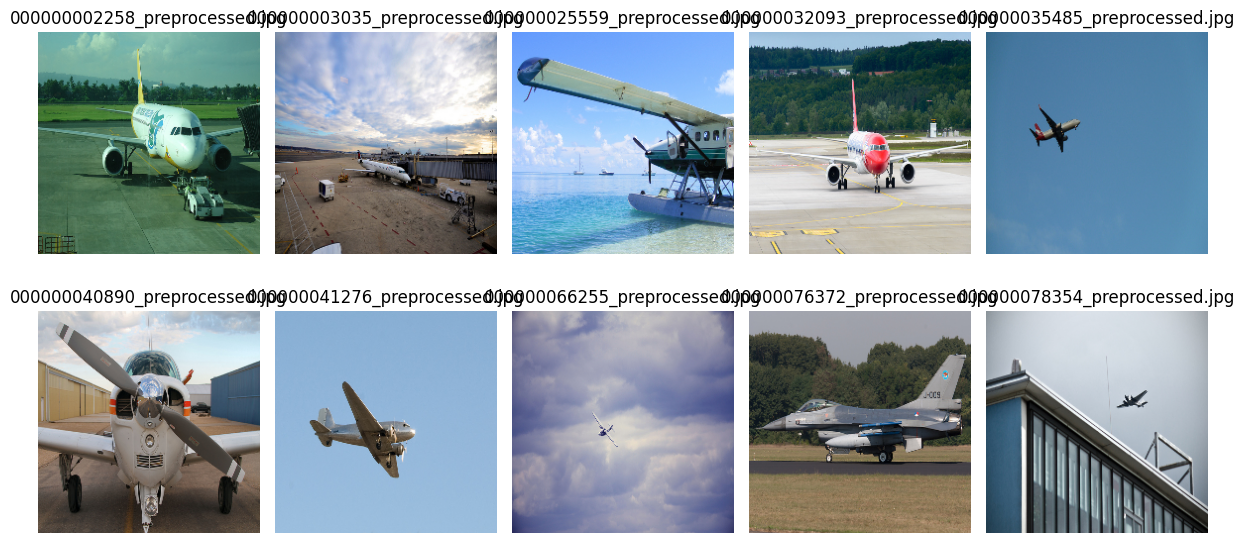

In [ ]:
# Sample data (replace this with your DataFrame)
df_vehicle = pd.DataFrame({
    'image_file': df_vehicle["image_file"],
    'memoscore': df_vehicle["memorability_wo_fa_correction"]
})

# Create a new column to store the paths of preprocessed images
df_vehicle['preprocessed_image_path'] = ''

# Empty lists to store preprocessed images
images = []

# Load and preprocess images
for index, row in df_vehicle.iterrows():
    image_path = row['image_file']
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (224, 224))  # Resize image if necessary

    # Save preprocessed image to the same path
    preprocessed_path = os.path.splitext(image_path)[0] + '_preprocessed.jpg'
    cv2.imwrite(preprocessed_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # Store preprocessed image path in the DataFrame
    df_vehicle.at[index, 'preprocessed_image_path'] = preprocessed_path

    images.append(image)

# Convert the list of images into a NumPy array
images = np.array(images)

# Save preprocessed images as NumPy array (if needed)
#np.save('/content/drive/MyDrive/your_folder/preprocessed_images.npy', images)

# Calculate basic image statistics
print('Image shape:', images.shape)
print('Minimum pixel value:', np.min(images))
print('Maximum pixel value:', np.max(images))
print('Mean pixel value:', np.mean(images))
print('Standard deviation of pixel values:', np.std(images))

# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for i in range(min(10, len(images))):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(df_vehicle.at[i, 'preprocessed_image_path']))  # Display file name as title
plt.tight_layout()
plt.show()

# Display the updated DataFrame with preprocessed image paths
#print(df_landscape)

In [ ]:
df_vehicle.head()

image_file  memoscore  \
0  /content/vehicle/000000002258.jpg   0.686869   
1  /content/vehicle/000000003035.jpg   0.750000   
2  /content/vehicle/000000025559.jpg   0.722222   
3  /content/vehicle/000000032093.jpg   0.626168   
4  /content/vehicle/000000035485.jpg   0.800000   

                          preprocessed_image_path  
0  /content/vehicle/000000002258_preprocessed.jpg  
1  /content/vehicle/000000003035_preprocessed.jpg  
2  /content/vehicle/000000025559_preprocessed.jpg  
3  /content/vehicle/000000032093_preprocessed.jpg  
4  /content/vehicle/000000035485_preprocessed.jpg

In [ ]:
del df_vehicle["image_file"]

In [ ]:
df_vehicle.head()

memoscore                         preprocessed_image_path
0   0.686869  /content/vehicle/000000002258_preprocessed.jpg
1   0.750000  /content/vehicle/000000003035_preprocessed.jpg
2   0.722222  /content/vehicle/000000025559_preprocessed.jpg
3   0.626168  /content/vehicle/000000032093_preprocessed.jpg
4   0.800000  /content/vehicle/000000035485_preprocessed.jpg

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(df_vehicle.drop('memoscore', axis=1)), pd.DataFrame(df_vehicle['memoscore']), test_size=0.1)

# Split the validation set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

# Print the train, validation, and test set sizes
print('Train set size:', len(X_train))
print('Validation set size:', len(X_val))
print('Test set size:', len(X_test))

Train set size: 1800
Validation set size: 100
Test set size: 100


In [ ]:
X_train.head()

preprocessed_image_path
1124  /content/vehicle/n03791053_12064_preprocessed.jpg
1329     /content/vehicle/000000436651_preprocessed.jpg
618   /content/vehicle/n02878222_38486_preprocessed.jpg
1098   /content/vehicle/n02932891_7006_preprocessed.jpg
630   /content/vehicle/n02878222_49287_preprocessed.jpg

In [ ]:
merged_train_vehicle= pd.concat([X_train, y_train], axis=1)
merged_train_vehicle

preprocessed_image_path  memoscore
1124  /content/vehicle/n03791053_12064_preprocessed.jpg   0.884615
1329     /content/vehicle/000000436651_preprocessed.jpg   0.732759
618   /content/vehicle/n02878222_38486_preprocessed.jpg   0.651163
1098   /content/vehicle/n02932891_7006_preprocessed.jpg   0.731959
630   /content/vehicle/n02878222_49287_preprocessed.jpg   0.596330
...                                                 ...        ...
1280   /content/vehicle/n04349306_4822_preprocessed.jpg   0.900000
1841  /content/vehicle/n04467665_18765_preprocessed.jpg   0.681416
240    /content/vehicle/n02924116_6042_preprocessed.jpg   0.815534
166     /content/vehicle/n02834778_642_preprocessed.jpg   0.824561
1863   /content/vehicle/n04467665_3303_preprocessed.jpg   0.670330

[1800 rows x 2 columns]

In [ ]:
merged_val_vehicle = pd.concat([X_val, y_val], axis=1)
merged_val_vehicle

preprocessed_image_path  memoscore
1804  /content/vehicle/n04335435_8885_preprocessed.jpg   0.797980
25      /content/vehicle/000000180098_preprocessed.jpg   0.670330
1297  /content/vehicle/n04349306_6258_preprocessed.jpg   0.878788
383   /content/vehicle/n02946348_6967_preprocessed.jpg   0.822034
1295  /content/vehicle/n04349306_5722_preprocessed.jpg   0.840909
...                                                ...        ...
1246  /content/vehicle/n04349306_1863_preprocessed.jpg   0.926316
1183  /content/vehicle/n03791053_7039_preprocessed.jpg   0.671053
961     /content/vehicle/000000225731_preprocessed.jpg   0.880952
1826    /content/vehicle/000000569829_preprocessed.jpg   0.771930
67      /content/vehicle/000000563295_preprocessed.jpg   0.603960

[100 rows x 2 columns]

In [ ]:
merged_test_vehicle = pd.concat([X_test, y_test], axis=1)
merged_test_vehicle

preprocessed_image_path  memoscore
1170   /content/vehicle/n03791053_5242_preprocessed.jpg   0.822222
430    /content/vehicle/n04166281_5438_preprocessed.jpg   0.836364
1081  /content/vehicle/n02932891_36476_preprocessed.jpg   0.625000
1428  /content/vehicle/n04461696_11028_preprocessed.jpg   0.782178
1770  /content/vehicle/n04335435_25710_preprocessed.jpg   0.861702
...                                                 ...        ...
1990   /content/vehicle/n04610013_7160_preprocessed.jpg   0.750000
338   /content/vehicle/n02946348_17390_preprocessed.jpg   0.648148
1916  /content/vehicle/n04610013_12107_preprocessed.jpg   0.678261
1422   /content/vehicle/n03594945_9793_preprocessed.jpg   0.726415
824    /content/vehicle/n03541923_4142_preprocessed.jpg   0.829787

[100 rows x 2 columns]

# Save CSV To GGDrive

In [ ]:
# บันทึกตารางเป็นไฟล์ CSV
csv_train_vehicle= '/content/drive/MyDrive/IS/MemCat_data/dataproject/train/vehicle_Vit.csv'
merged_train_vehicle.to_csv(csv_train_vehicle, index=False)

In [ ]:
csv_val_vehicle = '/content/drive/MyDrive/IS/MemCat_data/dataproject/val/vehicle_Vit.csv'
merged_val_vehicle.to_csv(csv_val_vehicle, index=False)

In [ ]:
csv_test_vehicle = '/content/drive/MyDrive/IS/MemCat_data/dataproject/test/vehicle_Vit.csv'
merged_test_vehicle.to_csv(csv_test_vehicle, index=False)

#Load Dataset

In [ ]:
df_train_vehicle = pd.read_csv("/content/drive/MyDrive/IS/MemCat_data/dataproject/train/vehicle_Vit.csv")
df_val_vehicle = pd.read_csv( '/content/drive/MyDrive/IS/MemCat_data/dataproject/val/vehicle_Vit.csv')
df_test_vehicle = pd.read_csv('/content/drive/MyDrive/IS/MemCat_data/dataproject/test/vehicle_Vit.csv')

In [ ]:
df_train_vehicle.head()

preprocessed_image_path  memoscore
0   /content/vehicle/n03351262_8162_preprocessed.jpg   0.630435
1  /content/vehicle/n02691156_10578_preprocessed.jpg   0.571429
2    /content/vehicle/n04349306_195_preprocessed.jpg   0.761062
3  /content/vehicle/n04610013_18232_preprocessed.jpg   0.594595
4  /content/vehicle/n04610013_24400_preprocessed.jpg   0.673913

In [ ]:
df_train_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   preprocessed_image_path  1800 non-null   object 
 1   memoscore                1800 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.2+ KB


#Load Pretrain

In [ ]:
# Define function to add data/model in to GPU (cuda)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    # if data is list or tuple, move each of them to device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device) -> None:
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            # yield only execuate when the function is called
            yield to_device(b, self. device)

    def __len__(self):
        return len(self.dl)

## Train

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, trans_transform=None):
        self.labels = df_train_vehicle["memoscore"]
        self.images = df_train_vehicle["preprocessed_image_path"]
        self.trans_transform = trans_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)

        image_trans = self.trans_transform(image, return_tensors='pt')
        image_trans = image_trans['pixel_values'].squeeze()

        # แสดงขนาดรูปภาพหลังการ transform
        #print("Transformed image size:", image_trans.shape)

        label = self.labels[idx]

        return image_trans, label

# สร้างตัวแปรสำหรับ ViTFeatureExtractor
trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# สร้าง Dataset และ DataLoader
train_ds = Dataset(df_train_vehicle, trans_transform=trans_transform)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=False)

# เรียกดูข้อมูลจาก DataLoader
'''for image_trans, label in train_dl:
    # คำสั่งนี้จะแสดงขนาดของรูปภาพที่ transform แล้วในแต่ละ batch
    print(image_trans)
    break'''


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


'for image_trans, label in train_dl:\n    # คำสั่งนี้จะแสดงขนาดของรูปภาพที่ transform แล้วในแต่ละ batch\n    print(image_trans)\n    break'

In [ ]:
class ViTMem_model(torch.nn.Module):
    def __init__(self, arch="vit_base_patch16_224_miil"):
        super().__init__()
        self.arch = arch
        self.vit = timm.create_model(self.arch, pretrained=True, num_classes=1)
        self.trans_AdaptiveAvgPool = nn.AdaptiveAvgPool2d((1, None))


    def forward(self, x):
        vitfeat = self.vit(x)
        adap = self.trans_AdaptiveAvgPool(x)
        out = torch.sigmoid(vitfeat)
        return out



NORMALIZE_MEAN = (0.0, 0.0, 0.0)
NORMALIZE_STD = (1.0, 1.0, 1.0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

model_vit =  ViTMem_model( arch="vit_base_patch16_224_miil")



model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
# Assuming your model is an instance of YourModelClass and is already on GPU
model = ViTMem_model().cuda()

# Assuming your input tensor shape
input_tensor_shape = ( 3   ,224,224)

# Print the model summary
summary(model, input_tensor_shape)




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,769,472
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [ ]:
# Add data and model to GPU
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
model_vit  = to_device(model_vit  , device)

In [ ]:
params = [param for param in list(model_vit.parameters()) if param.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)


In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit, train_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit.train()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in train_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)


In [ ]:
# Training the model and save weights
fit(50, model_vit , train_dl)
torch.save(model_vit.state_dict(), "model_weights_1")

In [ ]:
true_values_list = []
predicted_values_list = []

for x_trans, yb in train_dl:
    preds = model_vit(x_trans)
    true_values_list.extend(yb.cpu().detach().numpy())
    predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



# Assuming 'df_test_vehicle' is your original DataFrame and 'true_values' and 'predicted_values' are lists of true and predicted values
df_result = pd.DataFrame({
    'Image Path': df_train_vehicle['preprocessed_image_path'],
    'True Value': true_values_list,  # Replace with your actual true values
    'Predicted Value': predicted_values_list  # Replace with your actual predicted values
})

# Display the resulting DataFrame
print(df_result)



                                             Image Path  True Value  \
0      /content/vehicle/n03351262_8162_preprocessed.jpg    0.630435   
1     /content/vehicle/n02691156_10578_preprocessed.jpg    0.571429   
2       /content/vehicle/n04349306_195_preprocessed.jpg    0.761062   
3     /content/vehicle/n04610013_18232_preprocessed.jpg    0.594595   
4     /content/vehicle/n04610013_24400_preprocessed.jpg    0.673913   
...                                                 ...         ...   
1795  /content/vehicle/n03594945_18118_preprocessed.jpg    0.758242   
1796  /content/vehicle/n03791053_11306_preprocessed.jpg    0.806452   
1797   /content/vehicle/n03791053_6359_preprocessed.jpg    0.845361   
1798   /content/vehicle/n04610013_2504_preprocessed.jpg    0.686869   
1799  /content/vehicle/n04467665_13331_preprocessed.jpg    0.621359   

      Predicted Value  
0            0.613818  
1            0.596991  
2            0.830262  
3            0.592368  
4            0.686231  
...

In [ ]:
from prettytable import PrettyTable

# Assuming 'df_result' is your DataFrame
# The 'Image Path' column should contain the paths to your images

# Create a PrettyTable instance
table = PrettyTable()

# Add column names
table.field_names = df_result.columns.tolist()

# Add rows
for _, row in df_result.iterrows():
    table.add_row(row.tolist())

# Display the table
print(table)

+---------------------------------------------------+------------+---------------------+
|                     Image Path                    | True Value |   Predicted Value   |
+---------------------------------------------------+------------+---------------------+
|  /content/vehicle/n03351262_8162_preprocessed.jpg | 0.6304348  |  0.6138178706169128 |
| /content/vehicle/n02691156_10578_preprocessed.jpg | 0.5714286  |  0.5969906449317932 |
|  /content/vehicle/n04349306_195_preprocessed.jpg  | 0.76106197 |  0.8302620053291321 |
| /content/vehicle/n04610013_18232_preprocessed.jpg | 0.5945946  |  0.5923677086830139 |
| /content/vehicle/n04610013_24400_preprocessed.jpg | 0.67391306 |  0.6862310171127319 |
|   /content/vehicle/000000197384_preprocessed.jpg  | 0.7586207  |  0.7988694906234741 |
| /content/vehicle/n03670208_40668_preprocessed.jpg | 0.7407407  |  0.6919965744018555 |
|   /content/vehicle/000000384964_preprocessed.jpg  | 0.82222223 |  0.8271860480308533 |
|  /content/vehicle/n

## Valid

In [ ]:
class Dataset_val(Dataset):
    def __init__(self, df, trans_transform=None):
        self.labels = df_val_vehicle["memoscore"]
        self.images = df_val_vehicle["preprocessed_image_path"]
        self.trans_transform = trans_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)

        image_trans = self.trans_transform(image, return_tensors='pt')
        image_trans = image_trans['pixel_values'].squeeze()

        # แสดงขนาดรูปภาพหลังการ transform
        #print("Transformed image size:", image_trans.shape)

        label = self.labels[idx]

        return image_trans, label

# สร้างตัวแปรสำหรับ ViTFeatureExtractor
trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# สร้าง Dataset และ DataLoader
val_ds = Dataset_val(df_val_vehicle, trans_transform=trans_transform)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
class ViTMem_model_sval(torch.nn.Module):
    def __init__(self, arch="vit_base_patch16_224_miil"):
        super().__init__()
        self.arch = arch
        self.vit = timm.create_model(self.arch, pretrained=True, num_classes=1)
        self.trans_AdaptiveAvgPool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        vitfeat = self.vit(x)
        adap = self.trans_AdaptiveAvgPool(x)
        out = torch.sigmoid(vitfeat)
        return out



NORMALIZE_MEAN = (0.0, 0.0, 0.0)
NORMALIZE_STD = (1.0, 1.0, 1.0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

model_vit_sval =  ViTMem_model_sval( arch="vit_base_patch16_224_miil")

In [ ]:


# Assuming your model is an instance of YourModelClass and is already on GPU
model = ViTMem_model_sval().cuda()

# Assuming your input tensor shape
input_tensor_shape = ( 3   ,224,224)

# Print the model summary
summary(model, input_tensor_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,769,472
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [ ]:
device = get_default_device()
val_dl = DeviceDataLoader(val_dl, device)
model_vit_sval  = to_device(model_vit_sval  , device)

In [ ]:
params = [param for param in list(model_vit_sval.parameters()) if param.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-5)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit_sval, val_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit_sval.train()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in val_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit_sval(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)

In [ ]:
# val the model and save weights
fit(50, model_vit_sval , val_dl )
torch.save(model_vit_sval.state_dict(), "model_weights_s")

In [ ]:
true_values_list_val = []
predicted_values_list_val = []

for x_trans, yb in val_dl:
    preds = model_vit(x_trans)
    true_values_list_val.extend(yb.cpu().detach().numpy())
    predicted_values_list_val.extend(preds.squeeze().cpu().detach().numpy())



# Assuming 'df_test_vehicle' is your original DataFrame and 'true_values' and 'predicted_values' are lists of true and predicted values
df_result = pd.DataFrame({
    'Image Path': df_val_vehicle['preprocessed_image_path'],
    'True Value': true_values_list_val,  # Replace with your actual true values
    'Predicted Value': predicted_values_list_val # Replace with your actual predicted values
})

# Display the resulting DataFrame
print(df_result)

                                           Image Path  True Value  \
0    /content/vehicle/n03512147_7299_preprocessed.jpg    0.740741   
1   /content/vehicle/n03670208_11796_preprocessed.jpg    0.841584   
2    /content/vehicle/n02834778_7536_preprocessed.jpg    0.841584   
3      /content/vehicle/000000393064_preprocessed.jpg    0.706522   
4    /content/vehicle/n03790512_3266_preprocessed.jpg    0.853211   
..                                                ...         ...   
95  /content/vehicle/n03384352_12226_preprocessed.jpg    0.839506   
96     /content/vehicle/n04349306_54_preprocessed.jpg    0.670588   
97   /content/vehicle/n04461696_1918_preprocessed.jpg    0.816514   
98    /content/vehicle/n03594945_183_preprocessed.jpg    0.850877   
99     /content/vehicle/000000200391_preprocessed.jpg    0.722892   

    Predicted Value  
0          0.716423  
1          0.819046  
2          0.721042  
3          0.787518  
4          0.837959  
..              ...  
95         0.7171

## Test

In [ ]:
df_test_vehicle.head()


preprocessed_image_path  memoscore
0   /content/vehicle/n03791053_5855_preprocessed.jpg   0.817308
1     /content/vehicle/000000406329_preprocessed.jpg   0.764151
2  /content/vehicle/n04231693_18551_preprocessed.jpg   0.754717
3  /content/vehicle/n04231693_19460_preprocessed.jpg   0.700000
4     /content/vehicle/000000328185_preprocessed.jpg   0.865979

In [ ]:
class Dataset_test(Dataset):
    def __init__(self, df, trans_transform=None):
        self.labels = df_test_vehicle["memoscore"]
        self.images = df_test_vehicle["preprocessed_image_path"]
        self.trans_transform = trans_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)

        image_trans = self.trans_transform(image, return_tensors='pt')
        image_trans = image_trans['pixel_values'].squeeze()

        # แสดงขนาดรูปภาพหลังการ transform
        #print("Transformed image size:", image_trans.shape)

        label = self.labels[idx]

        return image_trans, label

# สร้างตัวแปรสำหรับ ViTFeatureExtractor
trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# สร้าง Dataset และ DataLoader
test_ds = Dataset_test(df_test_vehicle, trans_transform=trans_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
print(test_ds)

In [ ]:
class ViTMem_model_test(torch.nn.Module):
    def __init__(self, arch="vit_base_patch16_224_miil"):
        super().__init__()
        self.arch = arch
        self.vit = timm.create_model(self.arch, pretrained=True, num_classes=1)
        self.trans_AdaptiveAvgPool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        vitfeat = self.vit(x)
        adap = self.trans_AdaptiveAvgPool(x)
        out = torch.sigmoid(vitfeat)
        return out



NORMALIZE_MEAN = (0.0, 0.0, 0.0)
NORMALIZE_STD = (1.0, 1.0, 1.0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

model_vit_test =  ViTMem_model_test( arch="vit_base_patch16_224_miil")

In [ ]:


# Assuming your model is an instance of YourModelClass and is already on GPU
model = ViTMem_model_test().cuda()

# Assuming your input tensor shape
input_tensor_shape = ( 3   ,224,224)

# Print the model summary
summary(model, input_tensor_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,769,472
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [ ]:
device = get_default_device()
test_dl = DeviceDataLoader(test_dl, device)
model_vit_test  = to_device(model_vit_test  , device)

In [ ]:
params = [param for param in list(model_vit_test.parameters()) if param.requires_grad ]
optimizer = torch.optim.Adam(params, lr=1e-4)   #,weight_decay=1e-7

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit_test, test_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit_test.eval()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in test_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit_test(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)


 Epoch: (1/50) Loss = 0.017386363819241524

 Epoch: (1/50) Loss_rmse = 0.13185736536979675

 Epoch: (1/50) R^2 = -22.72832679748535

 Epoch: (1/50) MAE = 0.12864774465560913
Spearman correlation coefficient: SignificanceResult(statistic=0.12001695635468461, pvalue=0.24412718187073063)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.7978

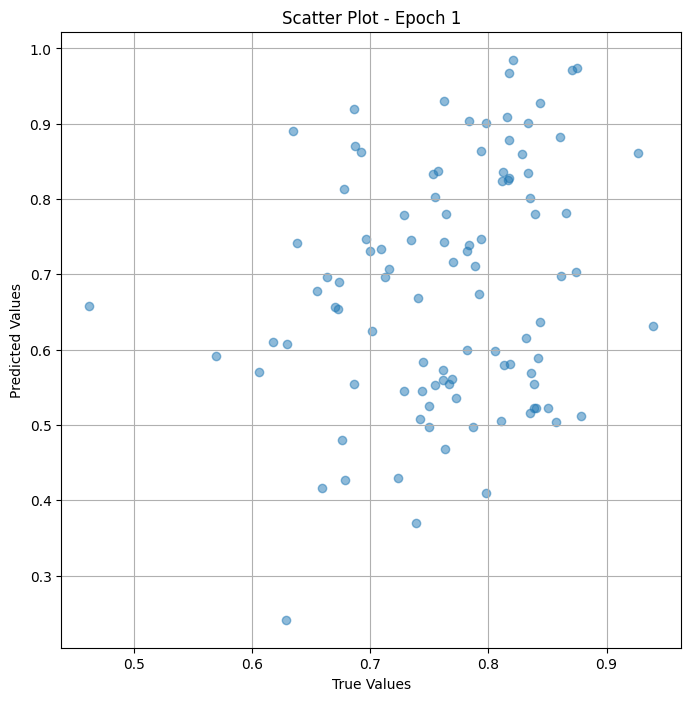

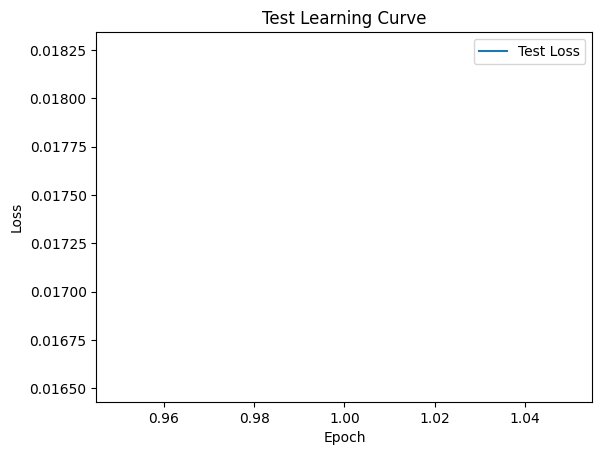


 Epoch: (2/50) Loss = 0.008414775133132935

 Epoch: (2/50) Loss_rmse = 0.09173208475112915

 Epoch: (2/50) R^2 = -10.484203338623047

 Epoch: (2/50) MAE = 0.07568654417991638
Spearman correlation coefficient: SignificanceResult(statistic=0.2814277236521576, pvalue=0.005474978162992597)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.797

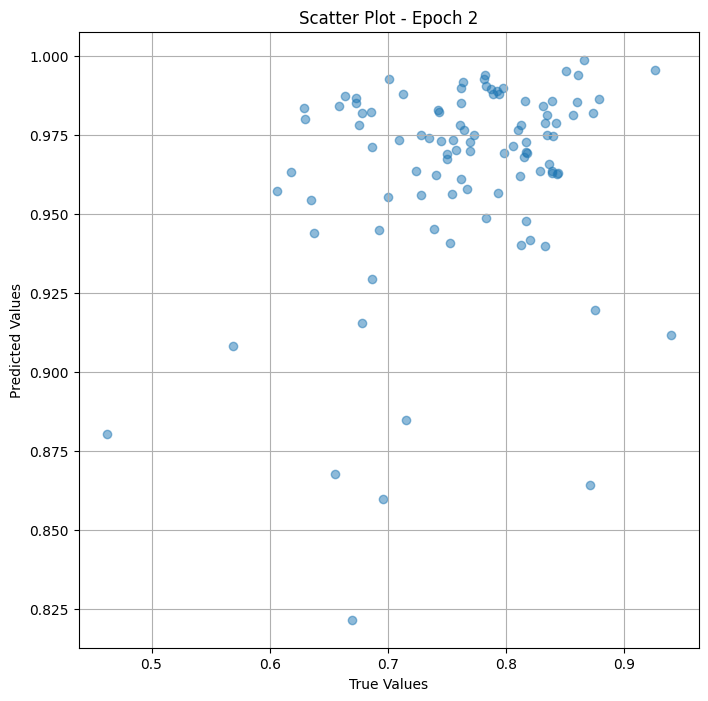

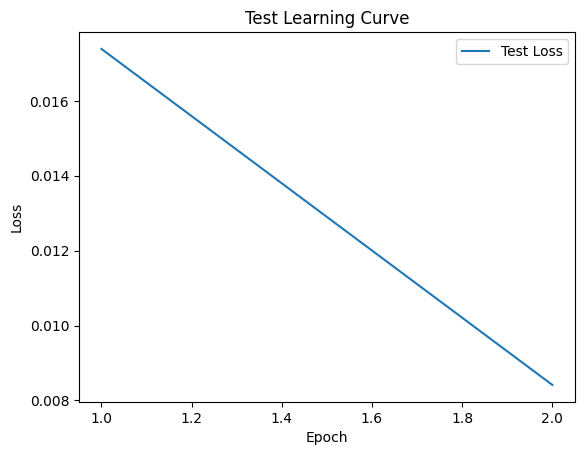


 Epoch: (3/50) Loss = 0.05936103314161301

 Epoch: (3/50) Loss_rmse = 0.243641197681427

 Epoch: (3/50) R^2 = -80.01394653320312

 Epoch: (3/50) MAE = 0.2173776626586914
Spearman correlation coefficient: SignificanceResult(statistic=0.17018058501810635, pvalue=0.09737888647930802)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.79787236

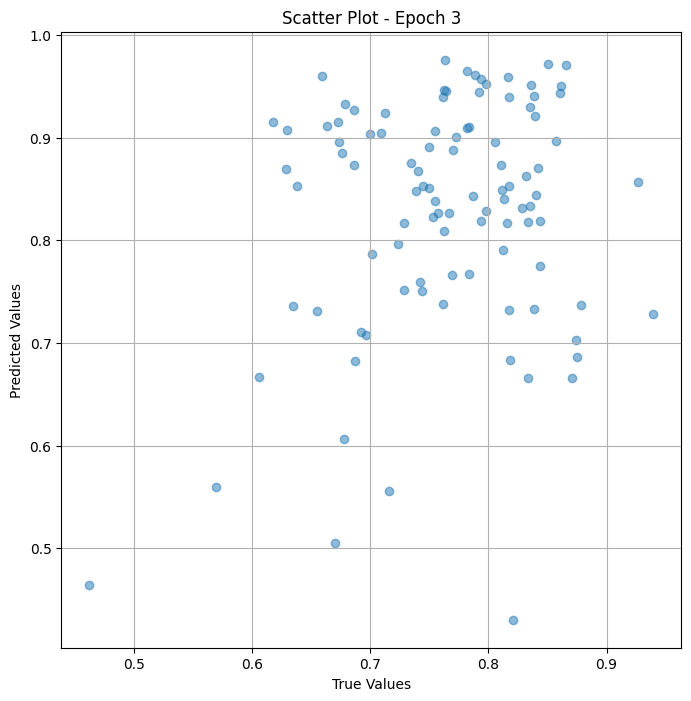

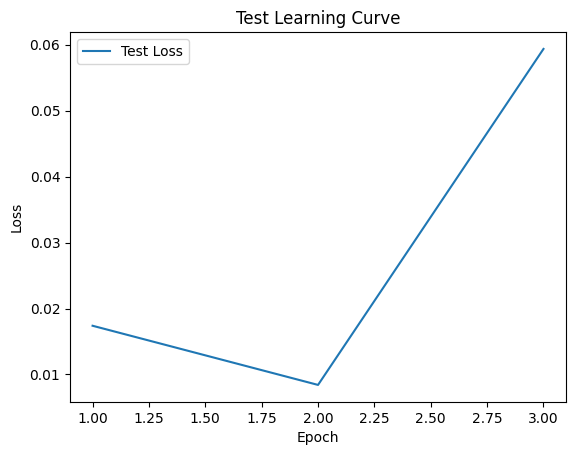


 Epoch: (4/50) Loss = 0.0014761510537937284

 Epoch: (4/50) Loss_rmse = 0.03842071071267128

 Epoch: (4/50) R^2 = -1.014601469039917

 Epoch: (4/50) MAE = 0.026702329516410828
Spearman correlation coefficient: SignificanceResult(statistic=0.40804408653598084, pvalue=3.679406990170357e-05)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.

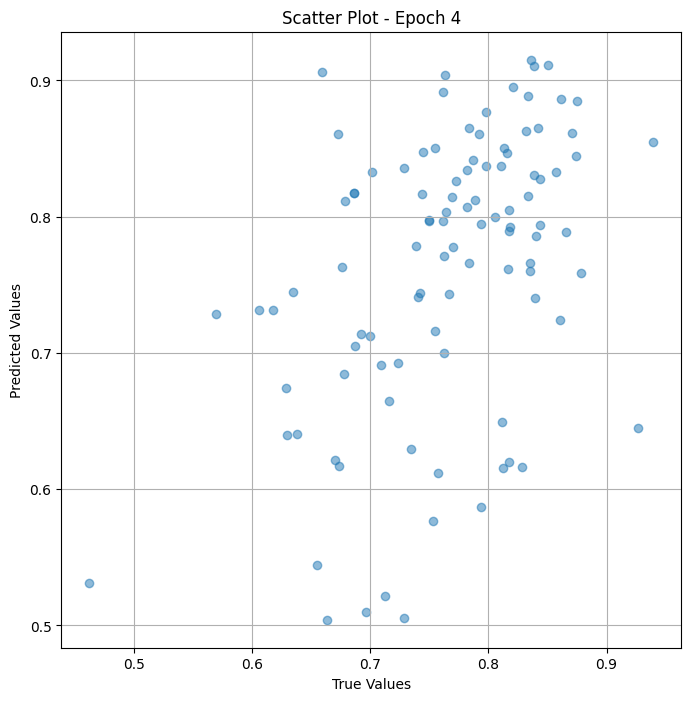

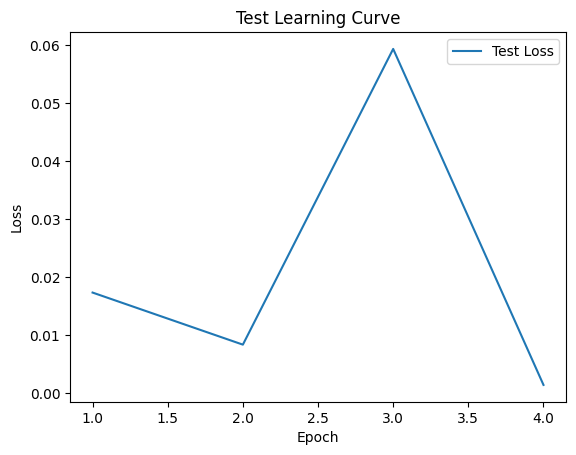


 Epoch: (5/50) Loss = 0.001624592929147184

 Epoch: (5/50) Loss_rmse = 0.04030624032020569

 Epoch: (5/50) R^2 = -1.2171900272369385

 Epoch: (5/50) MAE = 0.03160369396209717
Spearman correlation coefficient: SignificanceResult(statistic=0.639959304882165, pvalue=2.225610709910646e-12)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.797

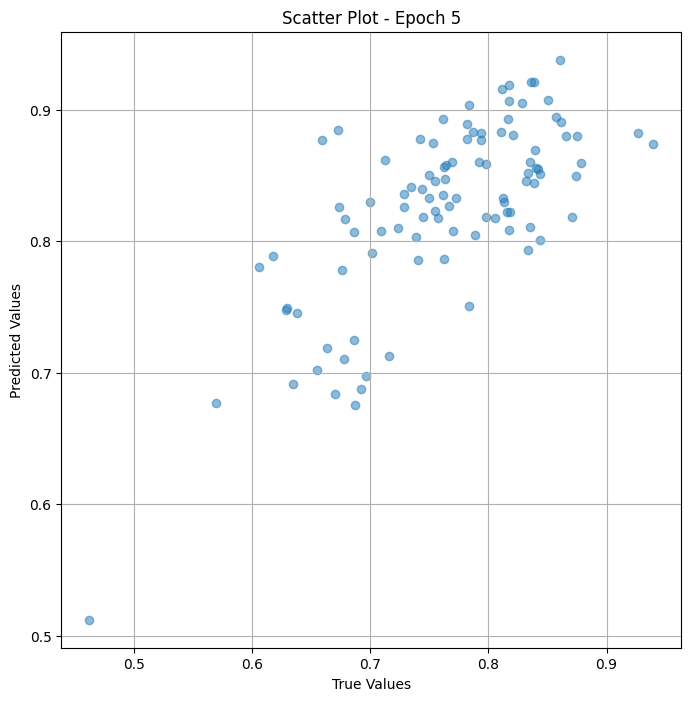

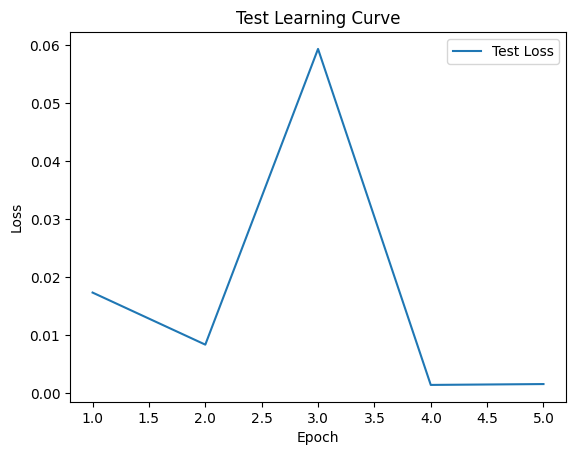


 Epoch: (6/50) Loss = 0.0010828902013599873

 Epoch: (6/50) Loss_rmse = 0.03290729597210884

 Epoch: (6/50) R^2 = -0.47789227962493896

 Epoch: (6/50) MAE = 0.020280227065086365
Spearman correlation coefficient: SignificanceResult(statistic=0.7028740992956183, pvalue=1.4341965127427417e-15)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 

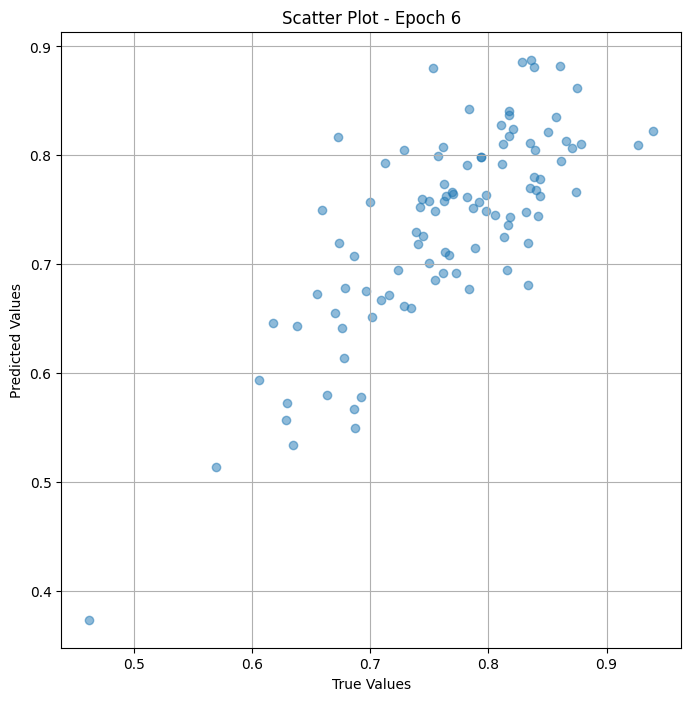

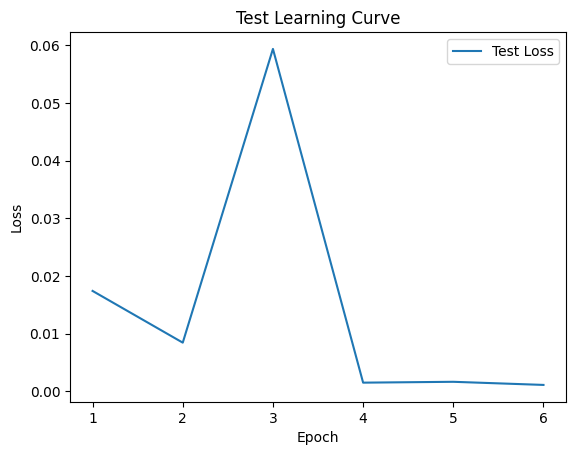


 Epoch: (7/50) Loss = 0.00027717475313693285

 Epoch: (7/50) Loss_rmse = 0.016648566350340843

 Epoch: (7/50) R^2 = 0.6217211484909058

 Epoch: (7/50) MAE = 0.014197960495948792
Spearman correlation coefficient: SignificanceResult(statistic=0.8326782536169495, pvalue=7.307688936966055e-26)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0

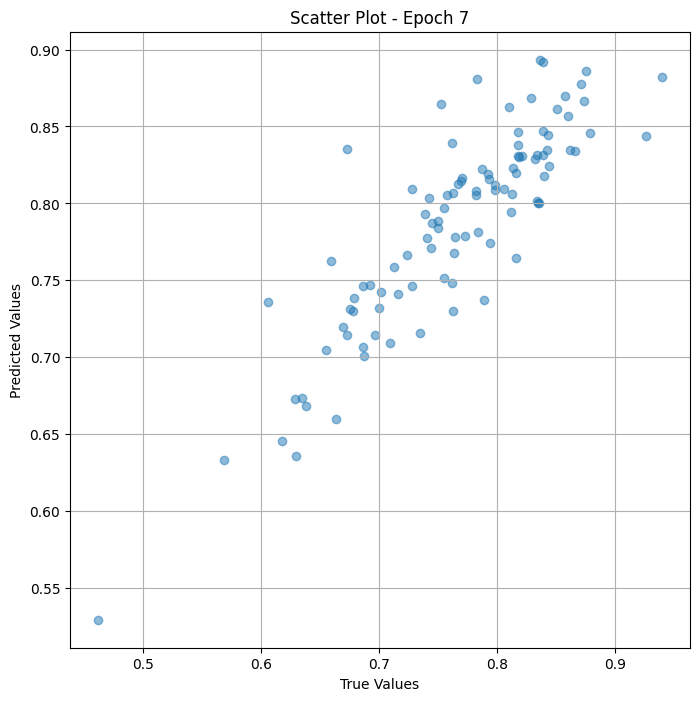

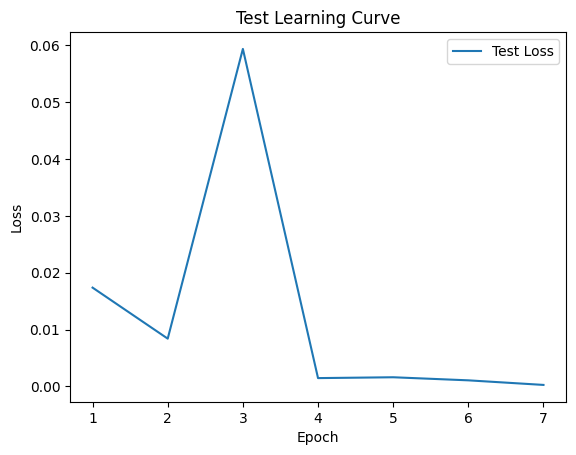


 Epoch: (8/50) Loss = 0.0007242063293233514

 Epoch: (8/50) Loss_rmse = 0.02691108174622059

 Epoch: (8/50) R^2 = 0.011627435684204102

 Epoch: (8/50) MAE = 0.02145761251449585
Spearman correlation coefficient: SignificanceResult(statistic=0.8355743960506001, pvalue=3.452621293637468e-26)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0.

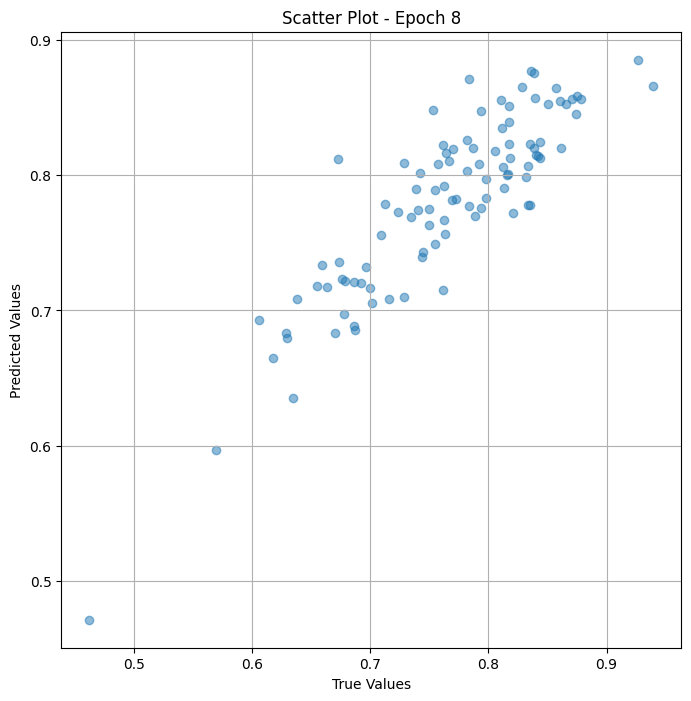

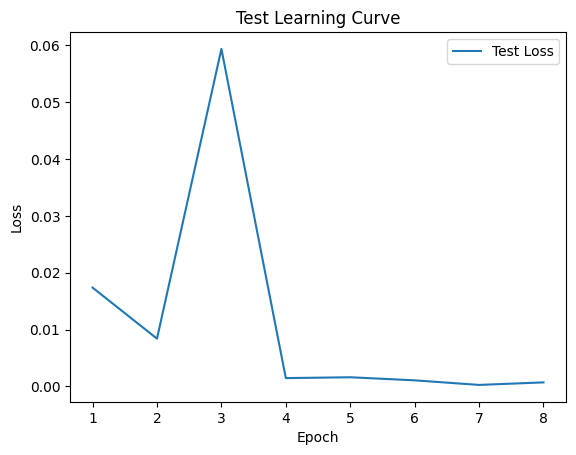


 Epoch: (9/50) Loss = 9.175502054858953e-05

 Epoch: (9/50) Loss_rmse = 0.009578883647918701

 Epoch: (9/50) R^2 = 0.8747758269309998

 Epoch: (9/50) MAE = 0.007797017693519592
Spearman correlation coefficient: SignificanceResult(statistic=0.9024230607486375, pvalue=3.8418234093271506e-36)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 0

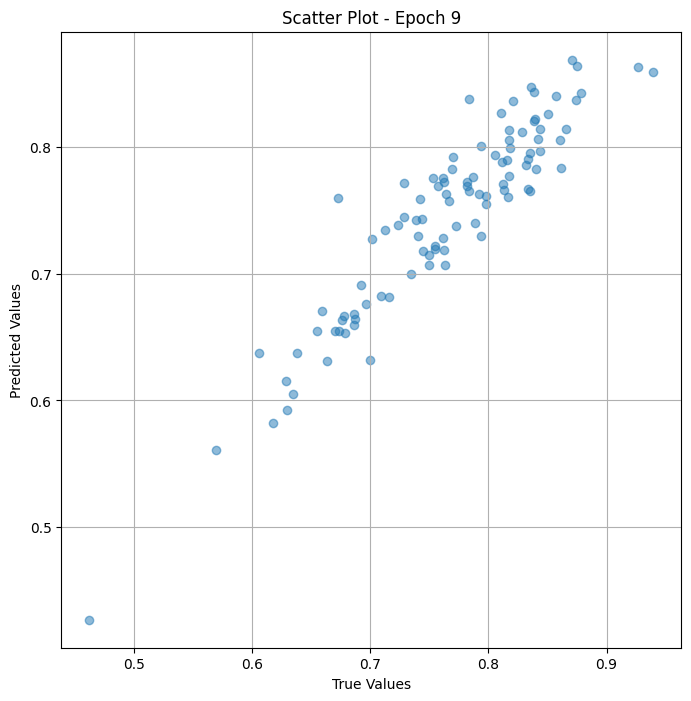

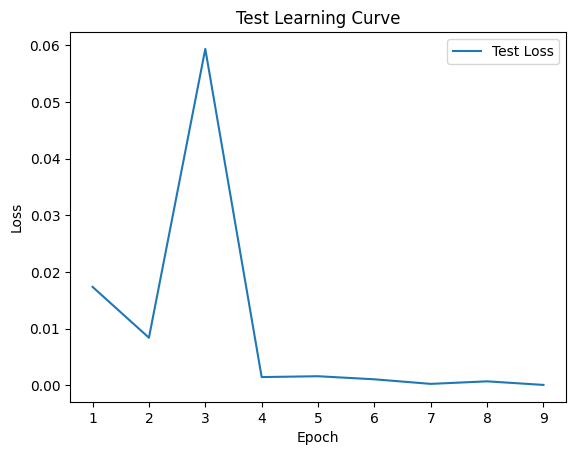


 Epoch: (10/50) Loss = 0.00036361985257826746

 Epoch: (10/50) Loss_rmse = 0.019068818539381027

 Epoch: (10/50) R^2 = 0.5037437677383423

 Epoch: (10/50) MAE = 0.013131797313690186
Spearman correlation coefficient: SignificanceResult(statistic=0.9256735906375249, pvalue=1.8455450698446286e-41)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67289

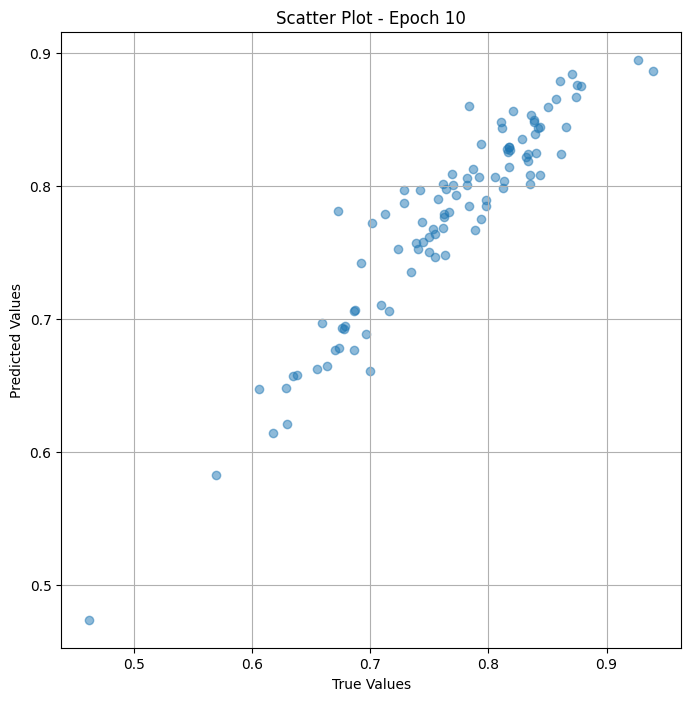

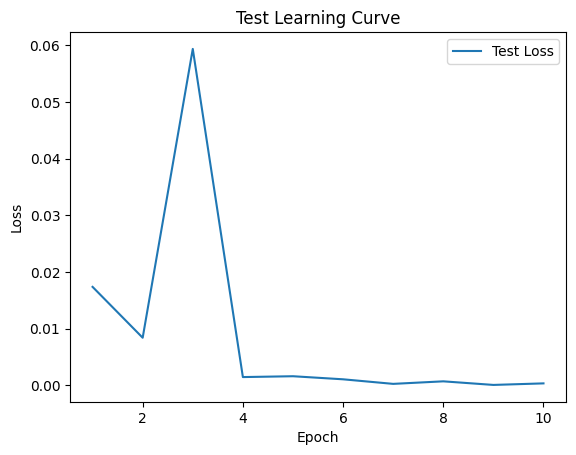


 Epoch: (11/50) Loss = 5.4679396271239966e-05

 Epoch: (11/50) Loss_rmse = 0.007394551765173674

 Epoch: (11/50) R^2 = 0.9253754019737244

 Epoch: (11/50) MAE = 0.005443647503852844
Spearman correlation coefficient: SignificanceResult(statistic=0.9454989403648344, pvalue=1.3599235974075343e-47)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67289

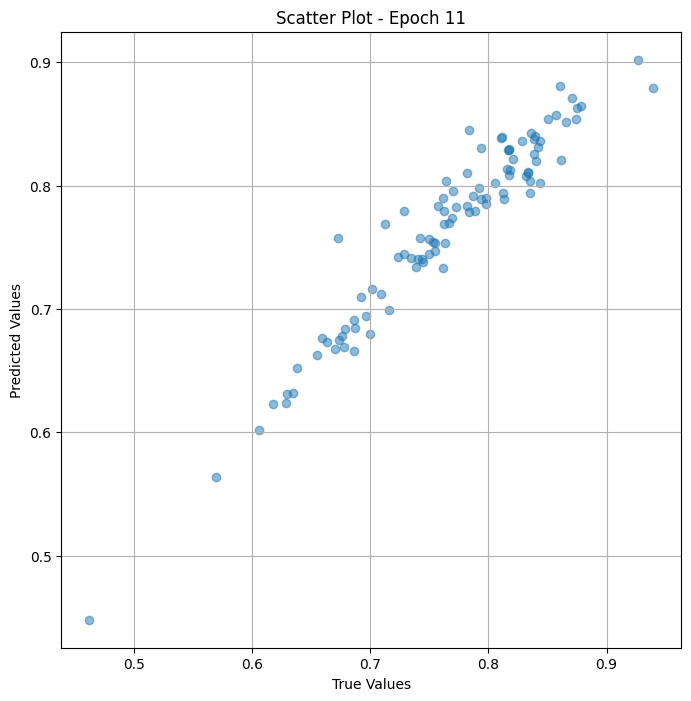

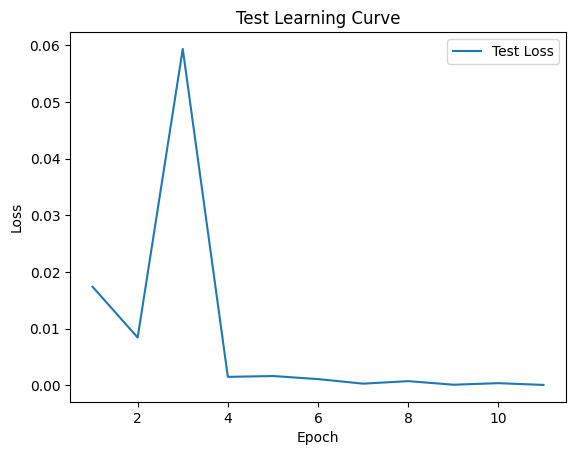


 Epoch: (12/50) Loss = 3.9135302358772606e-05

 Epoch: (12/50) Loss_rmse = 0.0062558213248848915

 Epoch: (12/50) R^2 = 0.946589469909668

 Epoch: (12/50) MAE = 0.005674690008163452
Spearman correlation coefficient: SignificanceResult(statistic=0.9670538365103662, pvalue=1.1875420858451136e-57)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67289

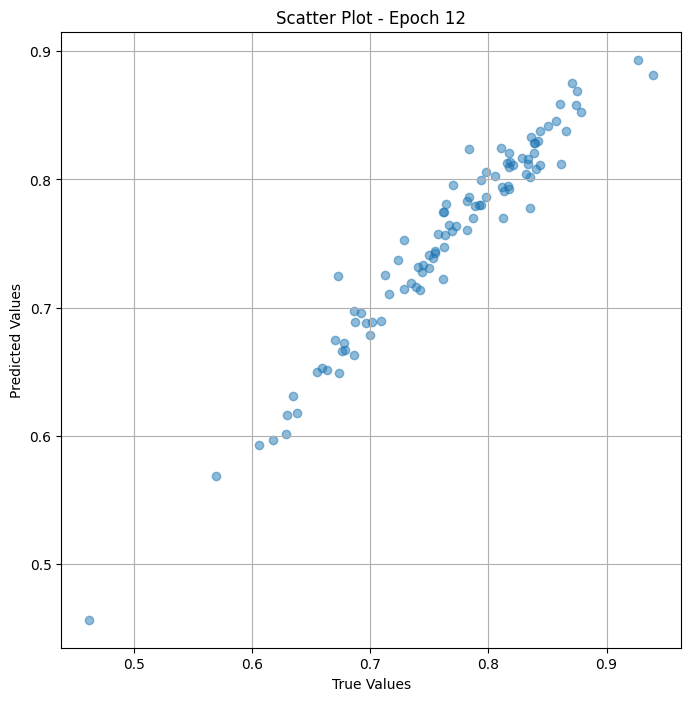

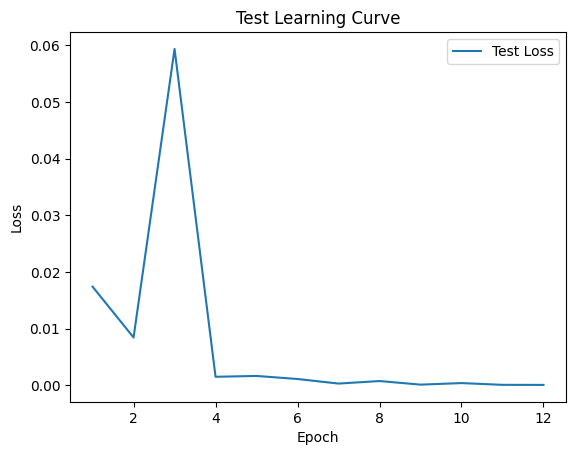


 Epoch: (13/50) Loss = 2.6407904442748986e-05

 Epoch: (13/50) Loss_rmse = 0.005138861946761608

 Epoch: (13/50) R^2 = 0.9639593958854675

 Epoch: (13/50) MAE = 0.004332810640335083
Spearman correlation coefficient: SignificanceResult(statistic=0.977376854739913, pvalue=3.192579350162443e-65)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972

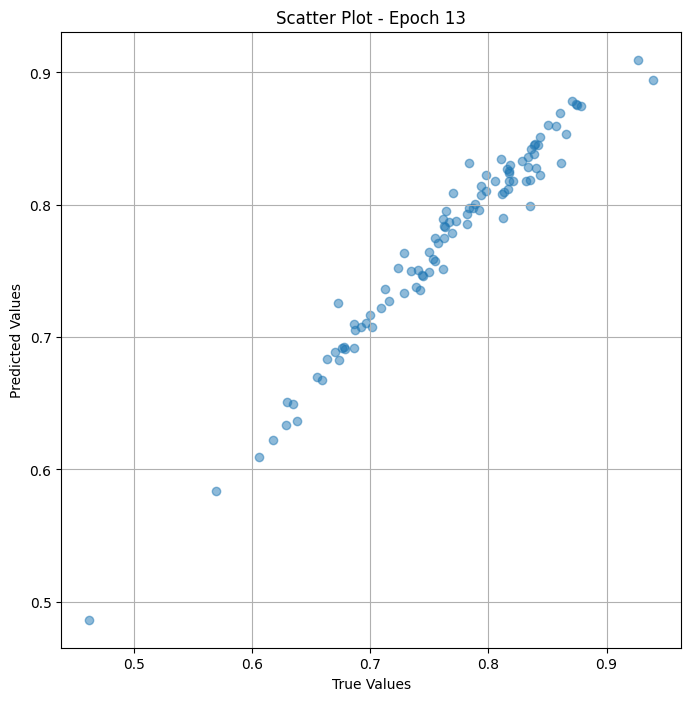

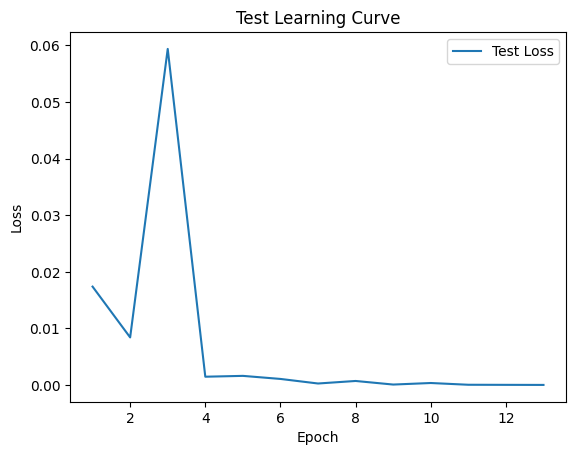


 Epoch: (14/50) Loss = 1.4984137123974506e-05

 Epoch: (14/50) Loss_rmse = 0.003870934946462512

 Epoch: (14/50) R^2 = 0.9795501232147217

 Epoch: (14/50) MAE = 0.003549814224243164
Spearman correlation coefficient: SignificanceResult(statistic=0.9789504028537467, pvalue=1.1172820844145937e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67289

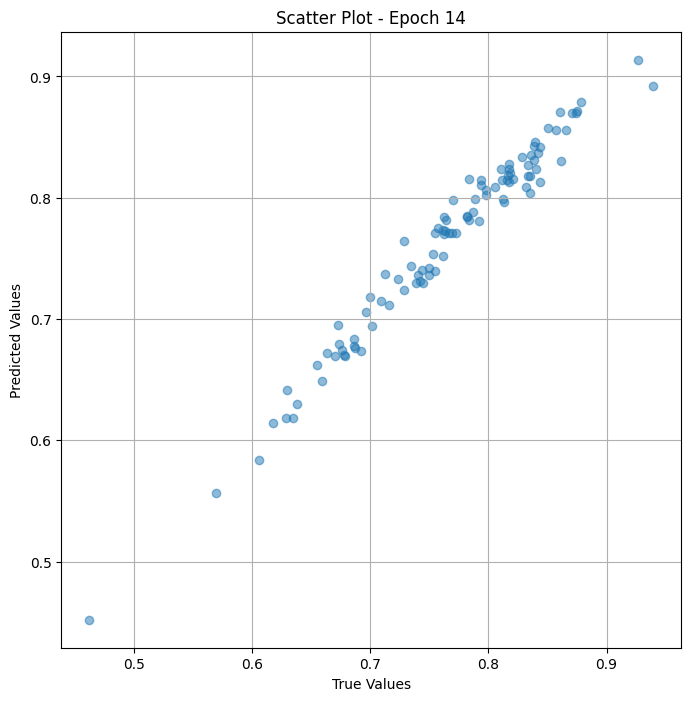

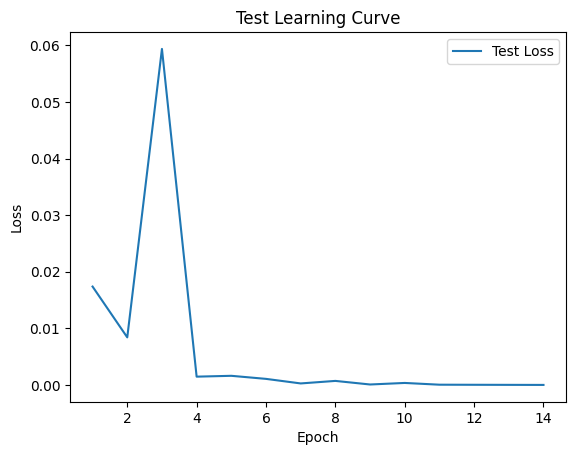


 Epoch: (15/50) Loss = 1.9137038179906085e-05

 Epoch: (15/50) Loss_rmse = 0.004374590236693621

 Epoch: (15/50) R^2 = 0.9738824367523193

 Epoch: (15/50) MAE = 0.0039634108543396
Spearman correlation coefficient: SignificanceResult(statistic=0.9878694363437952, pvalue=7.692105328487284e-78)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972,

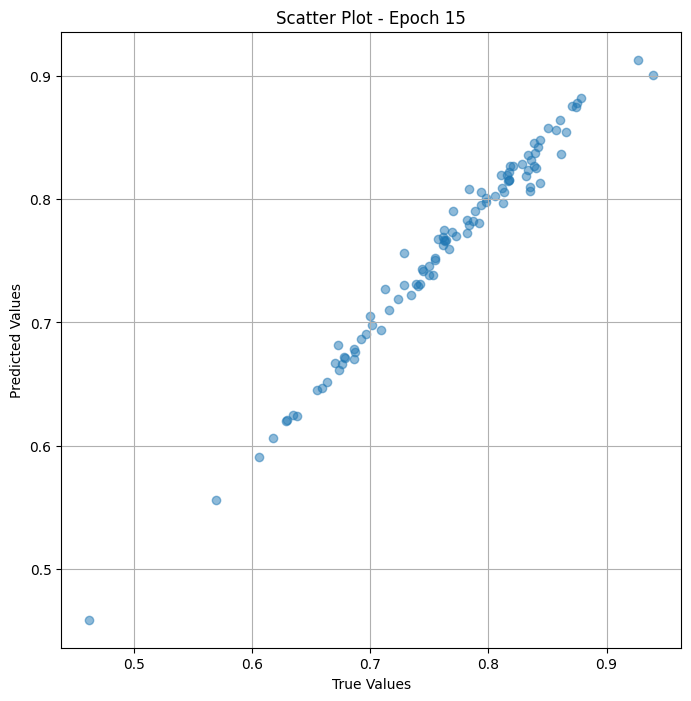

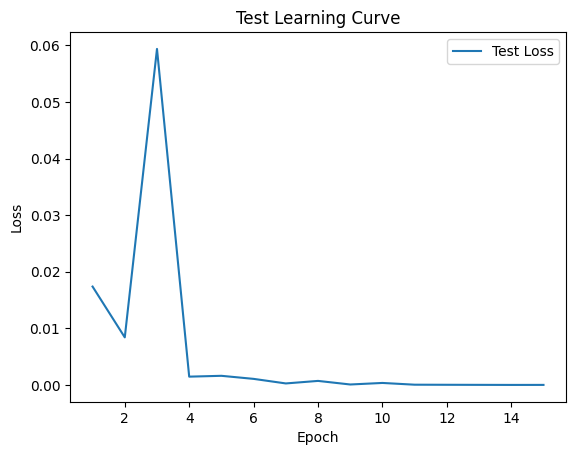


 Epoch: (16/50) Loss = 5.211414645600598e-06

 Epoch: (16/50) Loss_rmse = 0.0022828523069620132

 Epoch: (16/50) R^2 = 0.9928876161575317

 Epoch: (16/50) MAE = 0.002261430025100708
Spearman correlation coefficient: SignificanceResult(statistic=0.9900805427451306, pvalue=6.314108465608445e-82)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672897

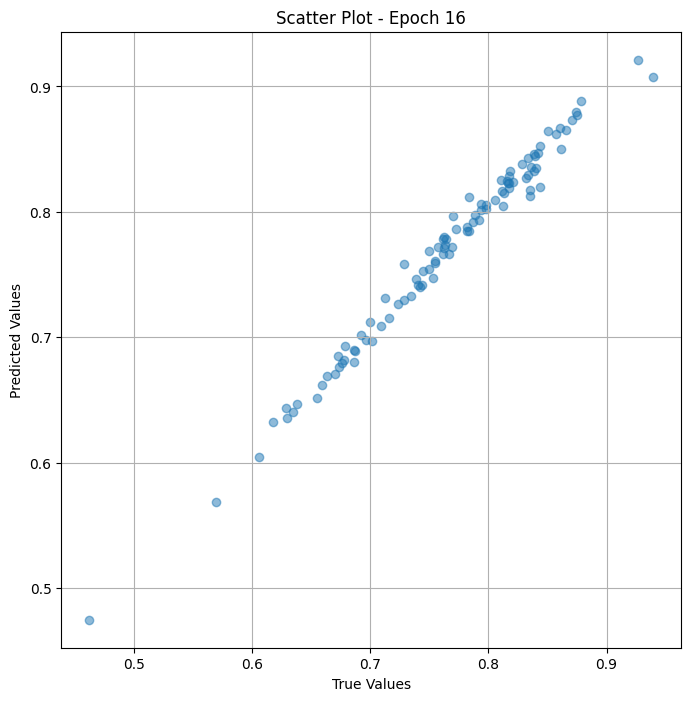

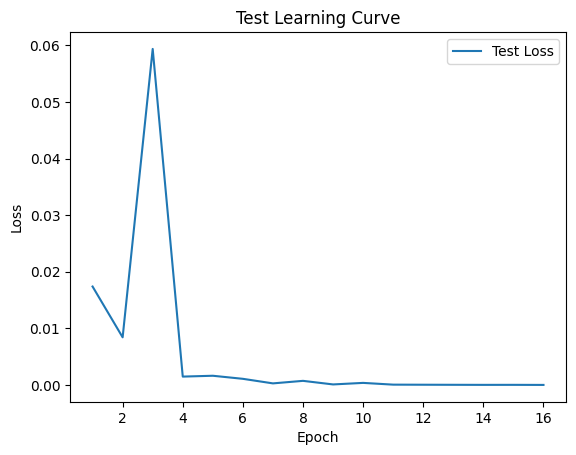


 Epoch: (17/50) Loss = 5.722853984480025e-06

 Epoch: (17/50) Loss_rmse = 0.0023922487162053585

 Epoch: (17/50) R^2 = 0.9921896457672119

 Epoch: (17/50) MAE = 0.002283066511154175
Spearman correlation coefficient: SignificanceResult(statistic=0.993695633885964, pvalue=3.8372801736003395e-91)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672897

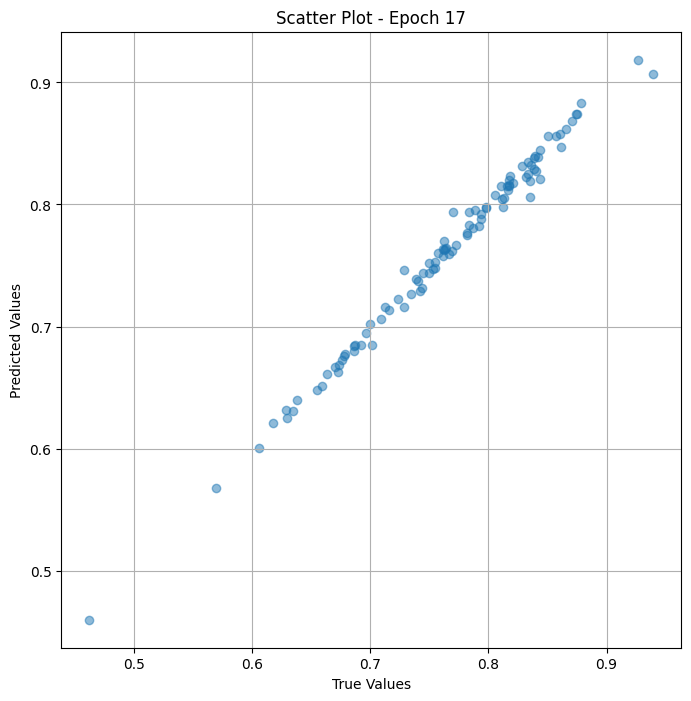

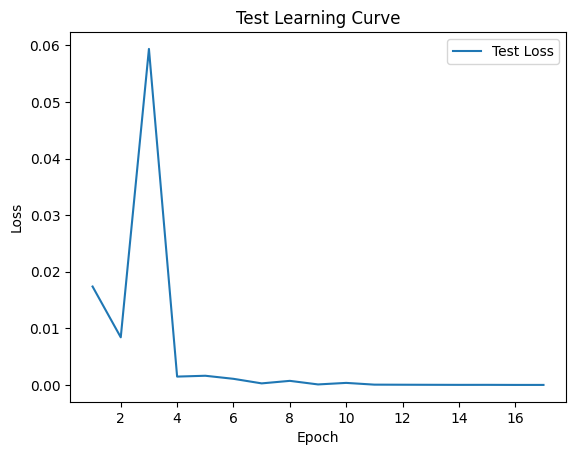


 Epoch: (18/50) Loss = 7.578626536997035e-06

 Epoch: (18/50) Loss_rmse = 0.00275293062441051

 Epoch: (18/50) R^2 = 0.989656925201416

 Epoch: (18/50) MAE = 0.002736523747444153
Spearman correlation coefficient: SignificanceResult(statistic=0.994306062033572, pvalue=3.2453571544900895e-93)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972, 

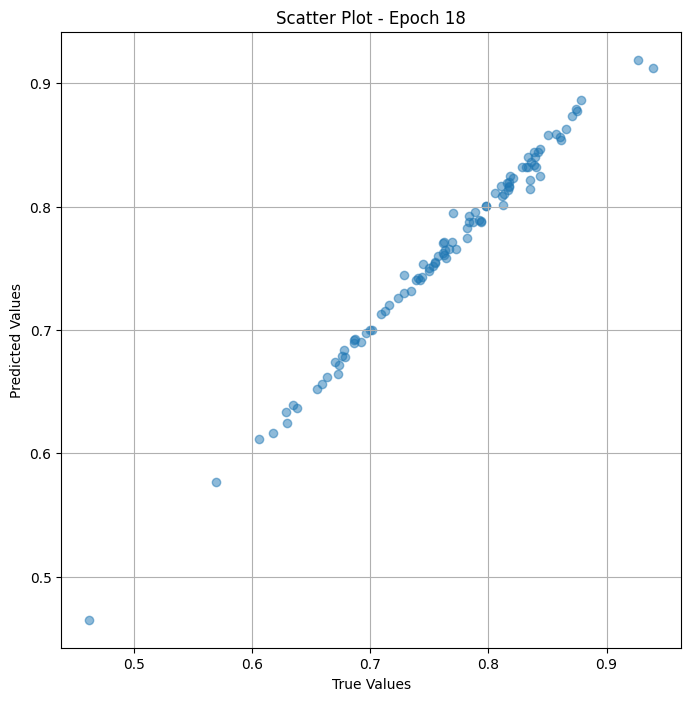

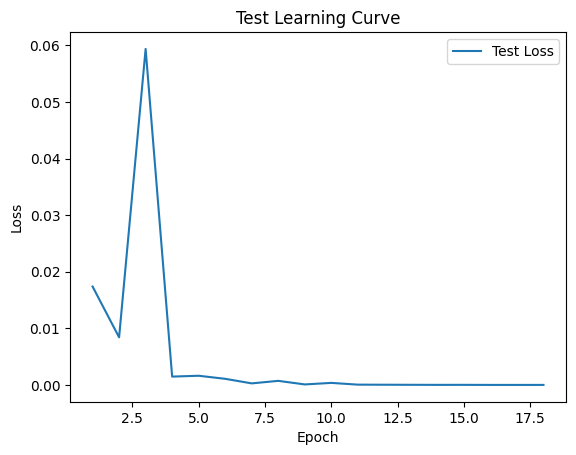


 Epoch: (19/50) Loss = 1.5511521951339091e-06

 Epoch: (19/50) Loss_rmse = 0.001245452556759119

 Epoch: (19/50) R^2 = 0.9978830218315125

 Epoch: (19/50) MAE = 0.0009111166000366211
Spearman correlation coefficient: SignificanceResult(statistic=0.9950317932757279, pvalue=5.437063615488591e-96)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67289

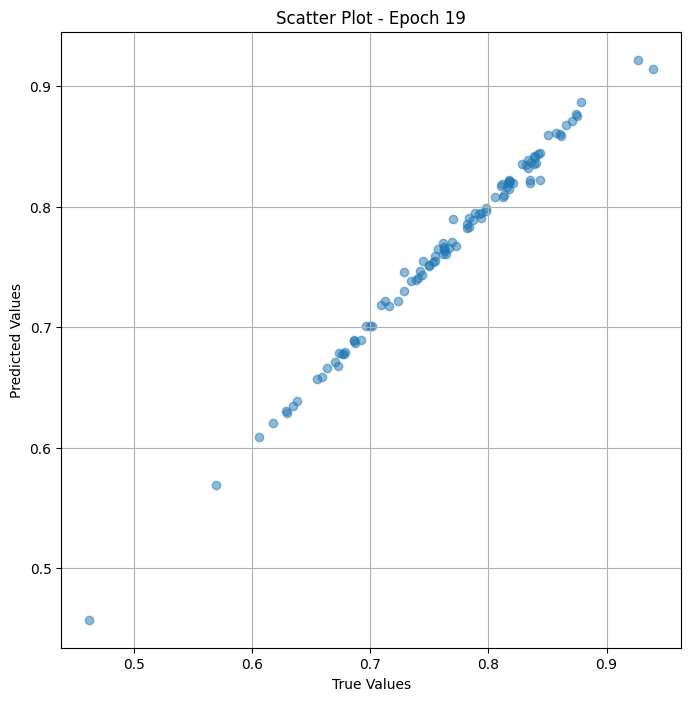

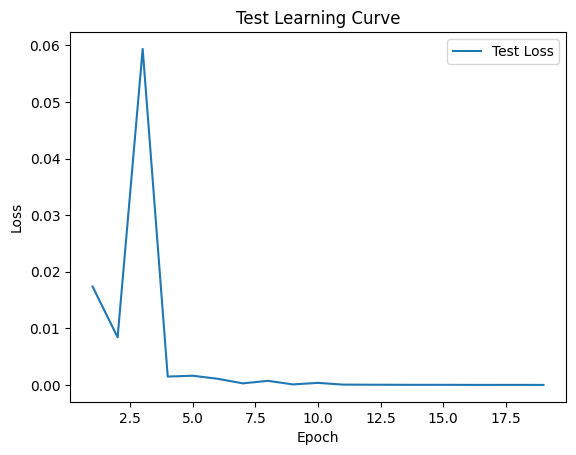


 Epoch: (20/50) Loss = 2.764358555396029e-07

 Epoch: (20/50) Loss_rmse = 0.000525771698448807

 Epoch: (20/50) R^2 = 0.9996227025985718

 Epoch: (20/50) MAE = 0.00045083463191986084
Spearman correlation coefficient: SignificanceResult(statistic=0.9963747352004652, pvalue=2.0706657579189517e-102)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

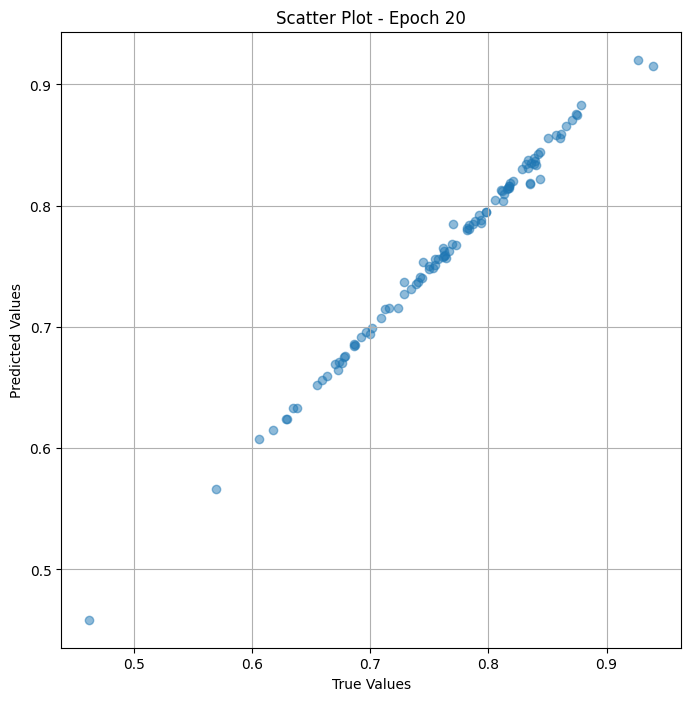

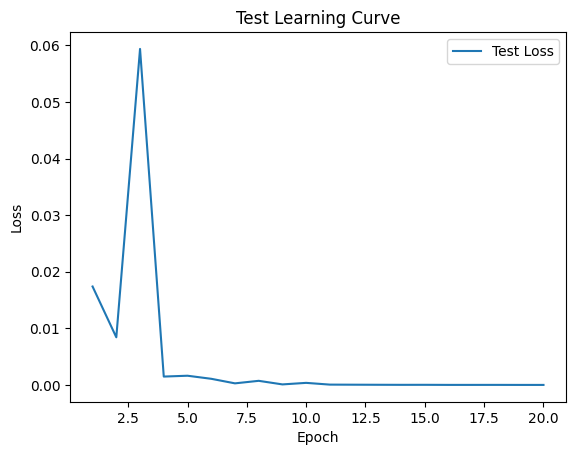


 Epoch: (21/50) Loss = 1.2270985507711885e-06

 Epoch: (21/50) Loss_rmse = 0.001107744756154716

 Epoch: (21/50) R^2 = 0.9983252882957458

 Epoch: (21/50) MAE = 0.0008618533611297607
Spearman correlation coefficient: SignificanceResult(statistic=0.9974124630513986, pvalue=2.7731646146779435e-109)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

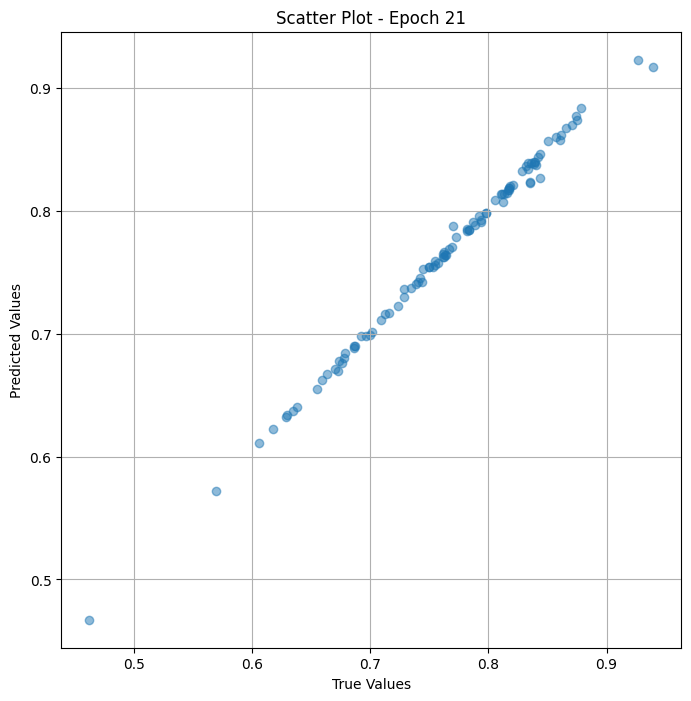

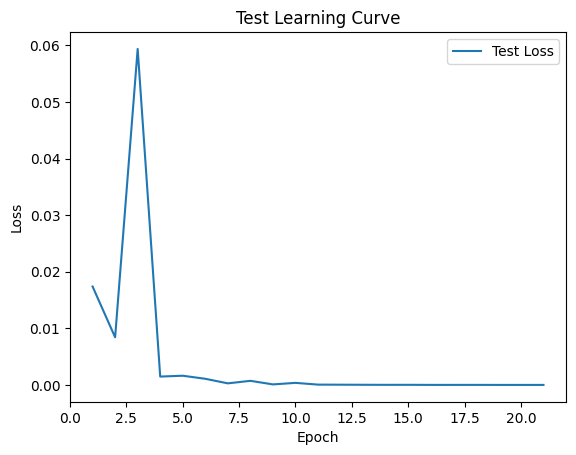


 Epoch: (22/50) Loss = 1.001572513814608e-06

 Epoch: (22/50) Loss_rmse = 0.001000785967335105

 Epoch: (22/50) R^2 = 0.998633086681366

 Epoch: (22/50) MAE = 0.0009008646011352539
Spearman correlation coefficient: SignificanceResult(statistic=0.997676981915362, pvalue=1.755372629847846e-111)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728972

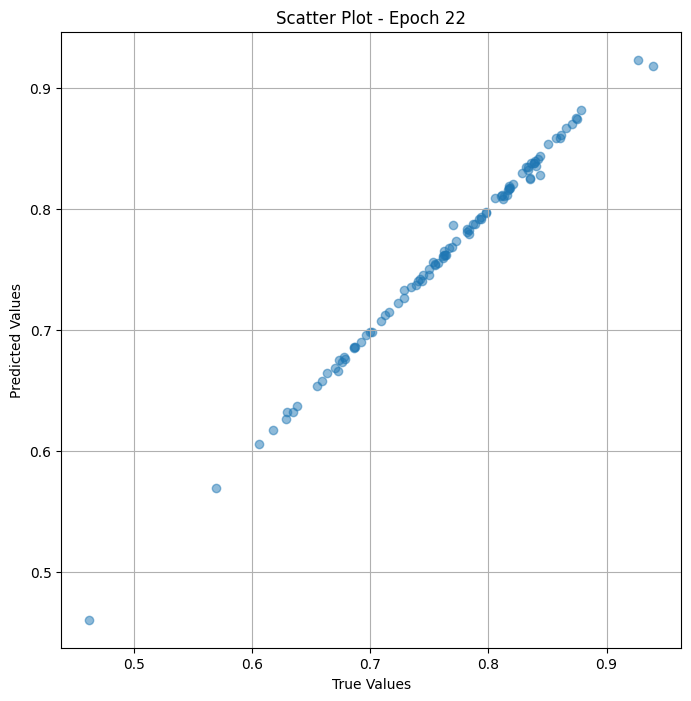

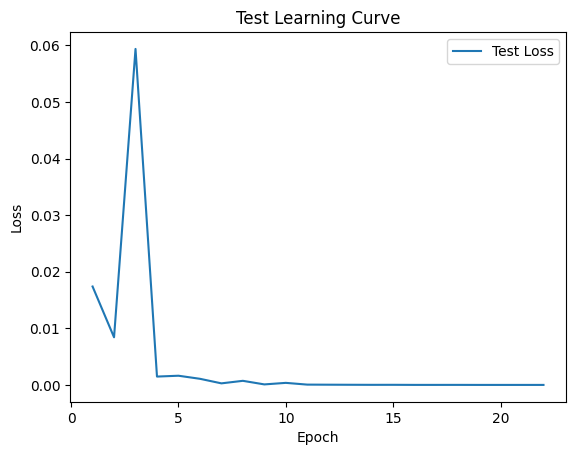

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-05.

 Epoch: (23/50) Loss = 2.2760759748052806e-06

 Epoch: (23/50) Loss_rmse = 0.0015086669009178877

 Epoch: (23/50) R^2 = 0.9968937039375305

 Epoch: (23/50) MAE = 0.001444980502128601
Spearman correlation coefficient: SignificanceResult(statistic=0.997805850079857, pvalue=1.2041355127476125e-112)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.783333

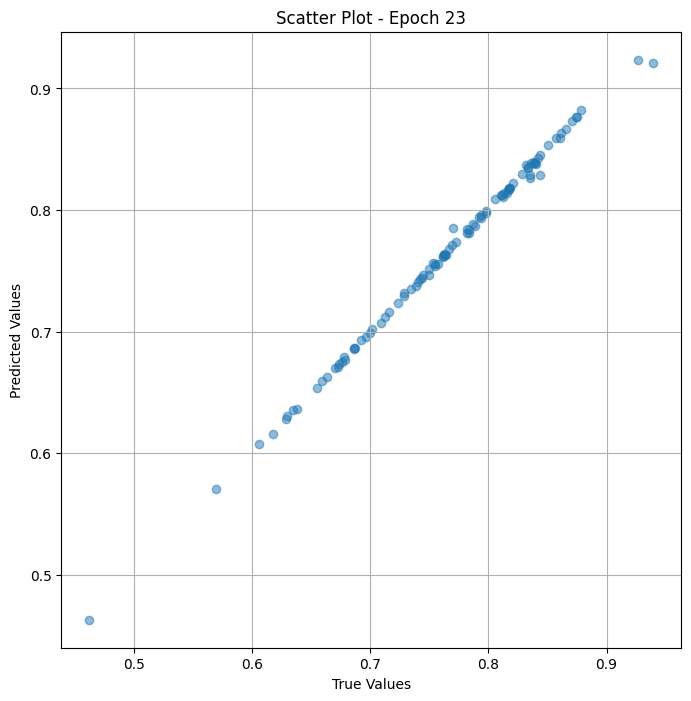

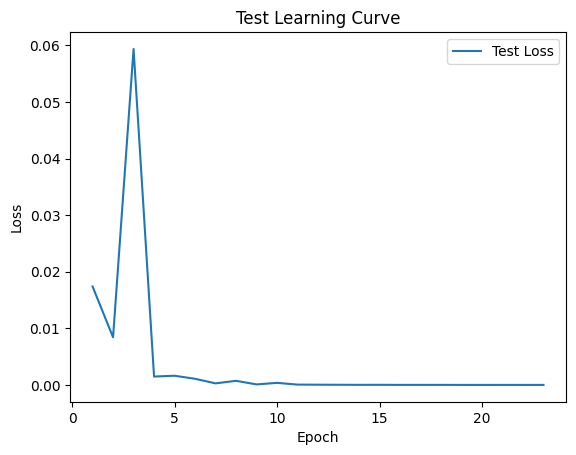


 Epoch: (24/50) Loss = 9.769446478458121e-07

 Epoch: (24/50) Loss_rmse = 0.0009884050814434886

 Epoch: (24/50) R^2 = 0.9986667037010193

 Epoch: (24/50) MAE = 0.0008692294359207153
Spearman correlation coefficient: SignificanceResult(statistic=0.9980500213389002, pvalue=4.7310032180379965e-115)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

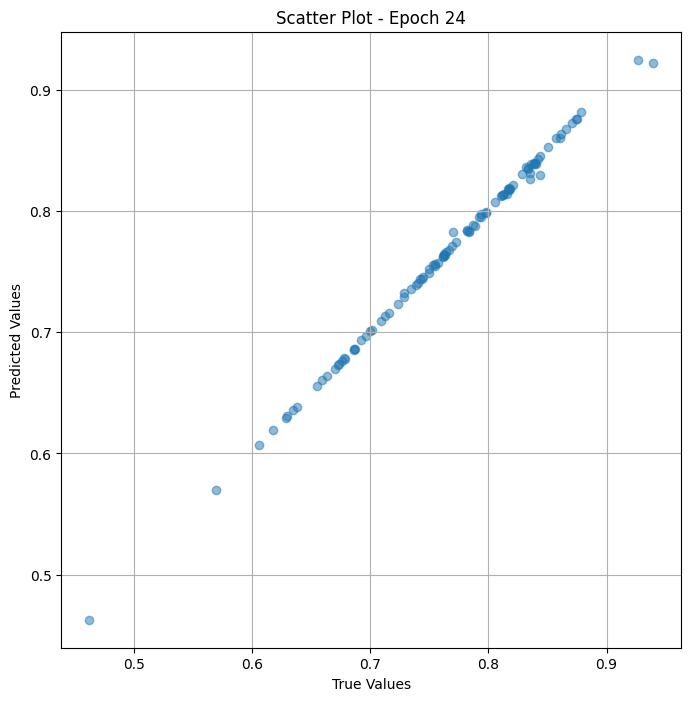

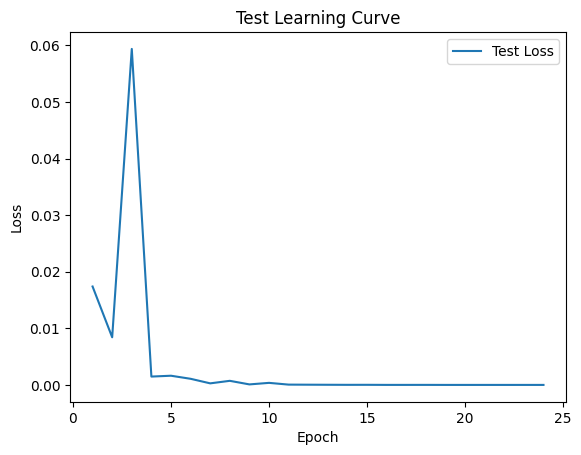


 Epoch: (25/50) Loss = 3.567534179182985e-07

 Epoch: (25/50) Loss_rmse = 0.000597288366407156

 Epoch: (25/50) R^2 = 0.9995130896568298

 Epoch: (25/50) MAE = 0.0004749000072479248
Spearman correlation coefficient: SignificanceResult(statistic=0.9980635864088471, pvalue=3.4087442584742554e-115)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728

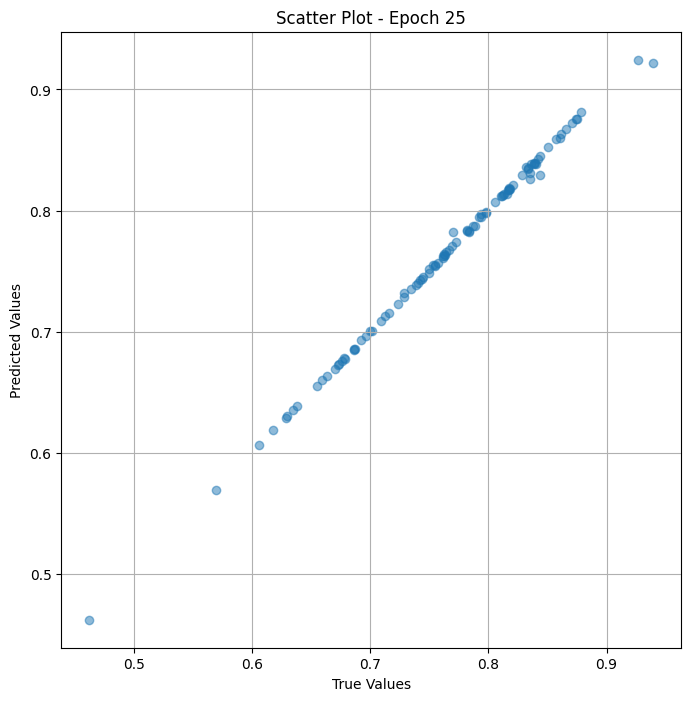

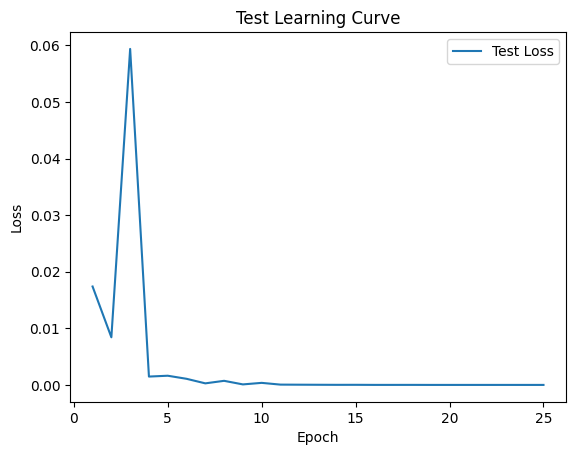


 Epoch: (26/50) Loss = 6.935452745437942e-08

 Epoch: (26/50) Loss_rmse = 0.0002633524709381163

 Epoch: (26/50) R^2 = 0.9999053478240967

 Epoch: (26/50) MAE = 0.00021095573902130127
Spearman correlation coefficient: SignificanceResult(statistic=0.9981246292236079, pvalue=7.574884939829974e-116)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

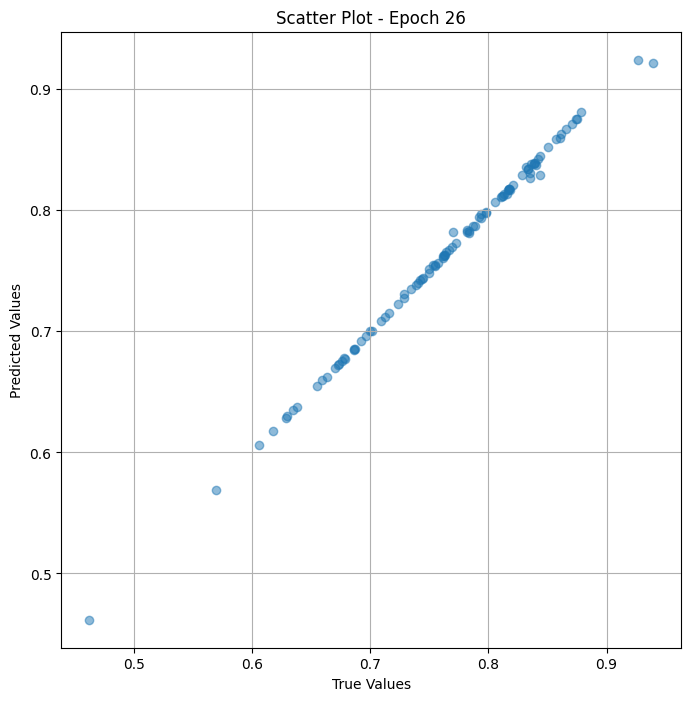

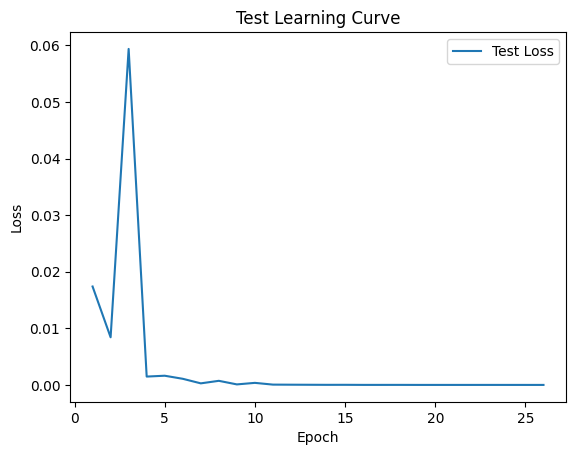


 Epoch: (27/50) Loss = 2.2323478177099787e-08

 Epoch: (27/50) Loss_rmse = 0.0001494104362791404

 Epoch: (27/50) R^2 = 0.9999695420265198

 Epoch: (27/50) MAE = 0.00011576712131500244
Spearman correlation coefficient: SignificanceResult(statistic=0.9982602799230763, pvalue=2.2291475437768832e-117)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6

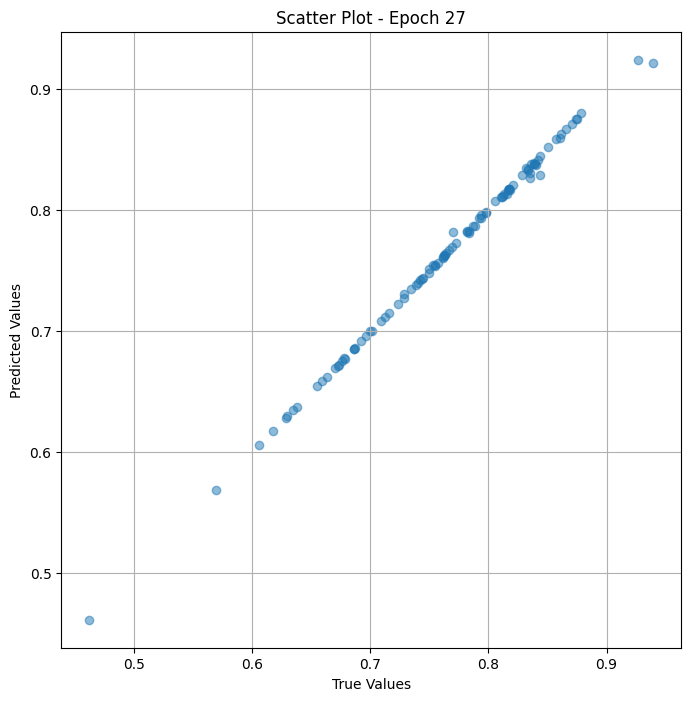

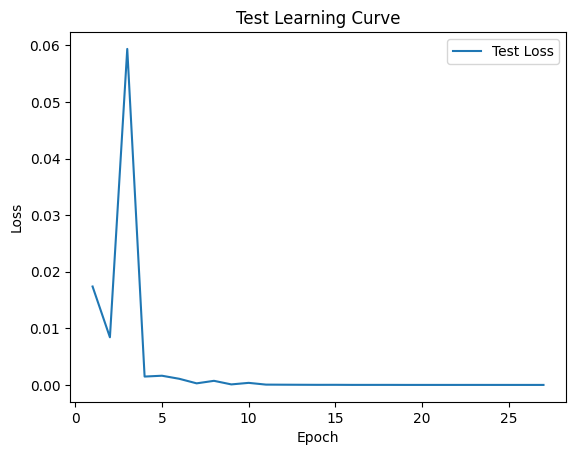


 Epoch: (28/50) Loss = 2.540013355201154e-08

 Epoch: (28/50) Loss_rmse = 0.0001593741908436641

 Epoch: (28/50) R^2 = 0.9999653100967407

 Epoch: (28/50) MAE = 0.00013987720012664795
Spearman correlation coefficient: SignificanceResult(statistic=0.9983552354127042, pvalue=1.5974002756242545e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67

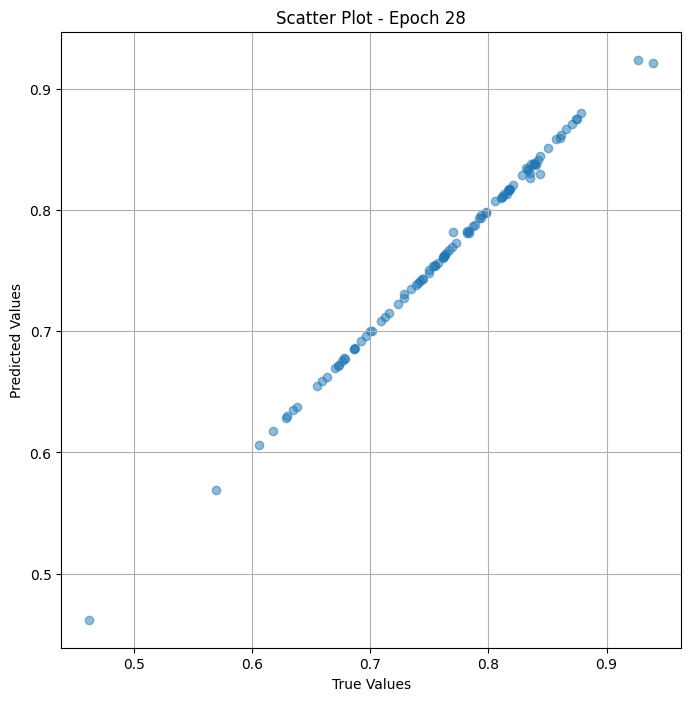

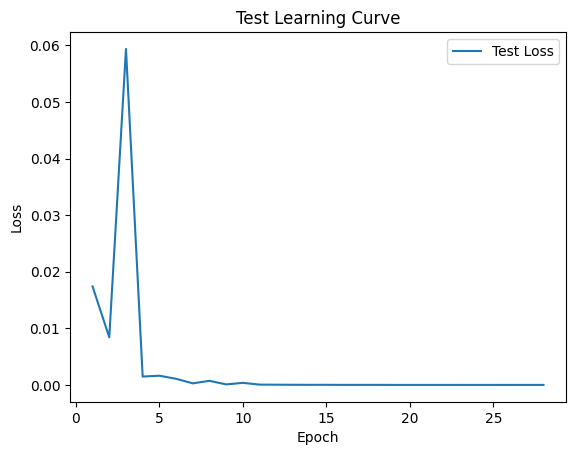


 Epoch: (29/50) Loss = 4.6806100328922184e-08

 Epoch: (29/50) Loss_rmse = 0.0002163471799576655

 Epoch: (29/50) R^2 = 0.9999361038208008

 Epoch: (29/50) MAE = 0.0001497715711593628
Spearman correlation coefficient: SignificanceResult(statistic=0.9983552354127042, pvalue=1.5974002756242545e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67

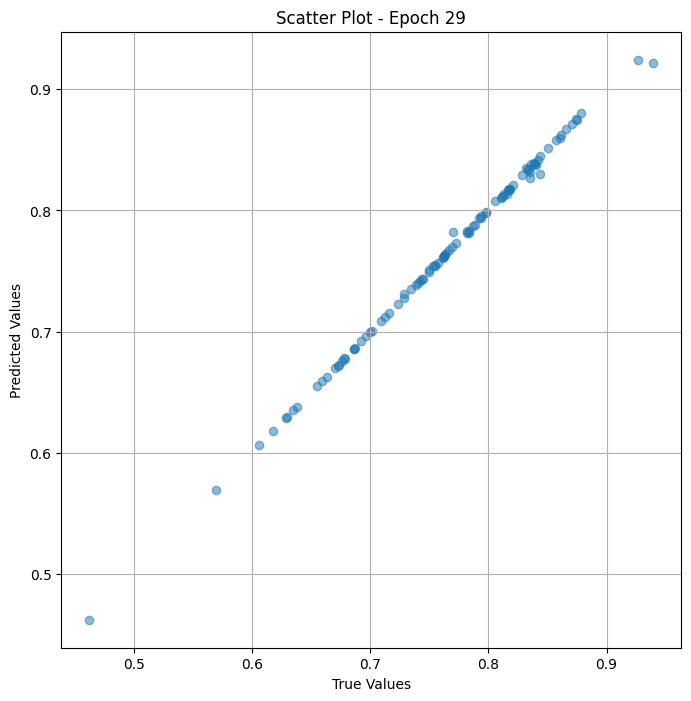

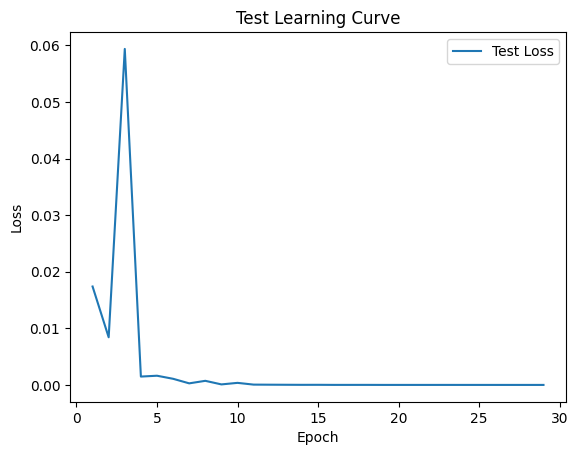

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-06.

 Epoch: (30/50) Loss = 8.589660183133674e-08

 Epoch: (30/50) Loss_rmse = 0.000293081218842417

 Epoch: (30/50) R^2 = 0.9998827576637268

 Epoch: (30/50) MAE = 0.0002002418041229248
Spearman correlation coefficient: SignificanceResult(statistic=0.9983552354127042, pvalue=1.5974002756242545e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.783333

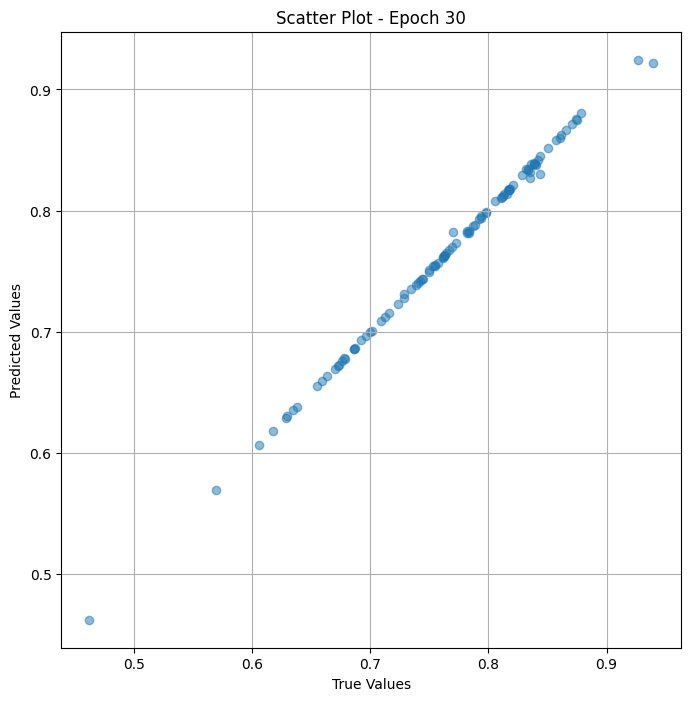

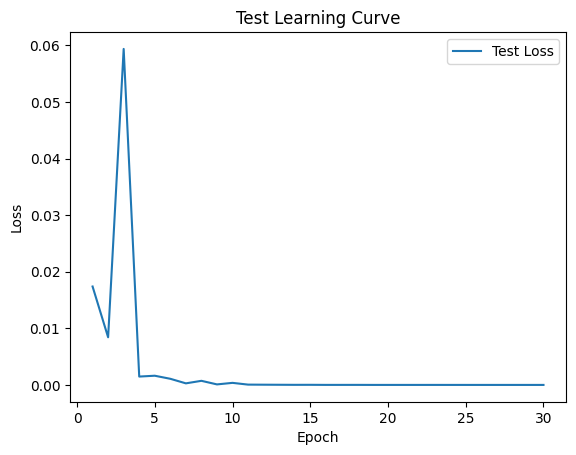


 Epoch: (31/50) Loss = 9.455629168542146e-08

 Epoch: (31/50) Loss_rmse = 0.00030750007135793567

 Epoch: (31/50) R^2 = 0.9998709559440613

 Epoch: (31/50) MAE = 0.00021351873874664307
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67

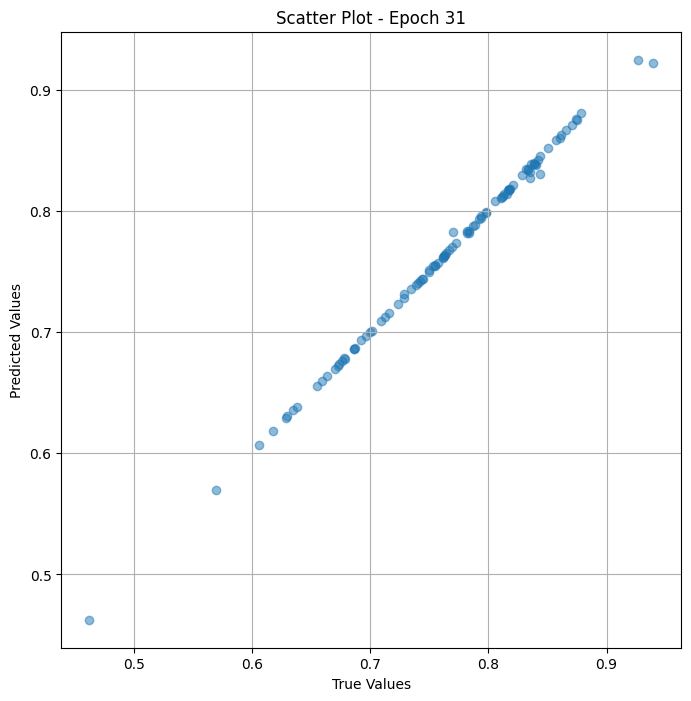

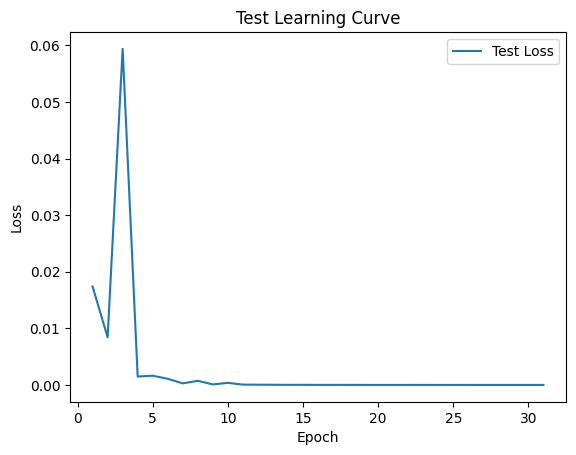


 Epoch: (32/50) Loss = 9.38681310458378e-08

 Epoch: (32/50) Loss_rmse = 0.0003063790500164032

 Epoch: (32/50) R^2 = 0.9998719096183777

 Epoch: (32/50) MAE = 0.00021272897720336914
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728

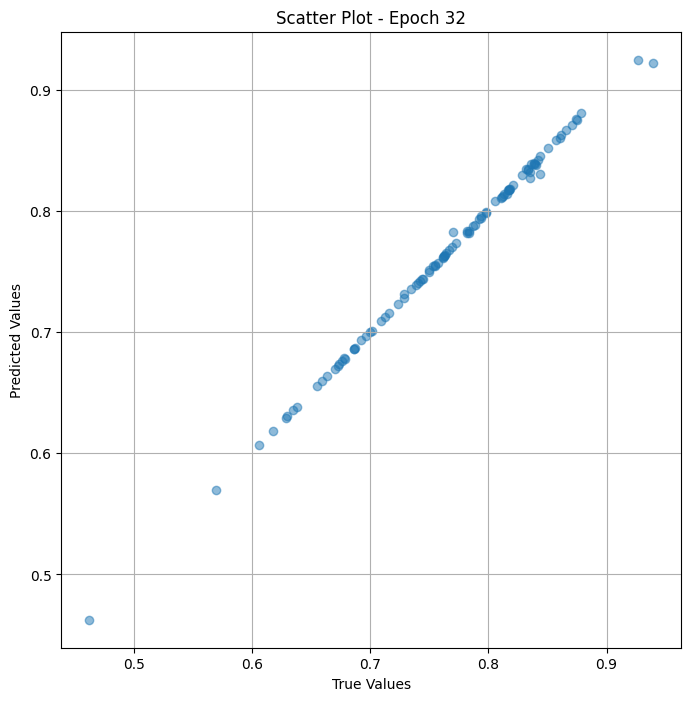

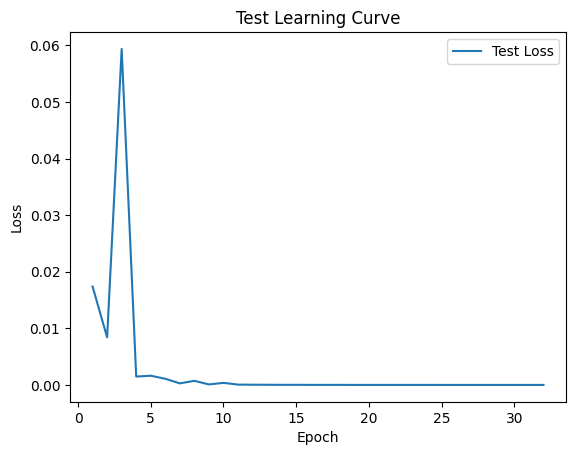

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-07.

 Epoch: (33/50) Loss = 9.1563705950648e-08

 Epoch: (33/50) Loss_rmse = 0.0003025949408765882

 Epoch: (33/50) R^2 = 0.999875009059906

 Epoch: (33/50) MAE = 0.00020888447761535645
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336

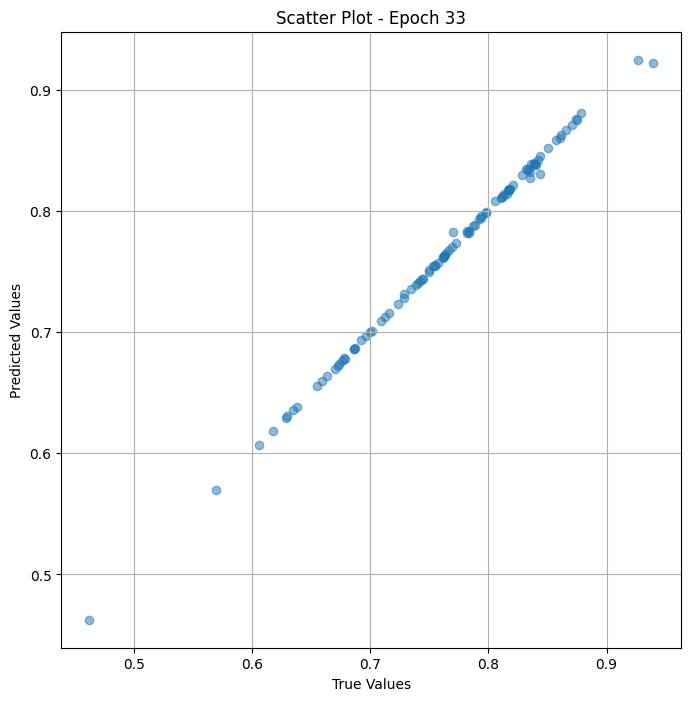

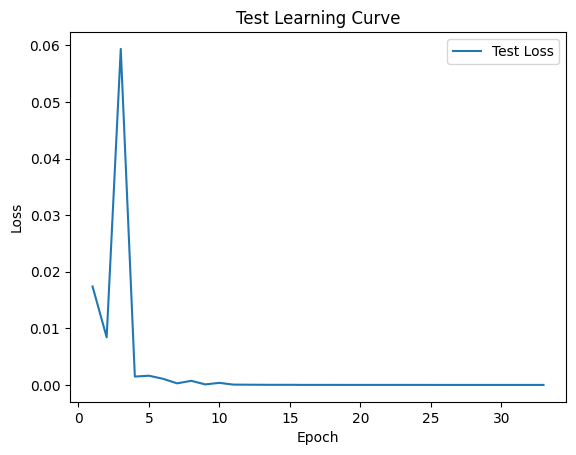


 Epoch: (34/50) Loss = 9.07433275187941e-08

 Epoch: (34/50) Loss_rmse = 0.00030123634496703744

 Epoch: (34/50) R^2 = 0.9998761415481567

 Epoch: (34/50) MAE = 0.00020760297775268555
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

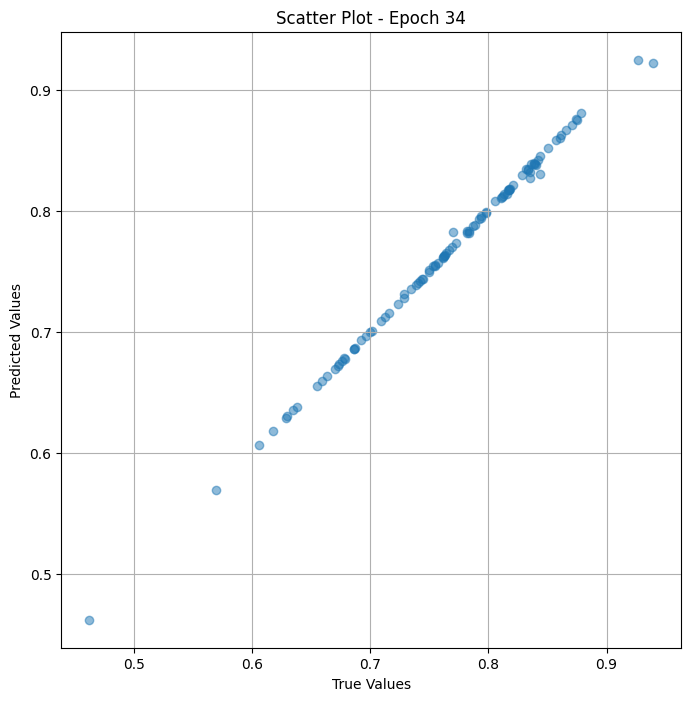

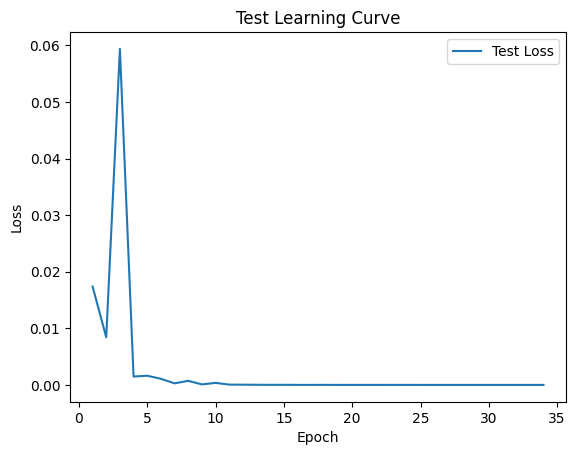


 Epoch: (35/50) Loss = 9.06262869193597e-08

 Epoch: (35/50) Loss_rmse = 0.00030104198958724737

 Epoch: (35/50) R^2 = 0.9998763203620911

 Epoch: (35/50) MAE = 0.00020742416381835938
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

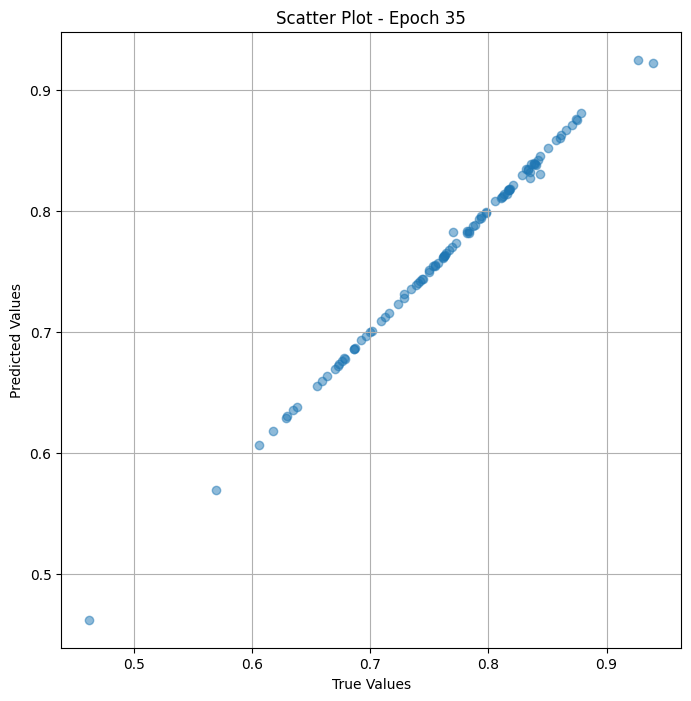

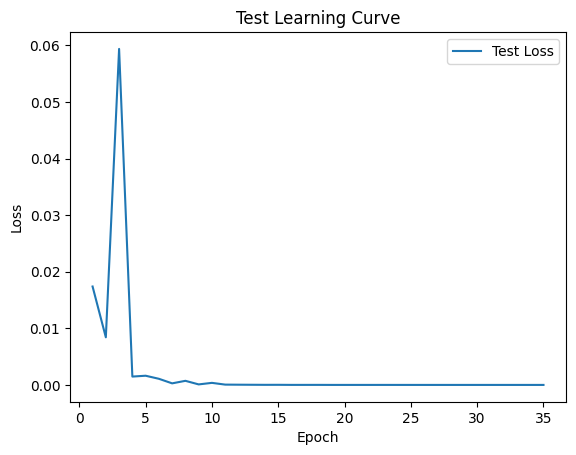

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-08.

 Epoch: (36/50) Loss = 9.053281502247046e-08

 Epoch: (36/50) Loss_rmse = 0.0003008867206517607

 Epoch: (36/50) R^2 = 0.9998764395713806

 Epoch: (36/50) MAE = 0.0002072453498840332
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.783333

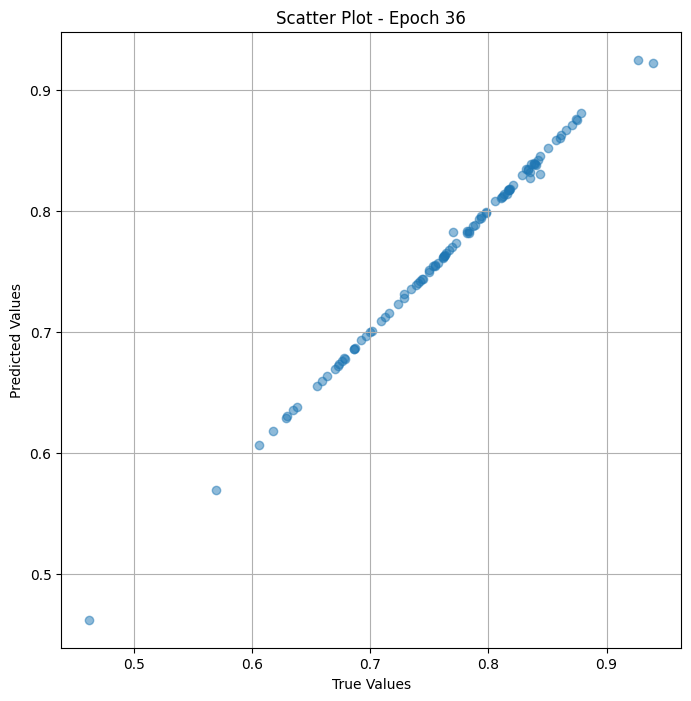

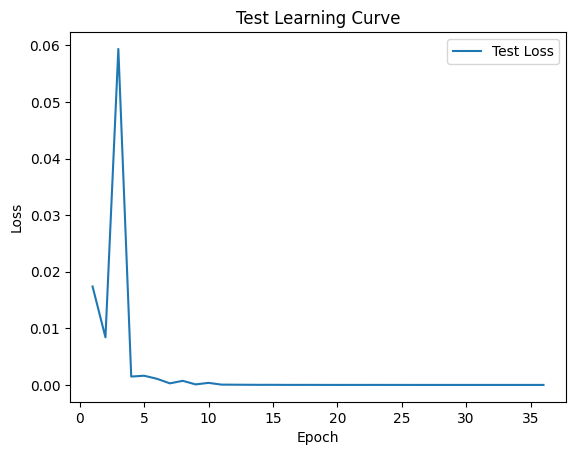


 Epoch: (37/50) Loss = 9.051242244595414e-08

 Epoch: (37/50) Loss_rmse = 0.0003008528146892786

 Epoch: (37/50) R^2 = 0.9998764991760254

 Epoch: (37/50) MAE = 0.0002072155475616455
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728

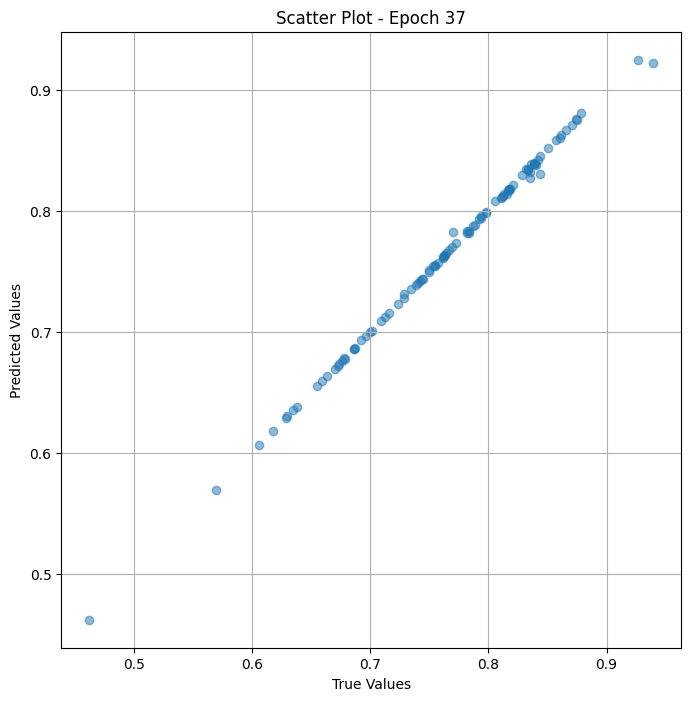

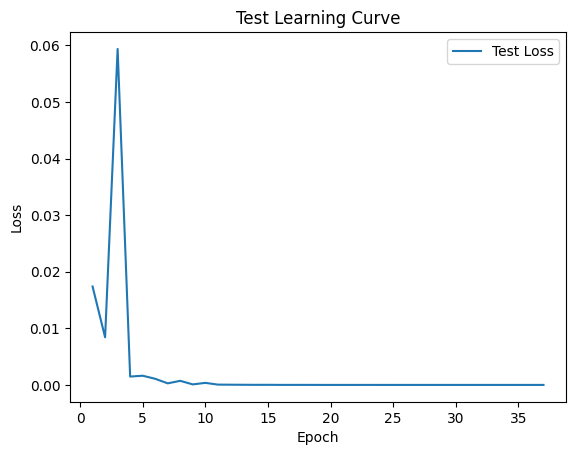


 Epoch: (38/50) Loss = 9.051242244595414e-08

 Epoch: (38/50) Loss_rmse = 0.0003008528146892786

 Epoch: (38/50) R^2 = 0.9998764991760254

 Epoch: (38/50) MAE = 0.0002072155475616455
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728

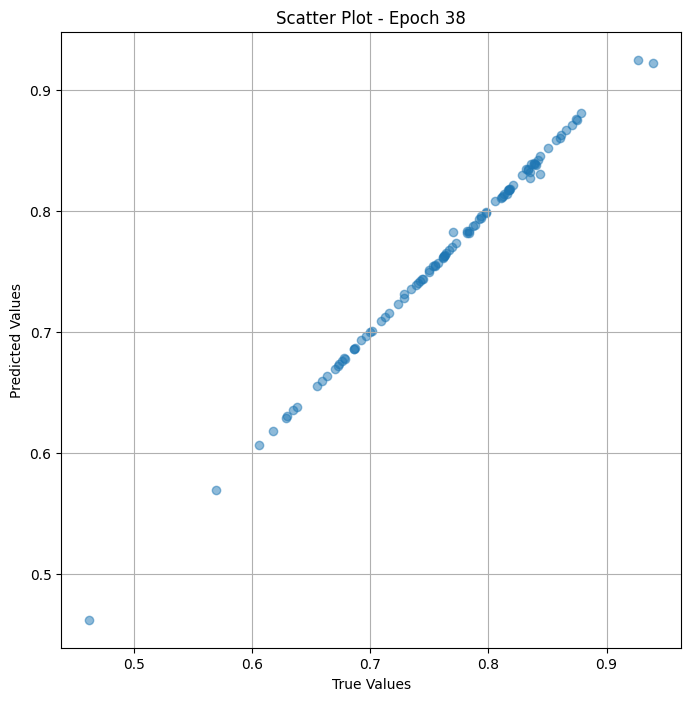

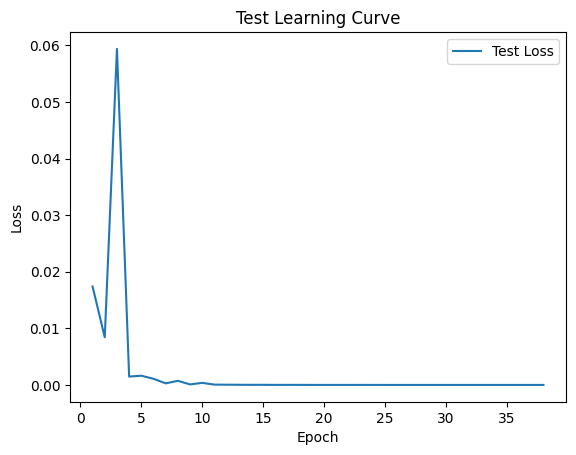


 Epoch: (39/50) Loss = 9.051570515339336e-08

 Epoch: (39/50) Loss_rmse = 0.00030085828620940447

 Epoch: (39/50) R^2 = 0.9998764395713806

 Epoch: (39/50) MAE = 0.00020723044872283936
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67

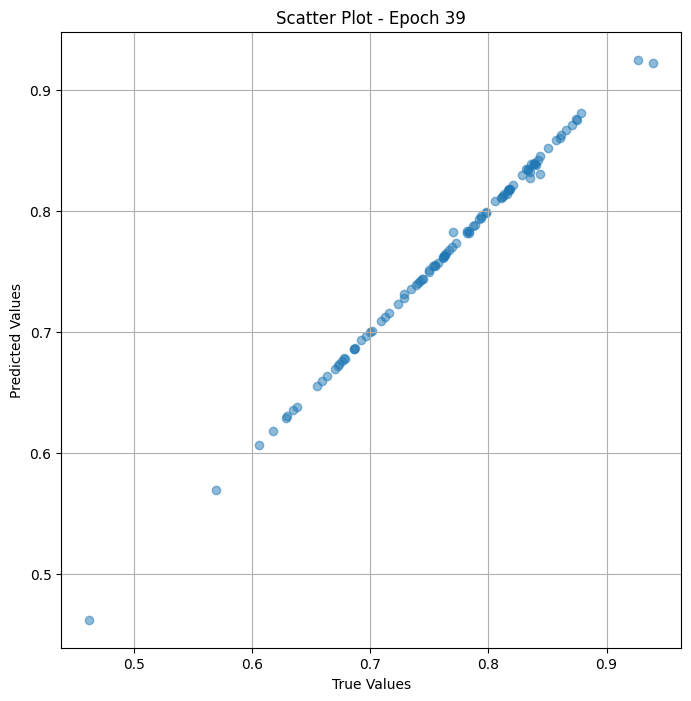

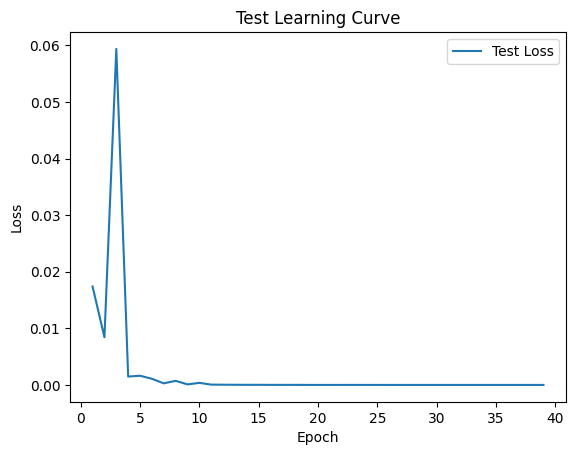


 Epoch: (40/50) Loss = 9.049859528431625e-08

 Epoch: (40/50) Loss_rmse = 0.00030082985176704824

 Epoch: (40/50) R^2 = 0.9998764991760254

 Epoch: (40/50) MAE = 0.0002072155475616455
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

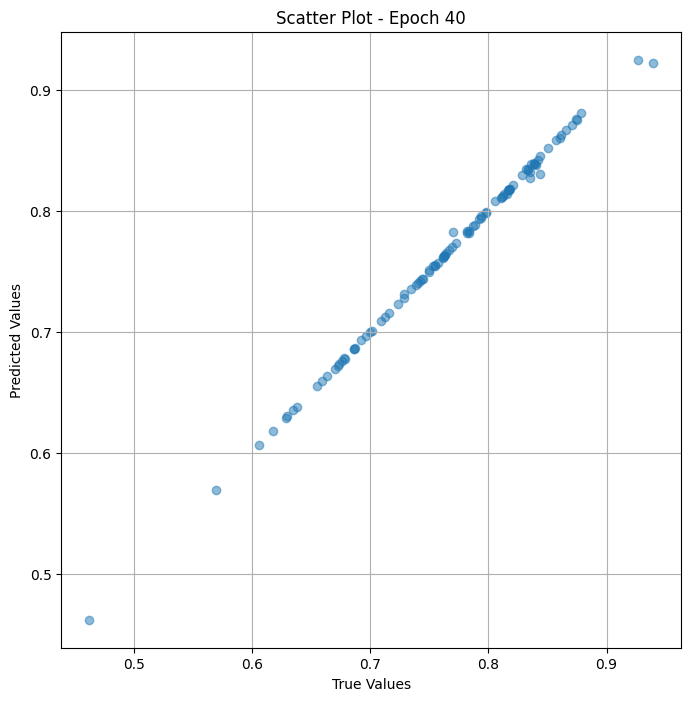

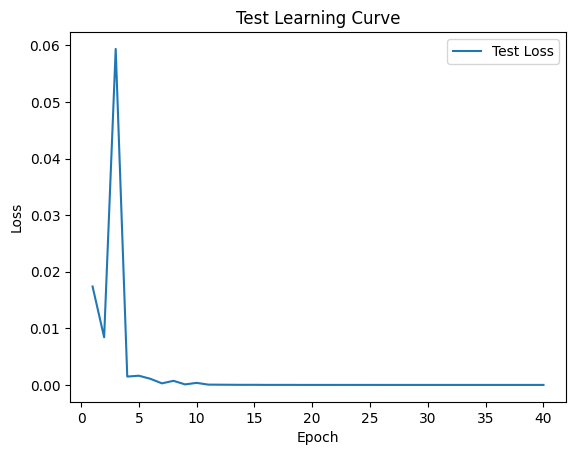


 Epoch: (41/50) Loss = 9.049531257687704e-08

 Epoch: (41/50) Loss_rmse = 0.0003008243802469224

 Epoch: (41/50) R^2 = 0.9998764991760254

 Epoch: (41/50) MAE = 0.00020720064640045166
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

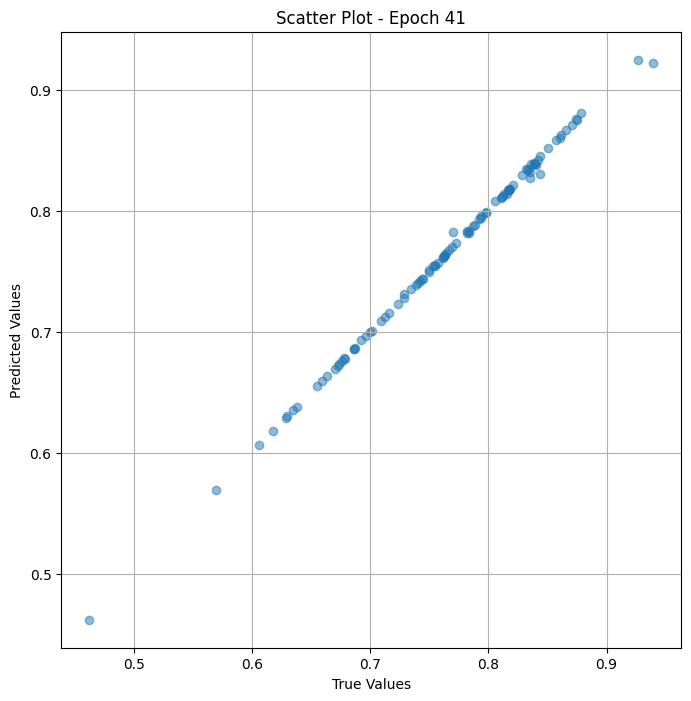

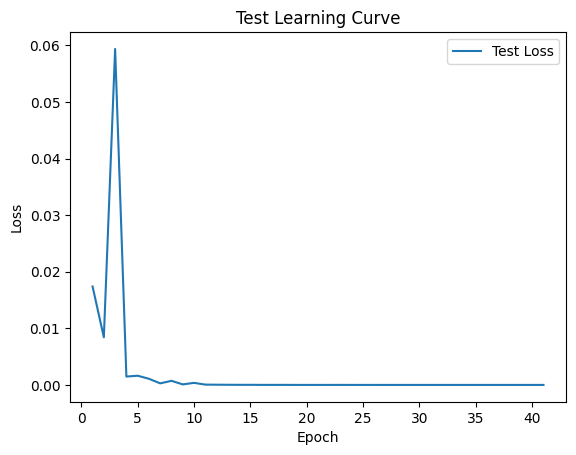


 Epoch: (42/50) Loss = 9.049436044961112e-08

 Epoch: (42/50) Loss_rmse = 0.0003008228086400777

 Epoch: (42/50) R^2 = 0.9998764991760254

 Epoch: (42/50) MAE = 0.00020720064640045166
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

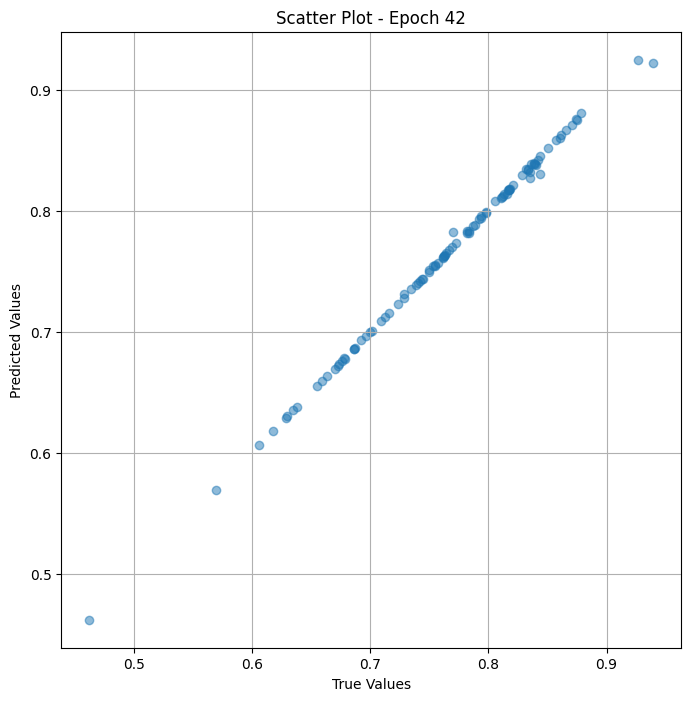

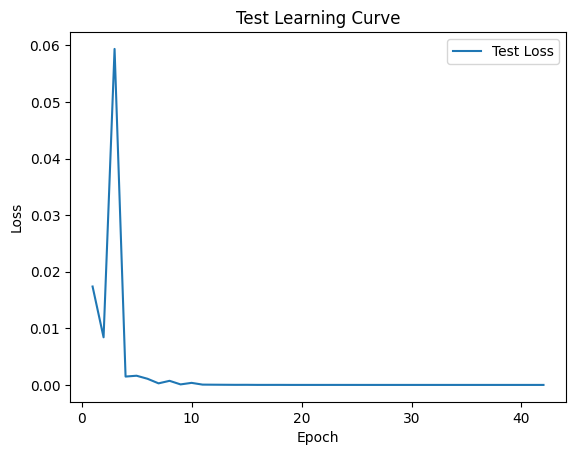


 Epoch: (43/50) Loss = 9.049531257687704e-08

 Epoch: (43/50) Loss_rmse = 0.0003008243802469224

 Epoch: (43/50) R^2 = 0.9998764991760254

 Epoch: (43/50) MAE = 0.00020720064640045166
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

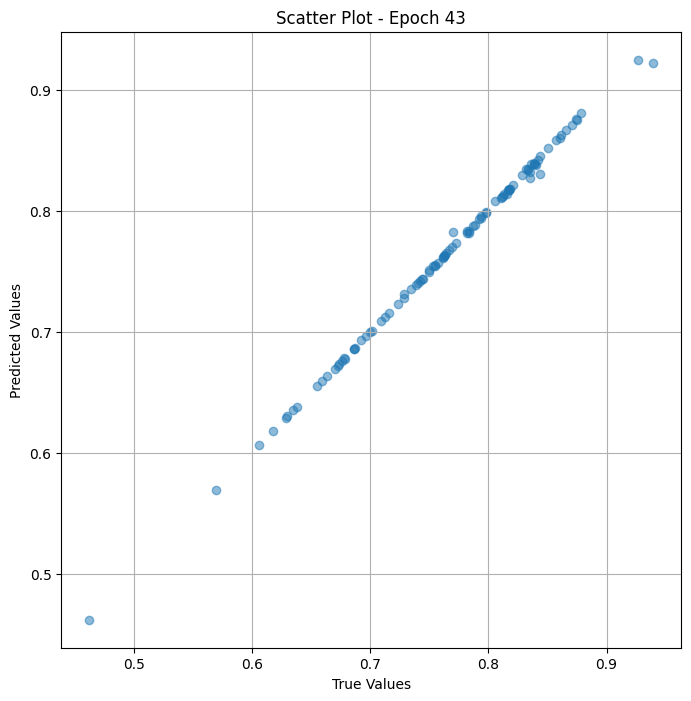

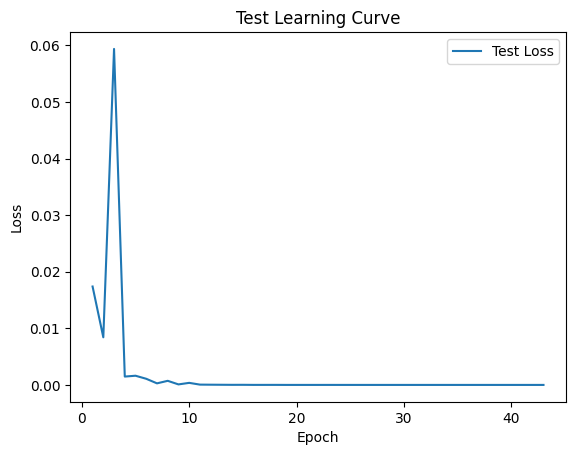


 Epoch: (44/50) Loss = 9.049859528431625e-08

 Epoch: (44/50) Loss_rmse = 0.00030082985176704824

 Epoch: (44/50) R^2 = 0.9998764991760254

 Epoch: (44/50) MAE = 0.0002072155475616455
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

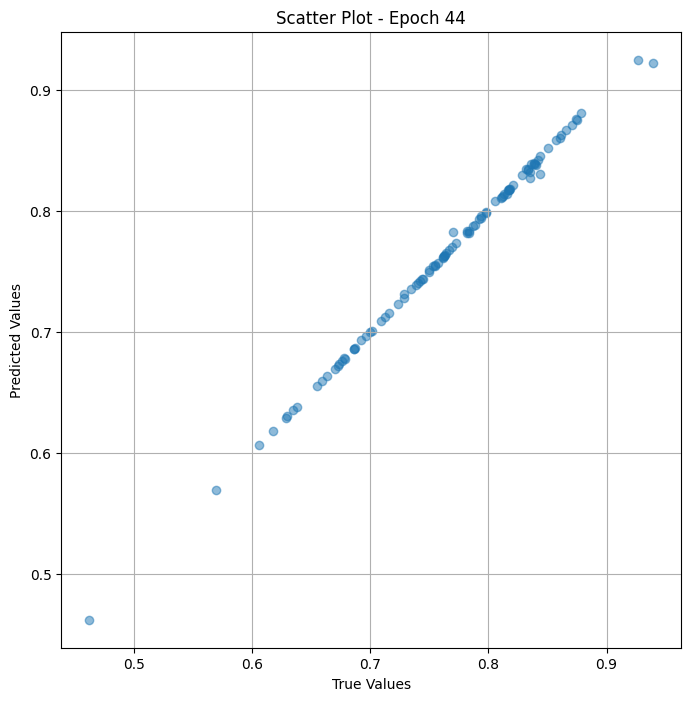

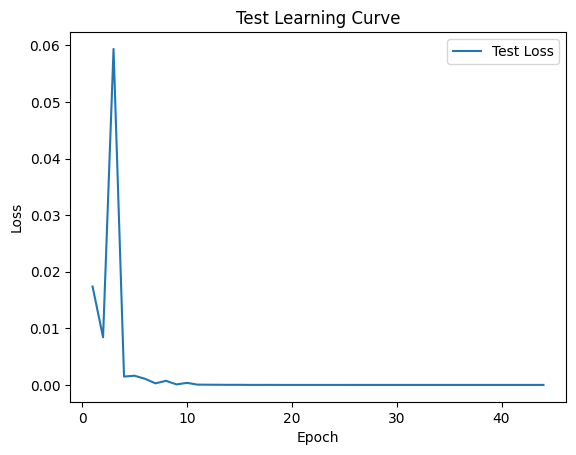


 Epoch: (45/50) Loss = 9.051570515339336e-08

 Epoch: (45/50) Loss_rmse = 0.00030085828620940447

 Epoch: (45/50) R^2 = 0.9998764395713806

 Epoch: (45/50) MAE = 0.00020723044872283936
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.67

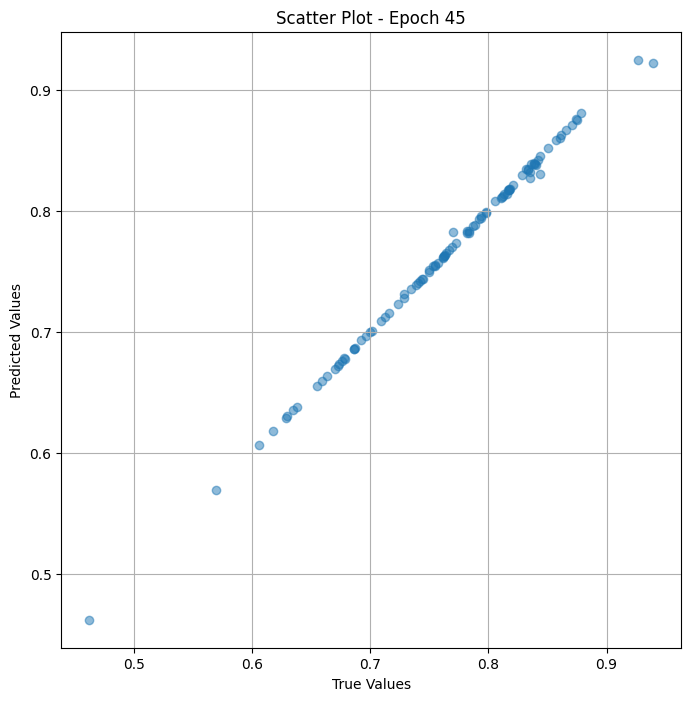

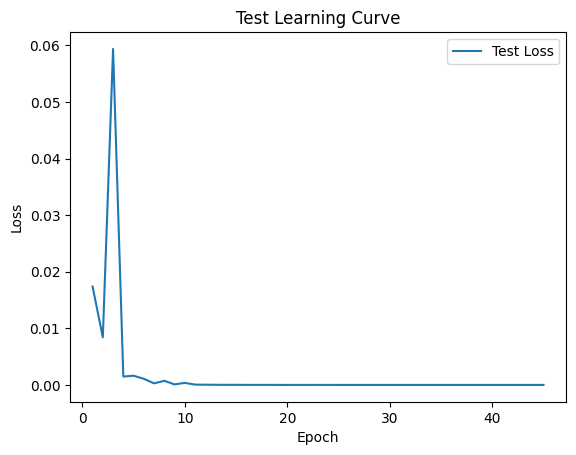


 Epoch: (46/50) Loss = 9.051242244595414e-08

 Epoch: (46/50) Loss_rmse = 0.0003008528146892786

 Epoch: (46/50) R^2 = 0.9998764991760254

 Epoch: (46/50) MAE = 0.0002072155475616455
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.6728

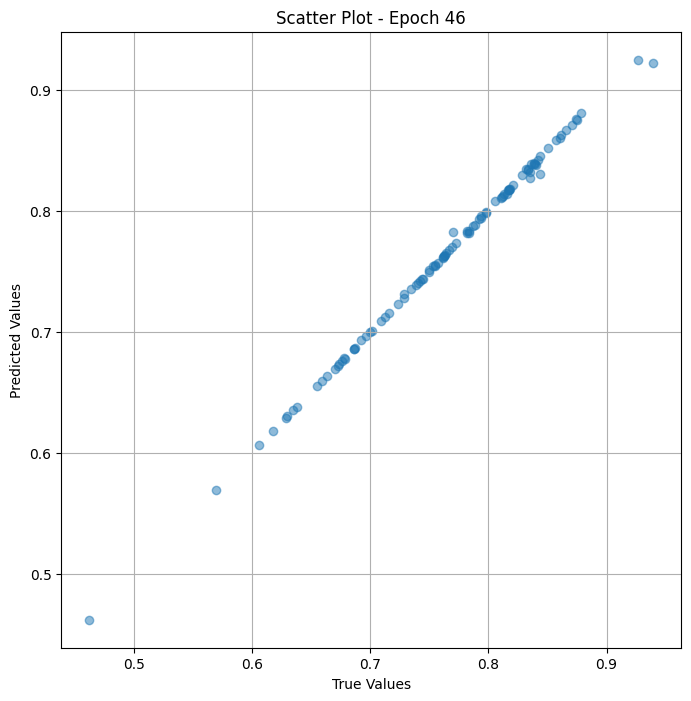

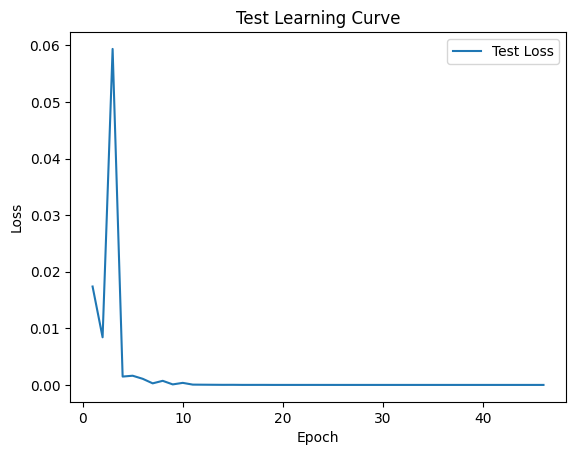


 Epoch: (47/50) Loss = 9.048874716199862e-08

 Epoch: (47/50) Loss_rmse = 0.0003008134663105011

 Epoch: (47/50) R^2 = 0.9998764991760254

 Epoch: (47/50) MAE = 0.00020717084407806396
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

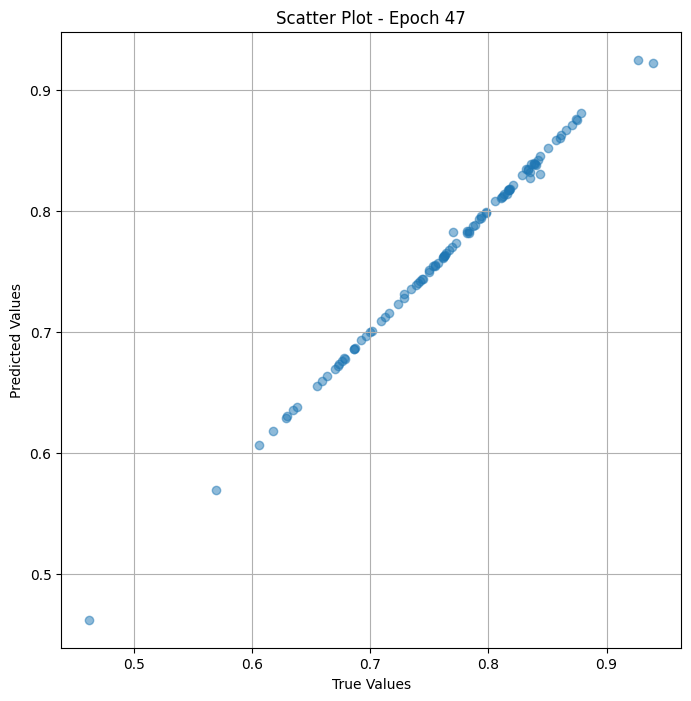

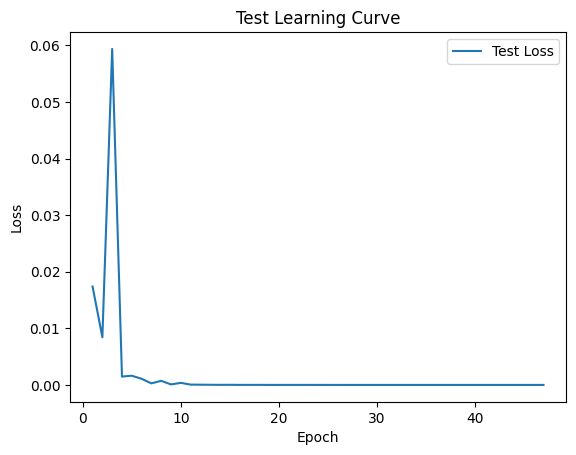


 Epoch: (48/50) Loss = 9.046109283872283e-08

 Epoch: (48/50) Loss_rmse = 0.0003007675113622099

 Epoch: (48/50) R^2 = 0.9998765587806702

 Epoch: (48/50) MAE = 0.00020717084407806396
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

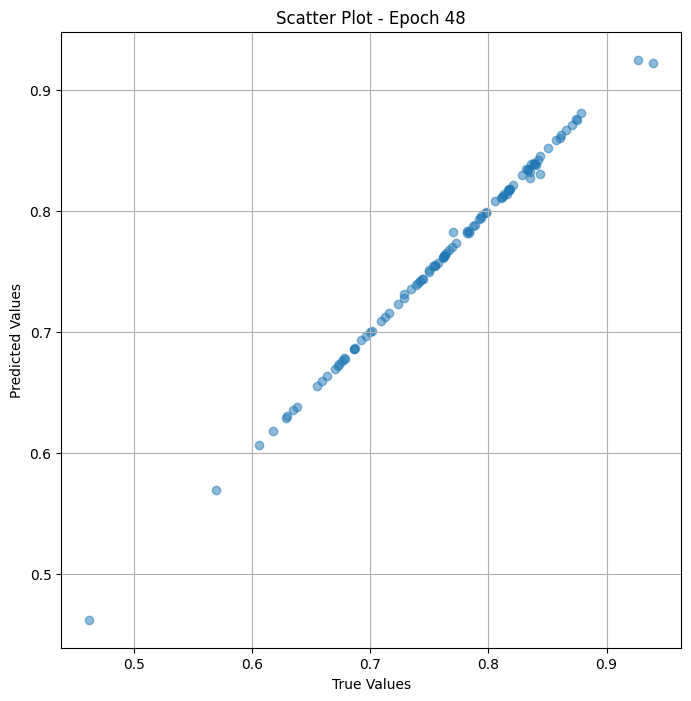

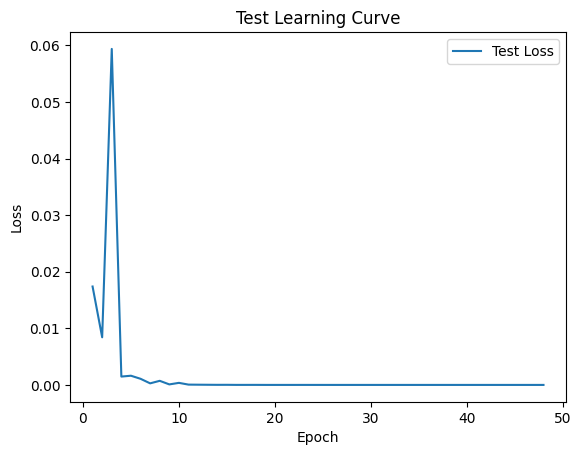


 Epoch: (49/50) Loss = 9.049531257687704e-08

 Epoch: (49/50) Loss_rmse = 0.0003008243802469224

 Epoch: (49/50) R^2 = 0.9998764991760254

 Epoch: (49/50) MAE = 0.00020720064640045166
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

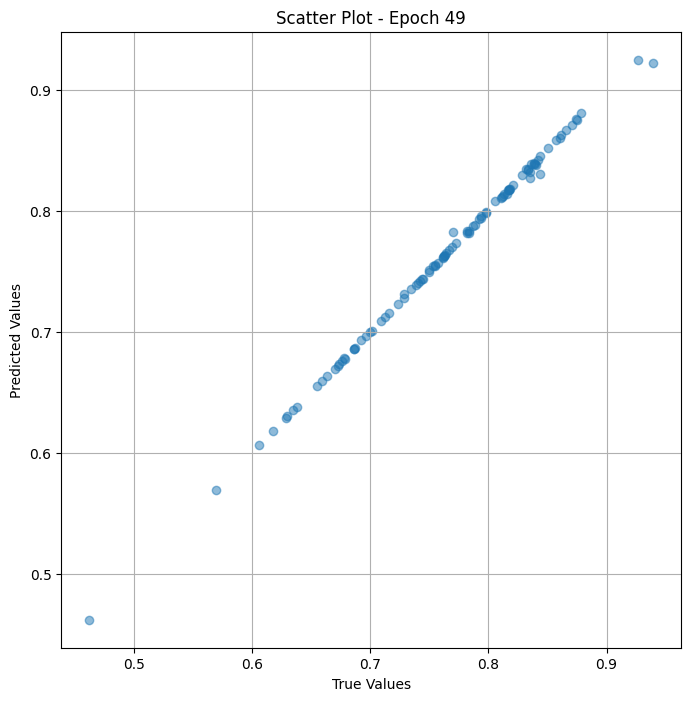

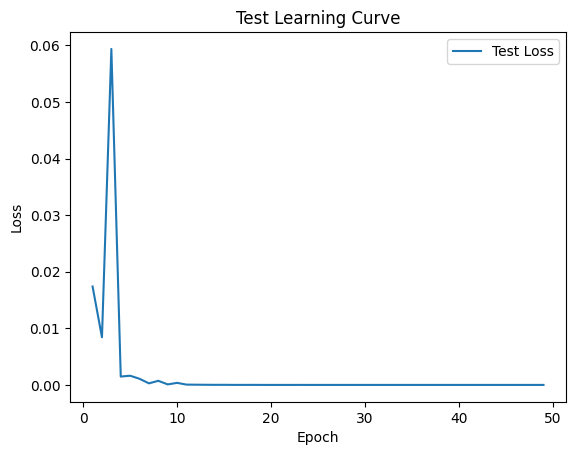


 Epoch: (50/50) Loss = 9.046109283872283e-08

 Epoch: (50/50) Loss_rmse = 0.0003007675113622099

 Epoch: (50/50) R^2 = 0.9998765587806702

 Epoch: (50/50) MAE = 0.00020717084407806396
Spearman correlation coefficient: SignificanceResult(statistic=0.998368800482651, pvalue=1.0826881797111457e-118)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.8173077, 0.7641509, 0.754717, 0.7, 0.8659794, 0.81632656, 0.8173077, 0.7345133, 0.7941176, 0.6635514, 0.6296296, 0.63793105, 0.9263158, 0.7282609, 0.83908045, 0.752809, 0.75757575, 0.7093023, 0.7821782, 0.86021507, 0.6962025, 0.83495146, 0.71276593, 0.8125, 0.7888889, 0.6551724, 0.79347825, 0.8117647, 0.76237625, 0.6732673, 0.82857144, 0.61764705, 0.84, 0.7619048, 0.85057473, 0.76666665, 0.8783784, 0.72380954, 0.65909094, 0.68604654, 0.77, 0.7387387, 0.8613861, 0.6785714, 0.83505154, 0.78723407, 0.75, 0.85714287, 0.77272725, 0.8363636, 0.78333336, 0.62886596, 0.7407407, 0.7818182, 0.75, 0.6756757, 0.672

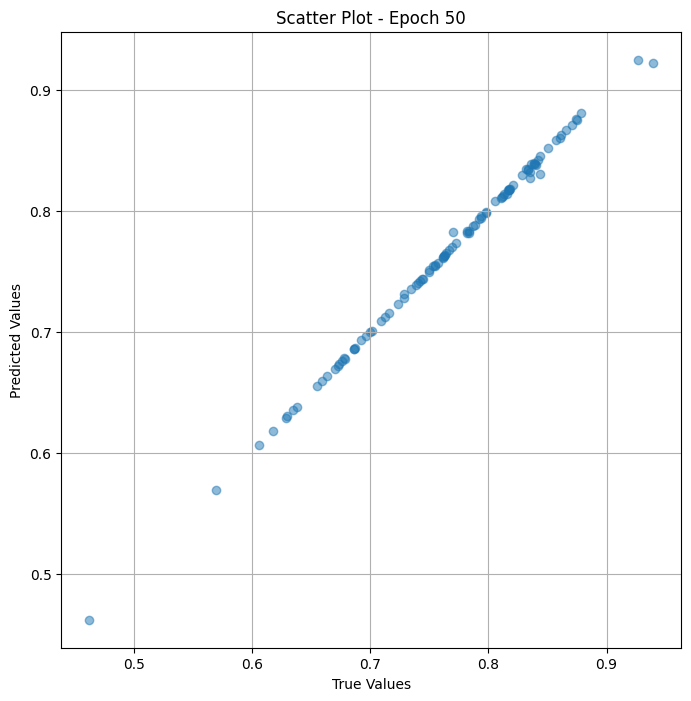

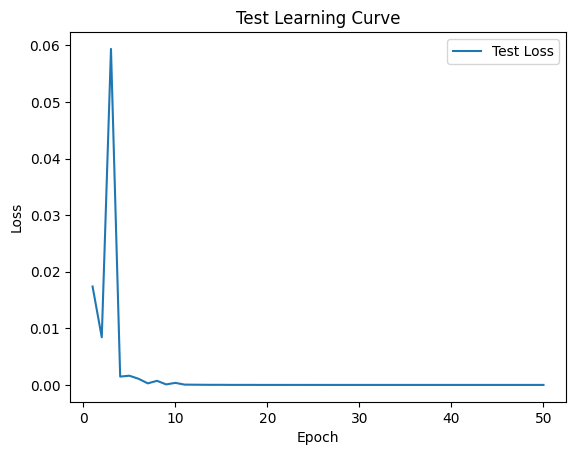

In [ ]:
# val the model and save weights
fit(50, model_vit_test , test_dl )
torch.save(model_vit_test.state_dict(), "model_weights_s")

In [ ]:
true_values_list_test = []
predicted_values_list_test = []

for x_trans, yb in test_dl:
    preds = model_vit(x_trans)
    true_values_list_test.extend(yb.cpu().detach().numpy())
    predicted_values_list_test.extend(preds.squeeze().cpu().detach().numpy())



# Assuming 'df_test_vehicle' is your original DataFrame and 'true_values' and 'predicted_values' are lists of true and predicted values
df_result = pd.DataFrame({
    'Image Path': df_test_vehicle['preprocessed_image_path'],
    'True Value': true_values_list_test,  # Replace with your actual true values
    'Predicted Value': predicted_values_list_test # Replace with your actual predicted values
})

# Display the resulting DataFrame
print(df_result)

                                           Image Path  True Value  \
0    /content/vehicle/n03791053_5855_preprocessed.jpg    0.817308   
1      /content/vehicle/000000406329_preprocessed.jpg    0.764151   
2   /content/vehicle/n04231693_18551_preprocessed.jpg    0.754717   
3   /content/vehicle/n04231693_19460_preprocessed.jpg    0.700000   
4      /content/vehicle/000000328185_preprocessed.jpg    0.865979   
..                                                ...         ...   
95  /content/vehicle/n03670208_12822_preprocessed.jpg    0.939394   
96   /content/vehicle/n03512147_1375_preprocessed.jpg    0.817204   
97   /content/vehicle/n04166281_4975_preprocessed.jpg    0.875000   
98  /content/vehicle/n03670208_42256_preprocessed.jpg    0.870968   
99   /content/vehicle/n04349306_4552_preprocessed.jpg    0.820755   

    Predicted Value  
0          0.819776  
1          0.652017  
2          0.643882  
3          0.626661  
4          0.678664  
..              ...  
95         0.8756

#Finetuning

##Train

In [ ]:
class Dataset_train_fine(Dataset):
    def __init__(self, df, trans_transform=None):
        self.labels = df_train_vehicle["memoscore"]
        self.images = df_train_vehicle["preprocessed_image_path"]
        self.trans_transform = trans_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)

        image_trans = self.trans_transform(image, return_tensors='pt')
        image_trans = image_trans['pixel_values'].squeeze()

        # แสดงขนาดรูปภาพหลังการ transform
        #print("Transformed image size:", image_trans.shape)

        label = self.labels[idx]

        return image_trans, label

# สร้างตัวแปรสำหรับ ViTFeatureExtractor
trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# สร้าง Dataset และ DataLoader
train_ds_fine = Dataset_train_fine(df_train_vehicle, trans_transform=trans_transform)
train_dl_fine = DataLoader(train_ds_fine, batch_size=16, shuffle=False)

# เรียกดูข้อมูลจาก DataLoader
'''for image_trans, label in train_dl:
    # คำสั่งนี้จะแสดงขนาดของรูปภาพที่ transform แล้วในแต่ละ batch
    print(image_trans)
    break'''


'for image_trans, label in train_dl:\n    # คำสั่งนี้จะแสดงขนาดของรูปภาพที่ transform แล้วในแต่ละ batch\n    print(image_trans)\n    break'

In [ ]:
class ViTMem_model_fine(torch.nn.Module):
    def __init__(self, arch="vit_base_patch16_224_miil"):
        super().__init__()
        self.arch = arch
        self.vit = timm.create_model(self.arch, pretrained=True, num_classes=1)
        self.trans_AdaptiveAvgPool = nn.AdaptiveAvgPool2d((1, None))


    def forward(self, x):
        vitfeat = self.vit(x)
        adap = self.trans_AdaptiveAvgPool(x)
        out = torch.sigmoid(vitfeat)
        return out



NORMALIZE_MEAN = (0.0, 0.0, 0.0)
NORMALIZE_STD = (1.0, 1.0, 1.0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

model_vit_fine =  ViTMem_model_fine( arch="vit_base_patch16_224_miil")

In [ ]:
# Add data and model to GPU
device = get_default_device()
train_dl_fine = DeviceDataLoader(train_dl_fine, device)
model_vit_fine  = to_device(model_vit_fine  , device)

In [ ]:
params = [param for param in list(model_vit_fine.parameters()) if param.requires_grad == True ]
optimizer = torch.optim.Adam(params, lr=1e-5 ,weight_decay=1e-7)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit_fine, train_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit_fine.train()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in train_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit_fine(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)

In [ ]:
# Training the model and save weights
fit(50,model_vit_fine , train_dl)
torch.save(model_vit_fine.state_dict(), "model_weights_fine")

## valid

In [ ]:
params = [param for param in list(model_vit_sval.parameters()) if param.requires_grad == True]
optimizer = torch.optim.Adam(params, lr=1e-5,weight_decay=1e-7)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit_sval, val_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit_sval.train()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in val_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit_sval(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)


 Epoch: (1/30) Loss = 0.00026032733148895204

 Epoch: (1/30) Loss_rmse = 0.016134662553668022

 Epoch: (1/30) R^2 = 0.9497317671775818

 Epoch: (1/30) MAE = 0.010555803775787354
Spearman correlation coefficient: SignificanceResult(statistic=0.7933638781330382, pvalue=5.613490894613532e-22)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335

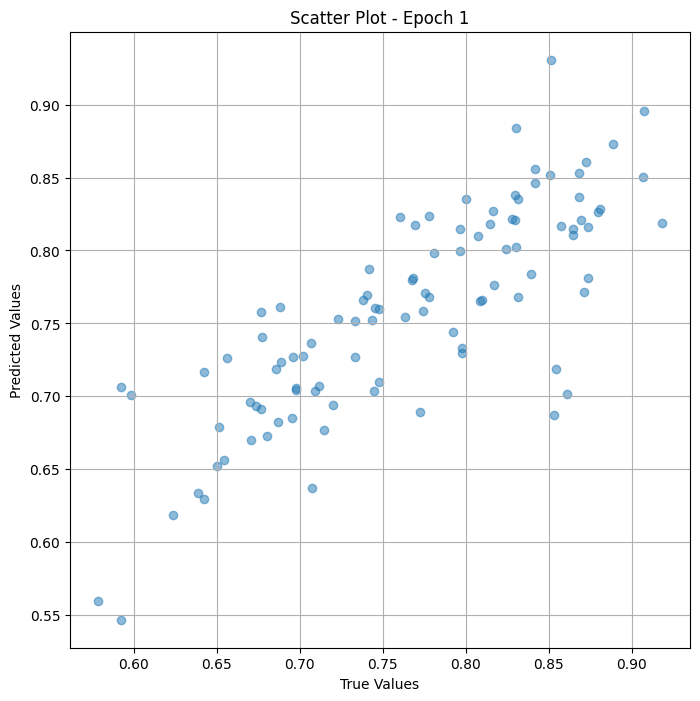

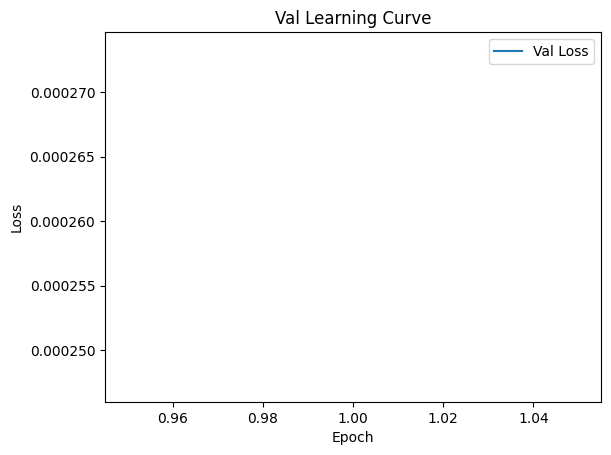


 Epoch: (2/30) Loss = 0.0015957728028297424

 Epoch: (2/30) Loss_rmse = 0.03994712606072426

 Epoch: (2/30) R^2 = 0.6918623447418213

 Epoch: (2/30) MAE = 0.02794758975505829
Spearman correlation coefficient: SignificanceResult(statistic=0.8461530639371712, pvalue=1.962246148434122e-27)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335, 0

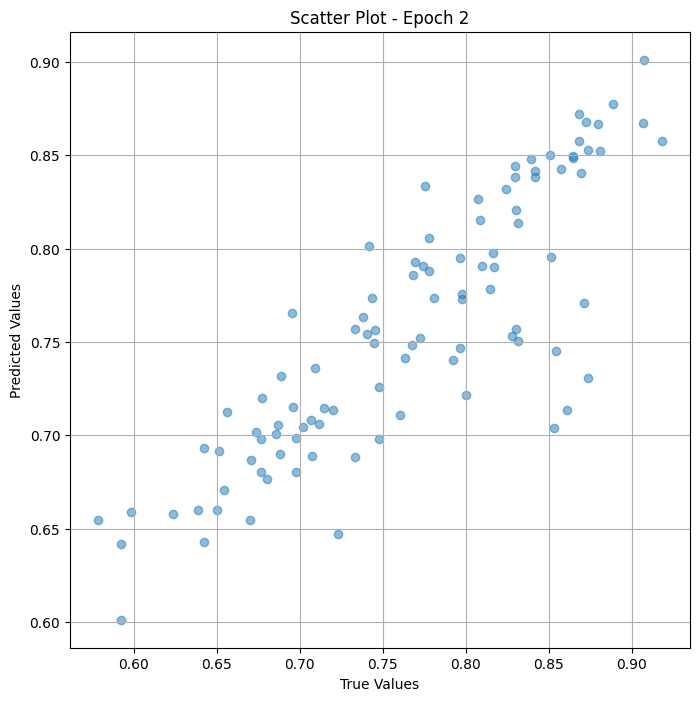

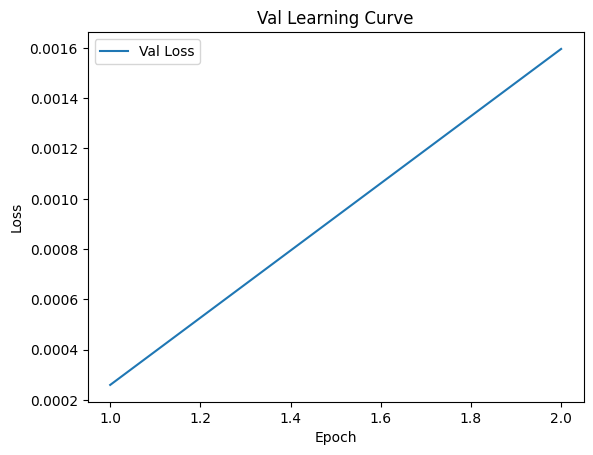


 Epoch: (3/30) Loss = 0.0002353306335862726

 Epoch: (3/30) Loss_rmse = 0.015340490266680717

 Epoch: (3/30) R^2 = 0.9545585513114929

 Epoch: (3/30) MAE = 0.011062264442443848
Spearman correlation coefficient: SignificanceResult(statistic=0.8809547229839406, pvalue=2.643782665650168e-32)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335,

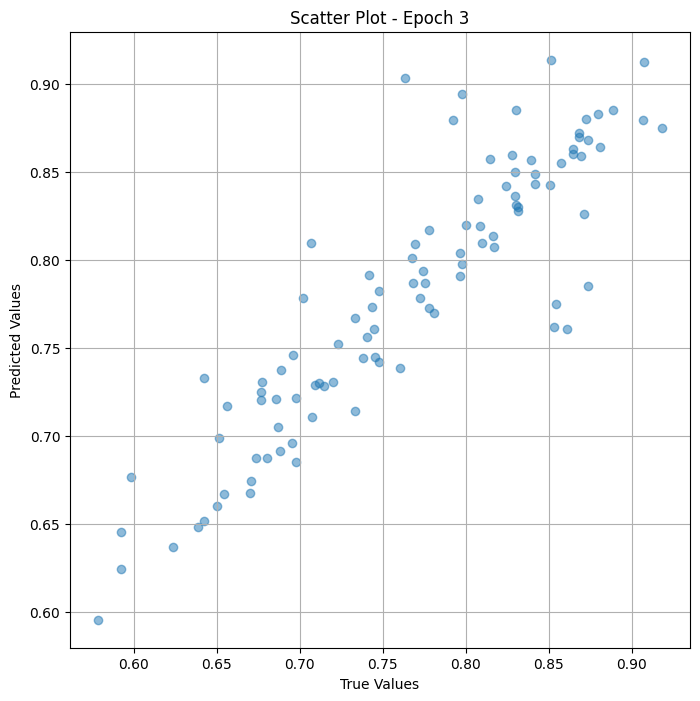

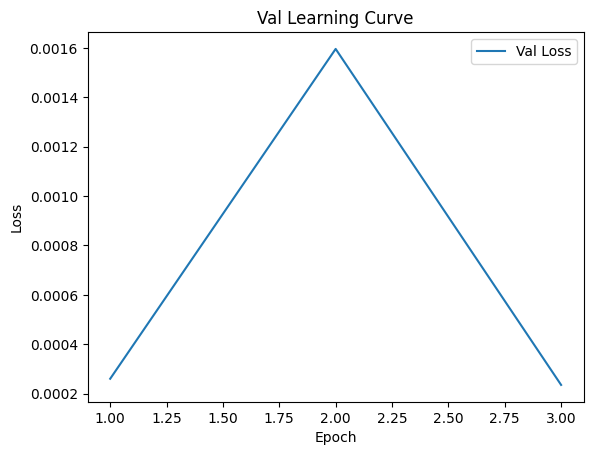


 Epoch: (4/30) Loss = 0.000497351516969502

 Epoch: (4/30) Loss_rmse = 0.022301379591226578

 Epoch: (4/30) R^2 = 0.9039633274078369

 Epoch: (4/30) MAE = 0.01672986149787903
Spearman correlation coefficient: SignificanceResult(statistic=0.9209722221801868, pvalue=2.953307924763734e-40)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335, 0

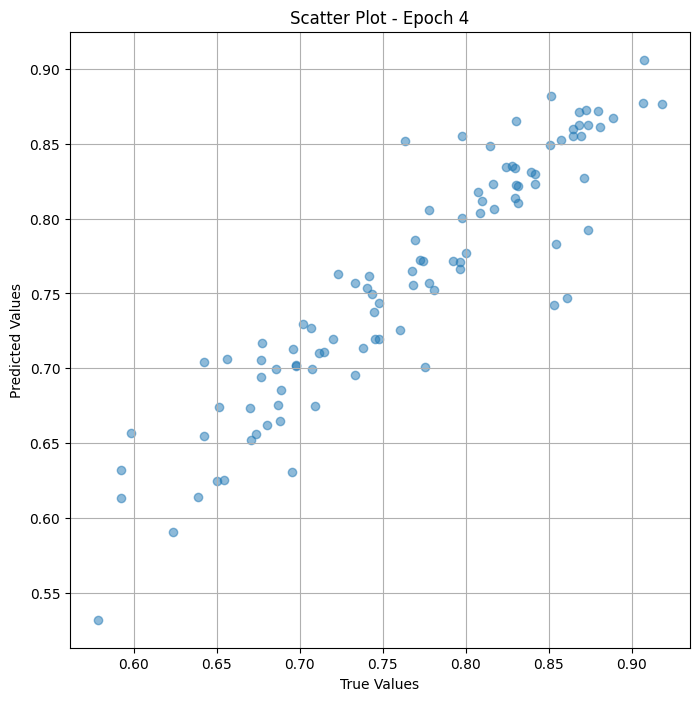

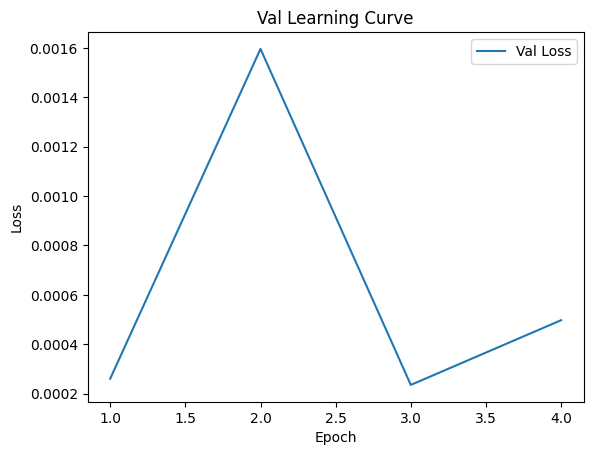


 Epoch: (5/30) Loss = 0.0002748699625954032

 Epoch: (5/30) Loss_rmse = 0.01657920330762863

 Epoch: (5/30) R^2 = 0.9469236731529236

 Epoch: (5/30) MAE = 0.016516417264938354
Spearman correlation coefficient: SignificanceResult(statistic=0.9451794178804248, pvalue=1.7767404694012276e-47)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335,

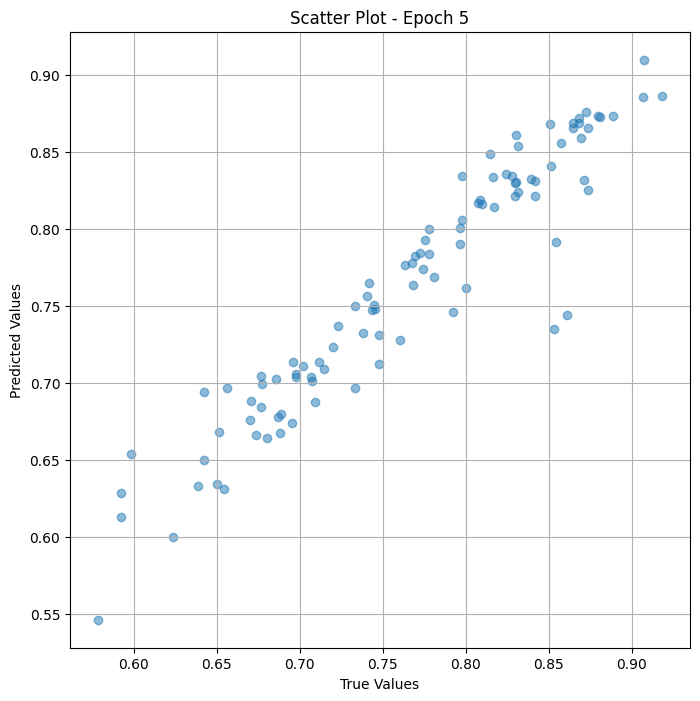

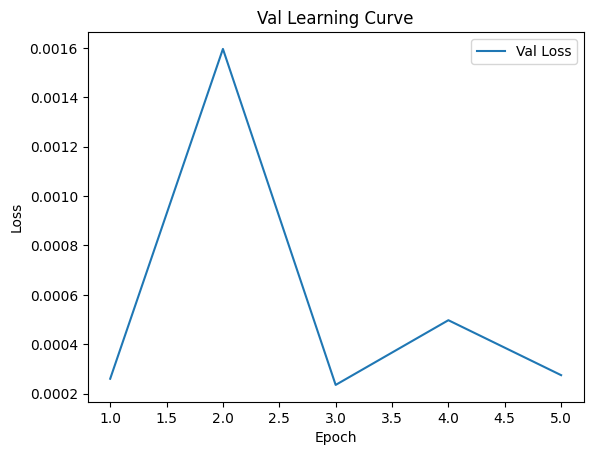

Epoch 0.02: reducing learning rate of group 0 to 1.0000e-06.

 Epoch: (6/30) Loss = 0.0003096861473750323

 Epoch: (6/30) Loss_rmse = 0.017597902566194534

 Epoch: (6/30) R^2 = 0.9402008056640625

 Epoch: (6/30) MAE = 0.012278243899345398
Spearman correlation coefficient: SignificanceResult(statistic=0.9562215346077958, pvalue=5.876688048655904e-52)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.807

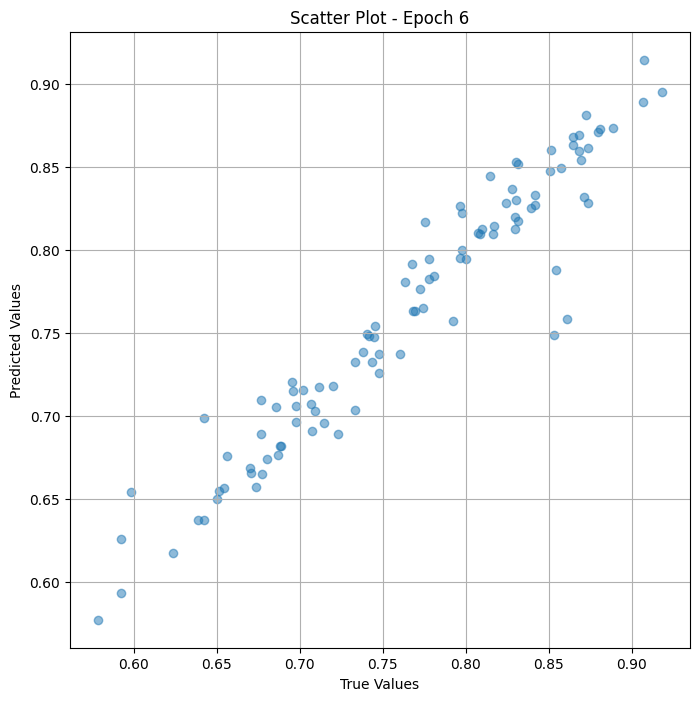

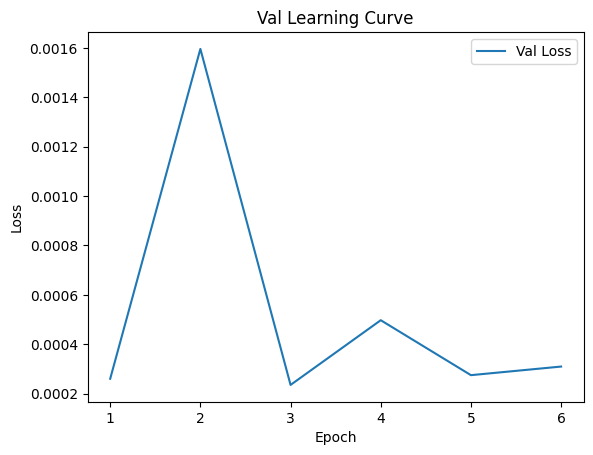


 Epoch: (7/30) Loss = 0.00013734745152760297

 Epoch: (7/30) Loss_rmse = 0.011719533242285252

 Epoch: (7/30) R^2 = 0.9734787344932556

 Epoch: (7/30) MAE = 0.007459864020347595
Spearman correlation coefficient: SignificanceResult(statistic=0.965486603065774, pvalue=1.0178003280709789e-56)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335

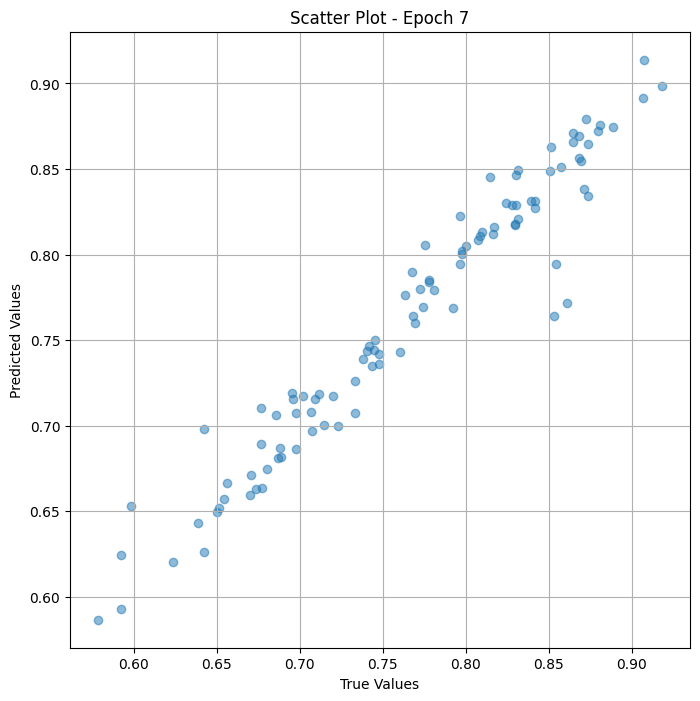

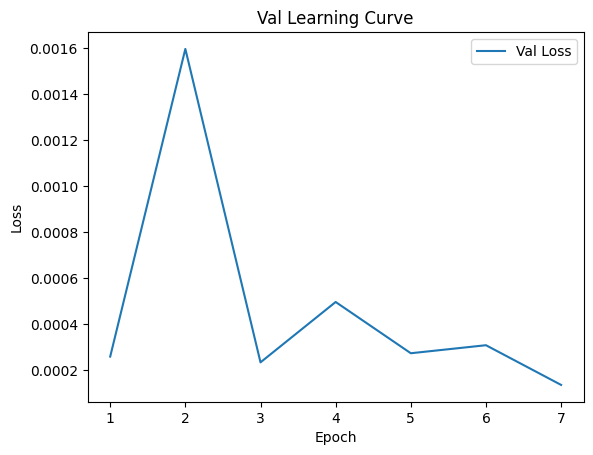


 Epoch: (8/30) Loss = 7.28317754692398e-05

 Epoch: (8/30) Loss_rmse = 0.008534153923392296

 Epoch: (8/30) R^2 = 0.9859364628791809

 Epoch: (8/30) MAE = 0.005706310272216797
Spearman correlation coefficient: SignificanceResult(statistic=0.9665039971131362, pvalue=2.552857155965572e-57)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333335, 

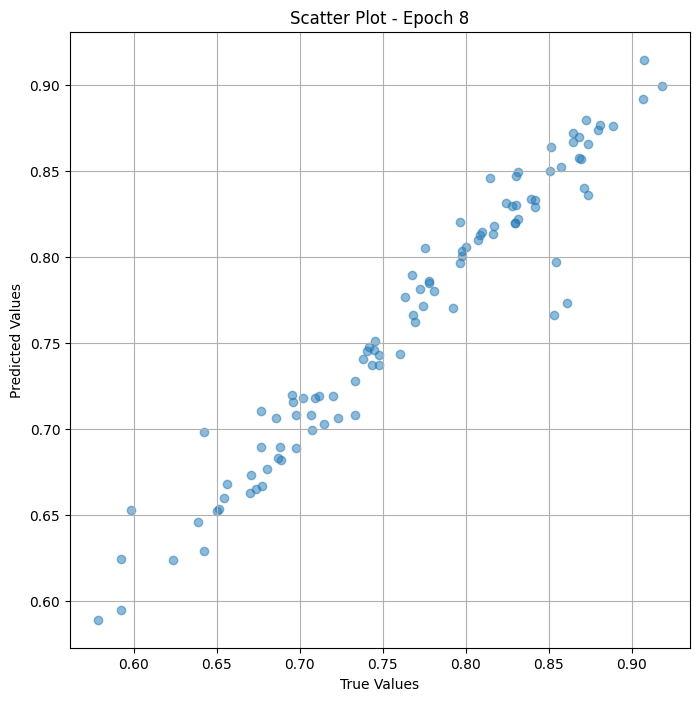

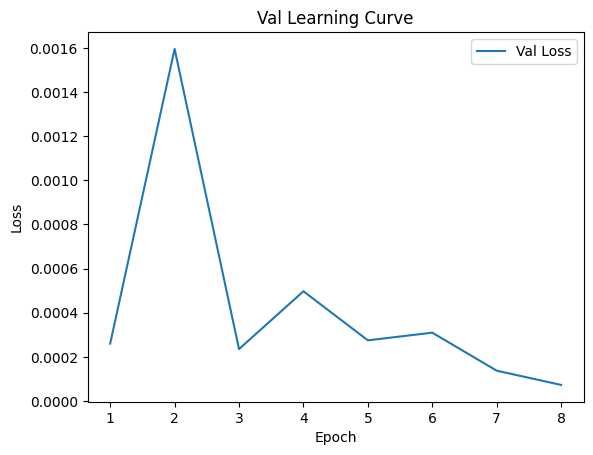


 Epoch: (9/30) Loss = 2.8523125365609303e-05

 Epoch: (9/30) Loss_rmse = 0.005340704694390297

 Epoch: (9/30) R^2 = 0.9944922924041748

 Epoch: (9/30) MAE = 0.0037810057401657104
Spearman correlation coefficient: SignificanceResult(statistic=0.9679147835254786, pvalue=3.489064003211099e-58)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333333

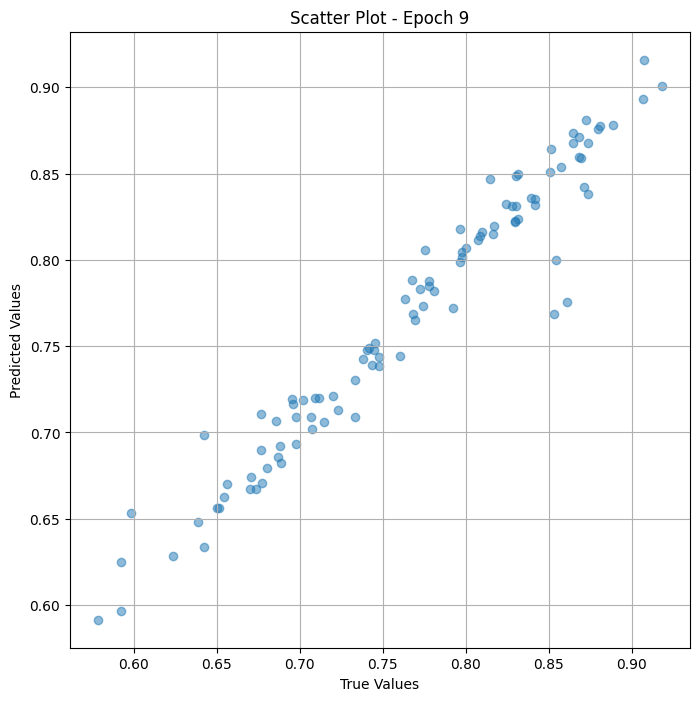

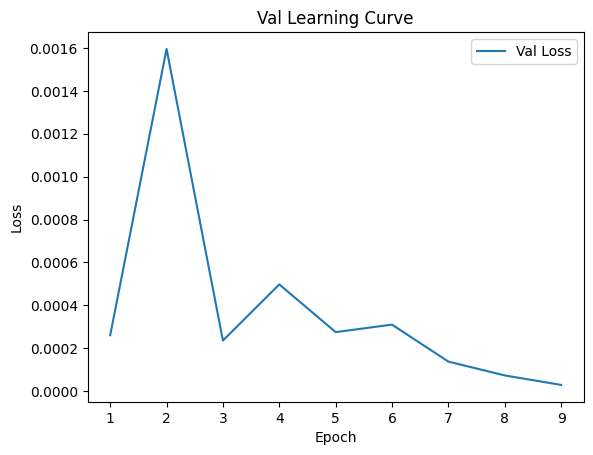


 Epoch: (10/30) Loss = 7.695559361309279e-06

 Epoch: (10/30) Loss_rmse = 0.0027740870136767626

 Epoch: (10/30) R^2 = 0.9985139966011047

 Epoch: (10/30) MAE = 0.002201557159423828
Spearman correlation coefficient: SignificanceResult(statistic=0.9697800059456425, pvalue=2.181376782266266e-59)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

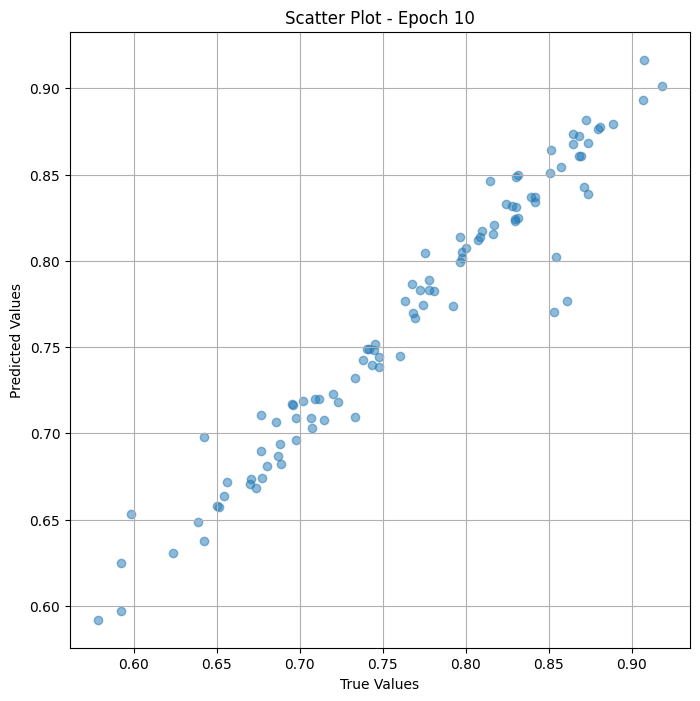

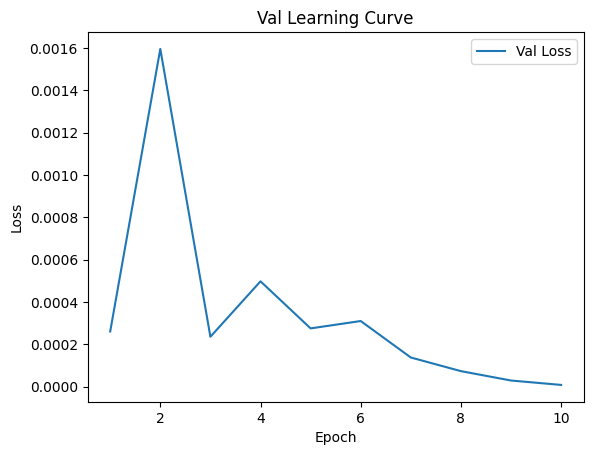


 Epoch: (11/30) Loss = 1.3781732377537992e-06

 Epoch: (11/30) Loss_rmse = 0.0011739562032744288

 Epoch: (11/30) R^2 = 0.9997338652610779

 Epoch: (11/30) MAE = 0.0011598467826843262
Spearman correlation coefficient: SignificanceResult(statistic=0.9706753127073211, pvalue=5.416864670398805e-60)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73

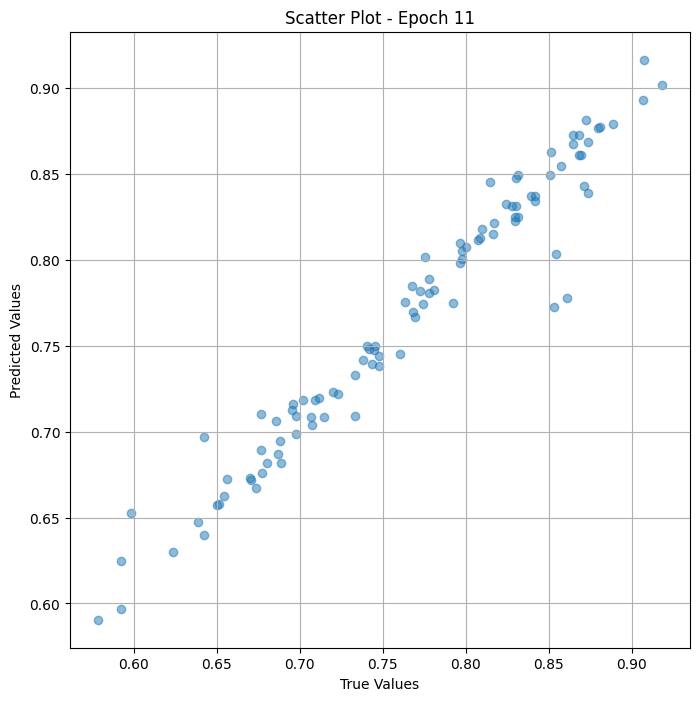

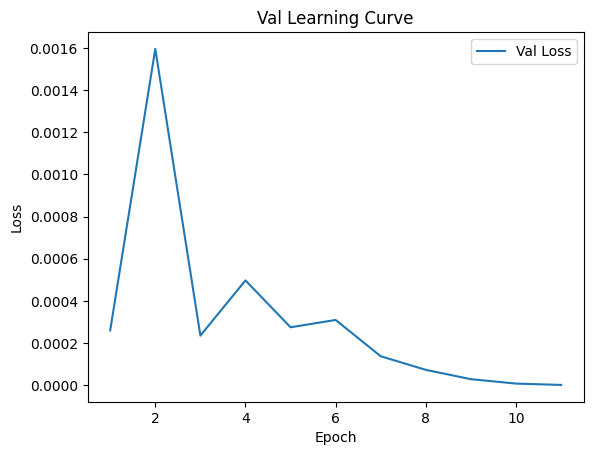


 Epoch: (12/30) Loss = 2.9995439945196267e-06

 Epoch: (12/30) Loss_rmse = 0.0017319191247224808

 Epoch: (12/30) R^2 = 0.9994208216667175

 Epoch: (12/30) MAE = 0.0016467869281768799
Spearman correlation coefficient: SignificanceResult(statistic=0.97235740419896, pvalue=3.5048004549514695e-61)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.733

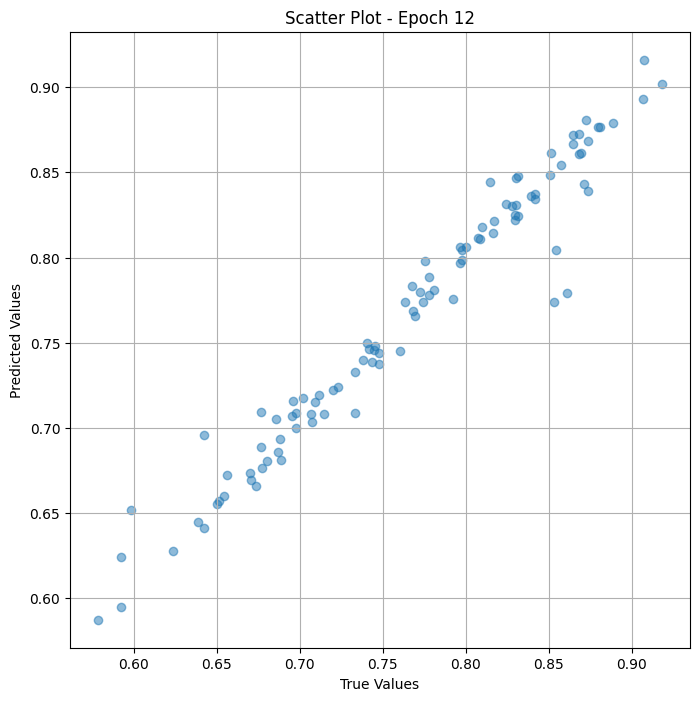

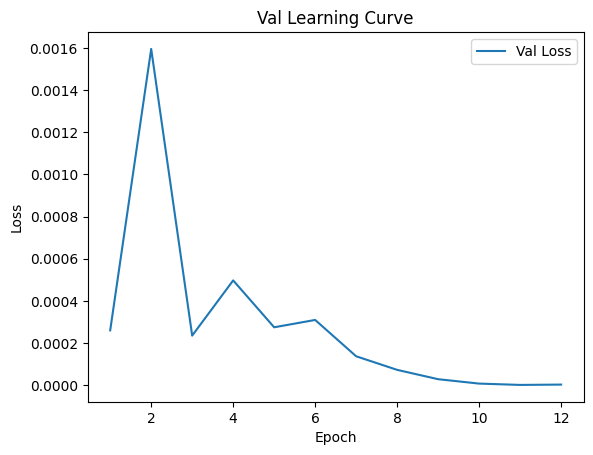


 Epoch: (13/30) Loss = 6.0461825341917574e-06

 Epoch: (13/30) Loss_rmse = 0.0024588985834270716

 Epoch: (13/30) R^2 = 0.9988325238227844

 Epoch: (13/30) MAE = 0.0024505406618118286
Spearman correlation coefficient: SignificanceResult(statistic=0.9751450638887325, pvalue=2.5261907530470035e-63)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7

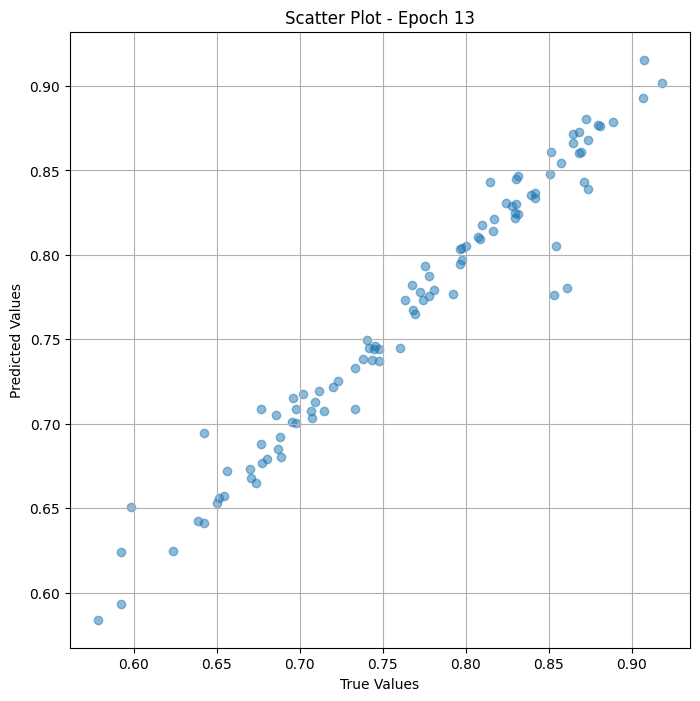

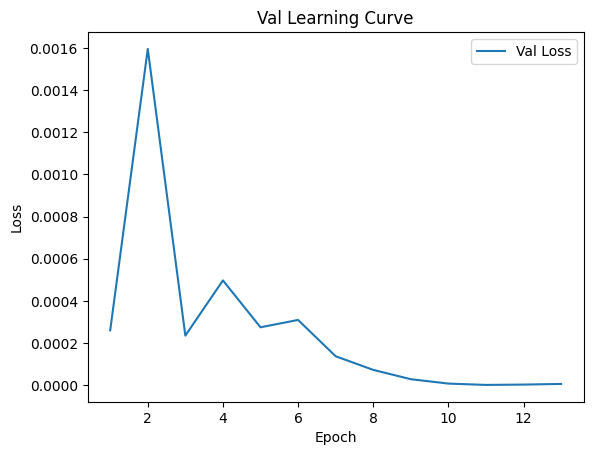

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-07.

 Epoch: (14/30) Loss = 5.863050773768919e-06

 Epoch: (14/30) Loss_rmse = 0.0024213737342506647

 Epoch: (14/30) R^2 = 0.9988678693771362

 Epoch: (14/30) MAE = 0.0024051517248153687
Spearman correlation coefficient: SignificanceResult(statistic=0.9767796769914944, pvalue=1.0716519618995936e-64)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713

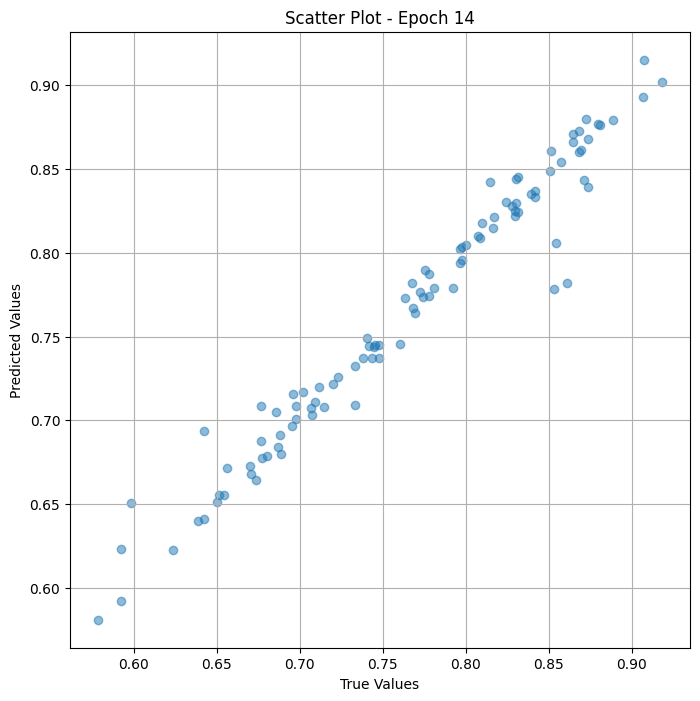

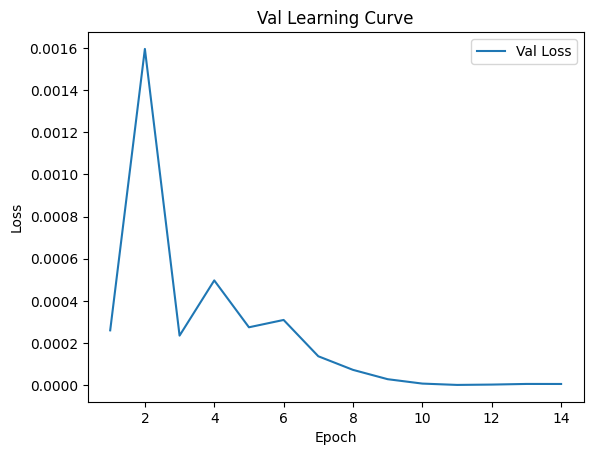


 Epoch: (15/30) Loss = 4.9038694669434335e-06

 Epoch: (15/30) Loss_rmse = 0.002214468317106366

 Epoch: (15/30) R^2 = 0.9990530610084534

 Epoch: (15/30) MAE = 0.0021701157093048096
Spearman correlation coefficient: SignificanceResult(statistic=0.9781022892530652, pvalue=7.01556871758352e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

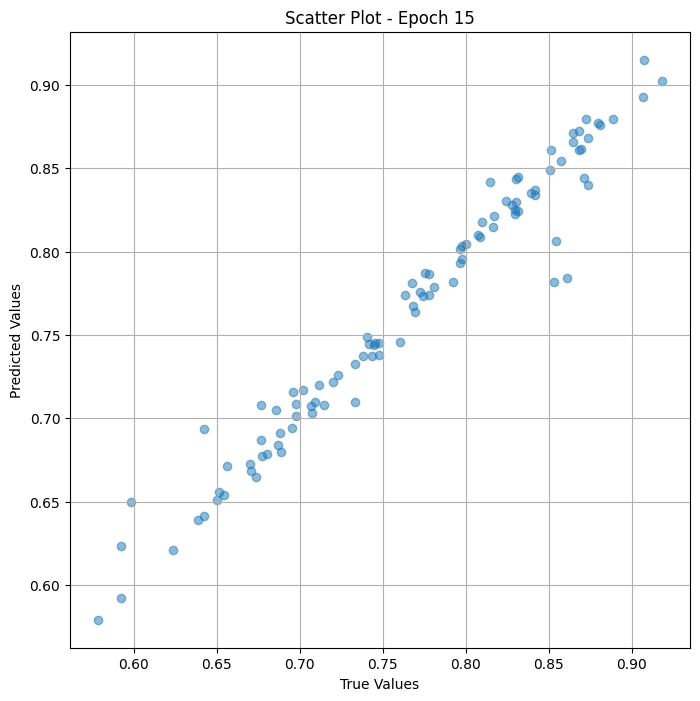

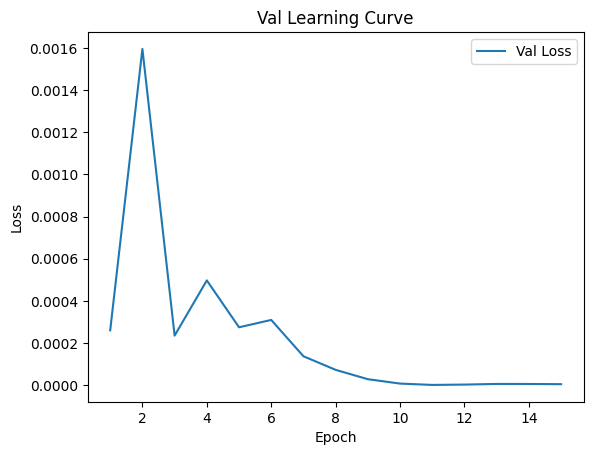


 Epoch: (16/30) Loss = 4.507855010160711e-06

 Epoch: (16/30) Loss_rmse = 0.0021231709979474545

 Epoch: (16/30) R^2 = 0.9991295337677002

 Epoch: (16/30) MAE = 0.002064645290374756
Spearman correlation coefficient: SignificanceResult(statistic=0.9780005498483291, pvalue=8.703089617372247e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

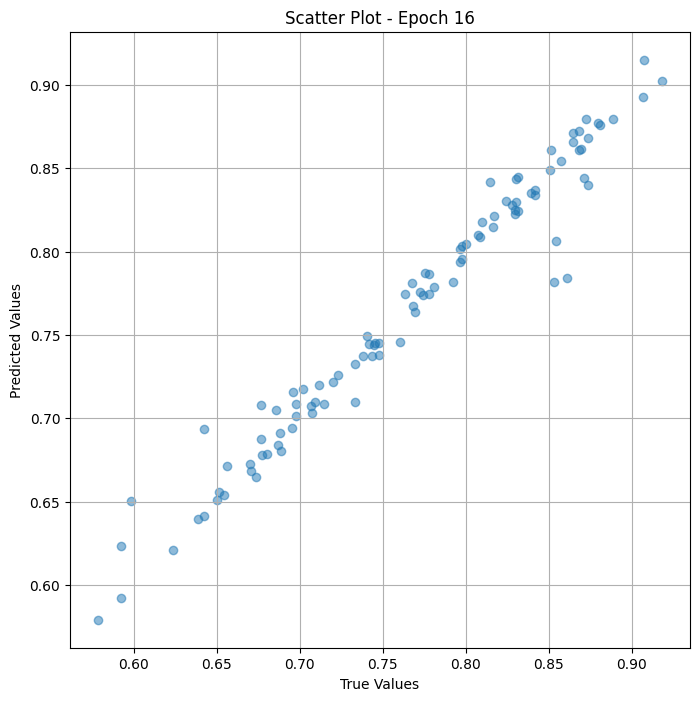

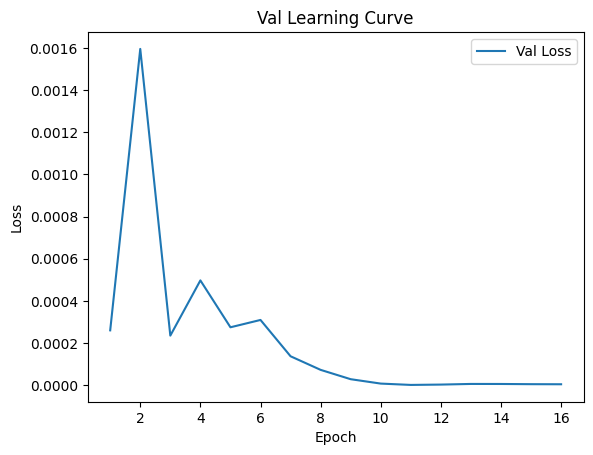

Epoch 0.00: reducing learning rate of group 0 to 1.0000e-08.

 Epoch: (17/30) Loss = 4.053173597640125e-06

 Epoch: (17/30) Loss_rmse = 0.0020132495556026697

 Epoch: (17/30) R^2 = 0.9992173314094543

 Epoch: (17/30) MAE = 0.001936584711074829
Spearman correlation coefficient: SignificanceResult(statistic=0.97831255068952, pvalue=4.479194709152431e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.

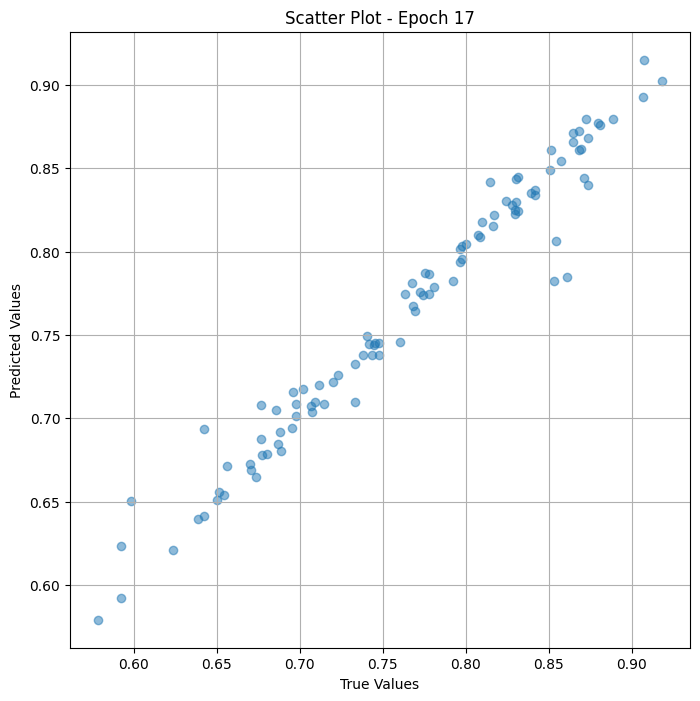

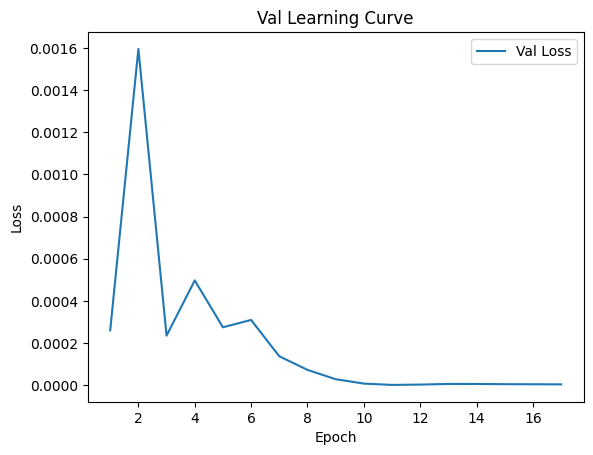


 Epoch: (18/30) Loss = 3.898101567756385e-06

 Epoch: (18/30) Loss_rmse = 0.001974361017346382

 Epoch: (18/30) R^2 = 0.9992473125457764

 Epoch: (18/30) MAE = 0.0018910914659500122
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

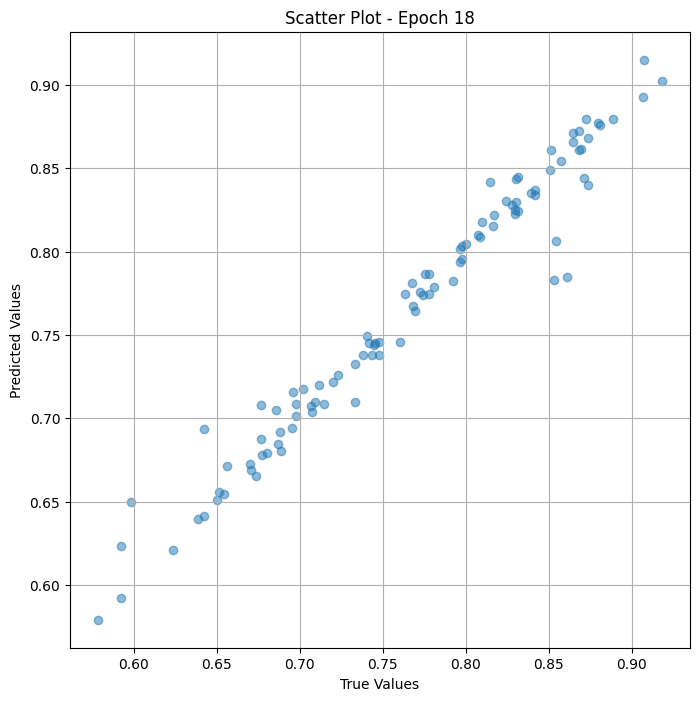

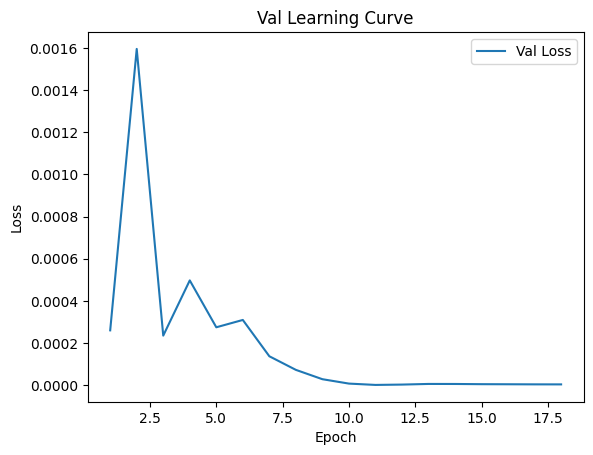


 Epoch: (19/30) Loss = 3.869925421895459e-06

 Epoch: (19/30) Loss_rmse = 0.001967212650924921

 Epoch: (19/30) R^2 = 0.9992527365684509

 Epoch: (19/30) MAE = 0.0018827170133590698
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

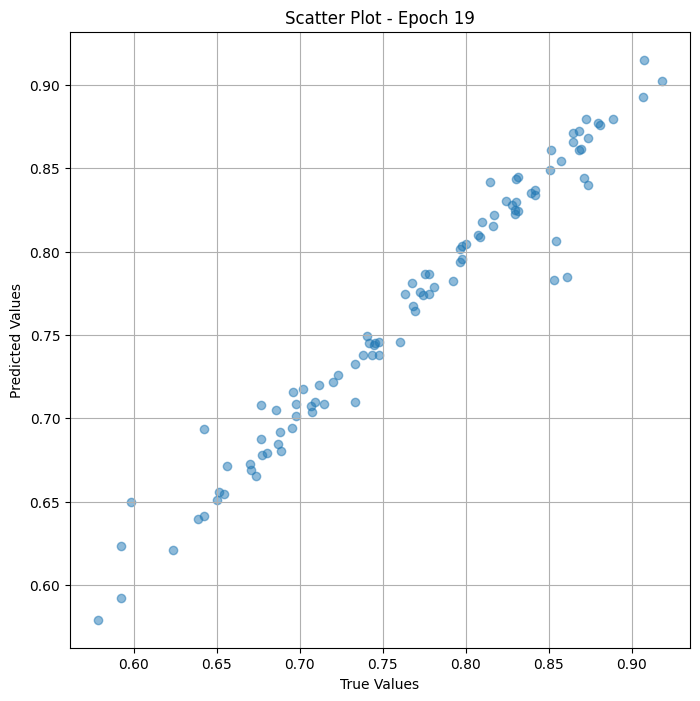

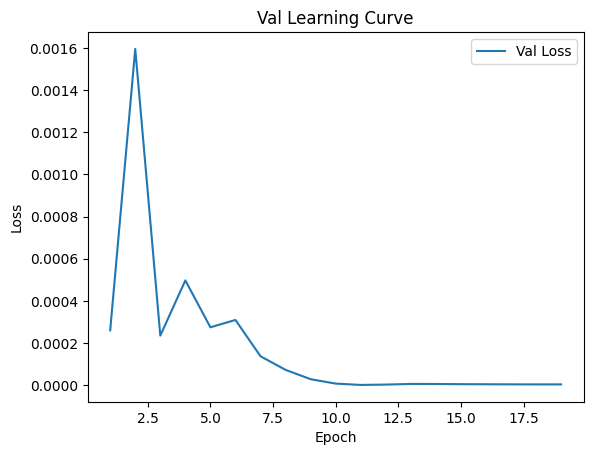


 Epoch: (20/30) Loss = 3.840138560917694e-06

 Epoch: (20/30) Loss_rmse = 0.0019596272613853216

 Epoch: (20/30) R^2 = 0.9992584586143494

 Epoch: (20/30) MAE = 0.0018739253282546997
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.733

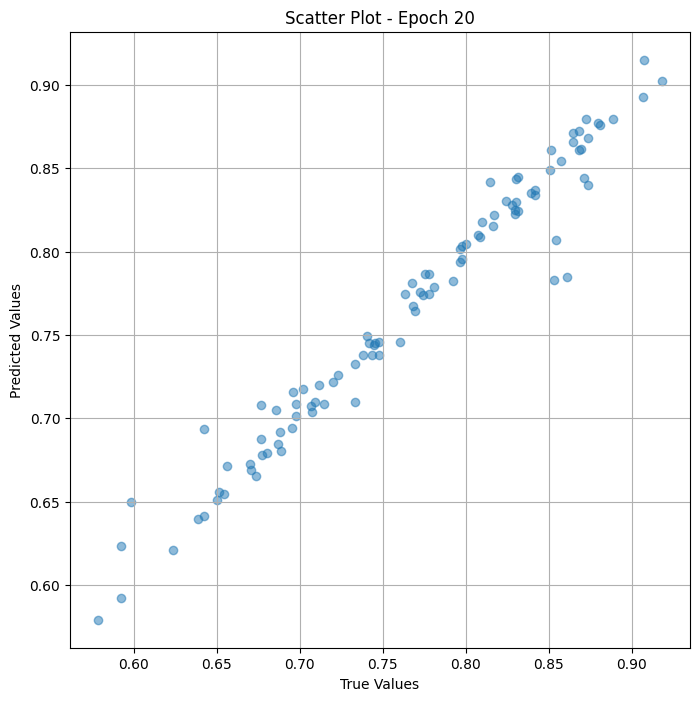

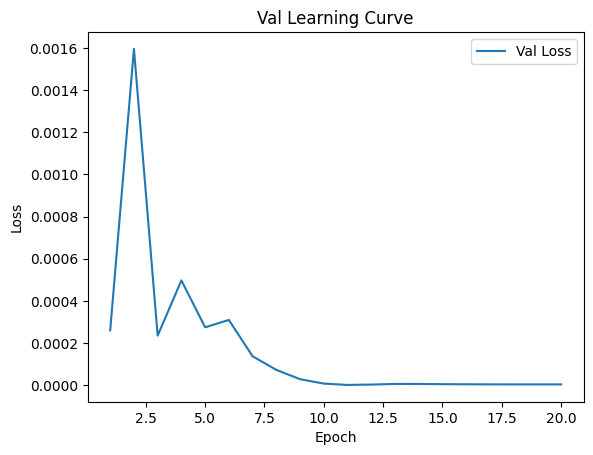


 Epoch: (21/30) Loss = 3.808229394053342e-06

 Epoch: (21/30) Loss_rmse = 0.0019514685263857245

 Epoch: (21/30) R^2 = 0.999264657497406

 Epoch: (21/30) MAE = 0.0018645226955413818
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

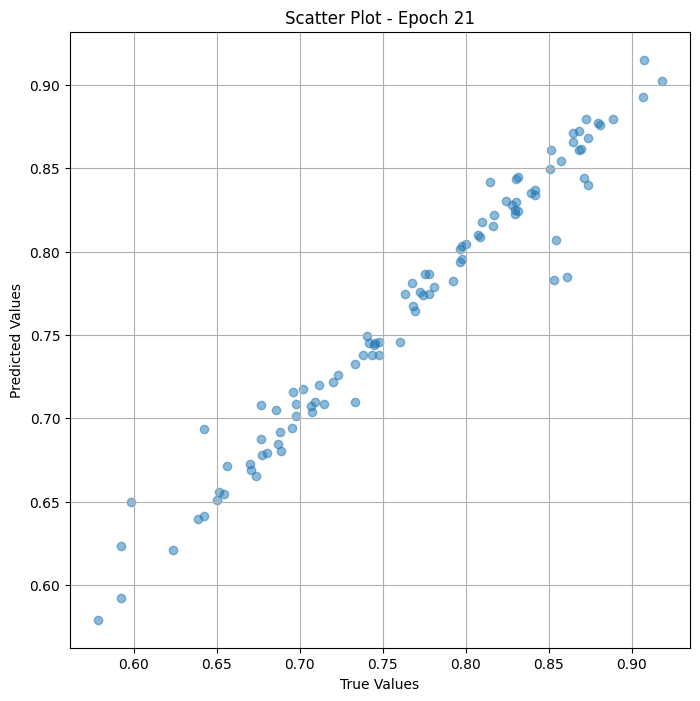

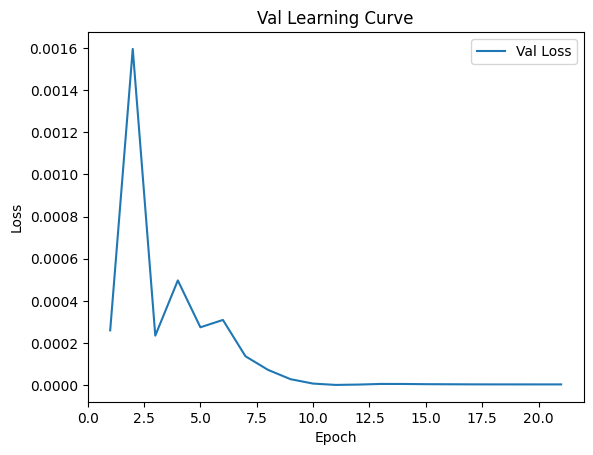


 Epoch: (22/30) Loss = 3.7760191844427027e-06

 Epoch: (22/30) Loss_rmse = 0.0019431981490924954

 Epoch: (22/30) R^2 = 0.9992708563804626

 Epoch: (22/30) MAE = 0.0018549859523773193
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73

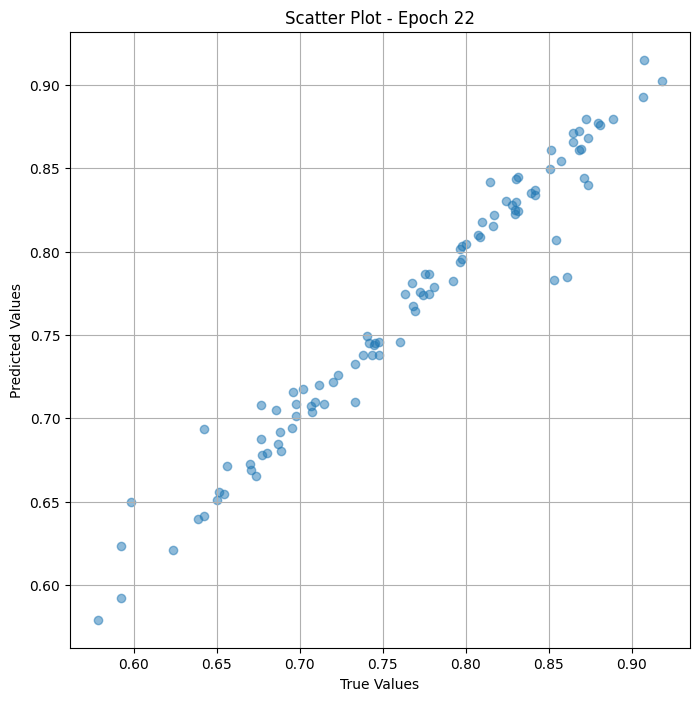

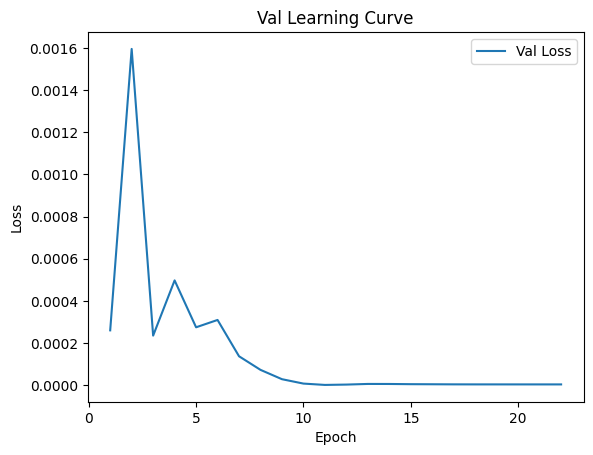


 Epoch: (23/30) Loss = 3.74333012587158e-06

 Epoch: (23/30) Loss_rmse = 0.0019347687484696507

 Epoch: (23/30) R^2 = 0.9992771744728088

 Epoch: (23/30) MAE = 0.0018452852964401245
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.7333

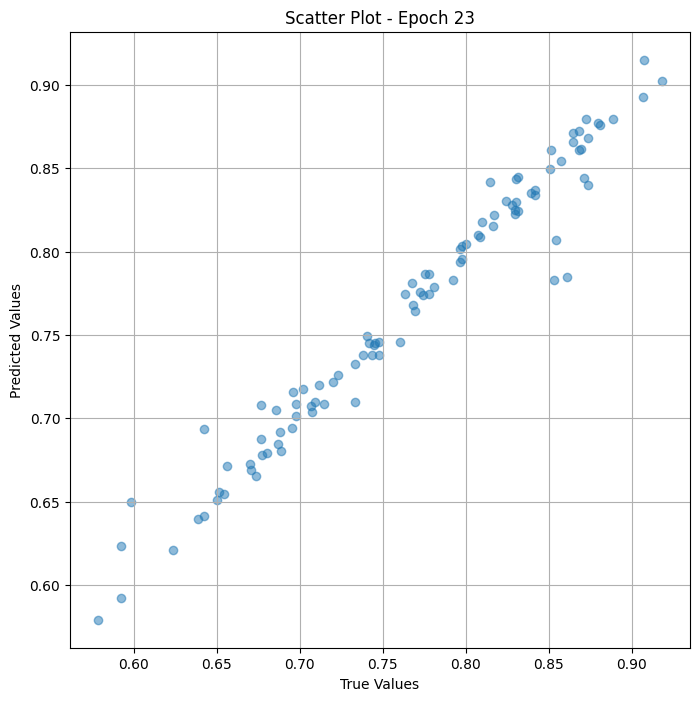

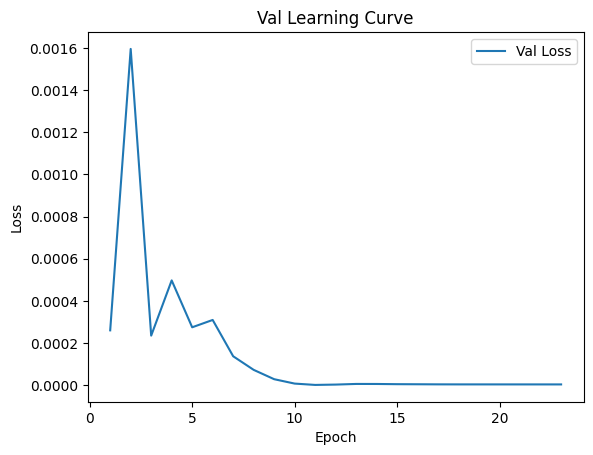


 Epoch: (24/30) Loss = 3.709637894644402e-06

 Epoch: (24/30) Loss_rmse = 0.00192604202311486

 Epoch: (24/30) R^2 = 0.9992836713790894

 Epoch: (24/30) MAE = 0.0018352717161178589
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333

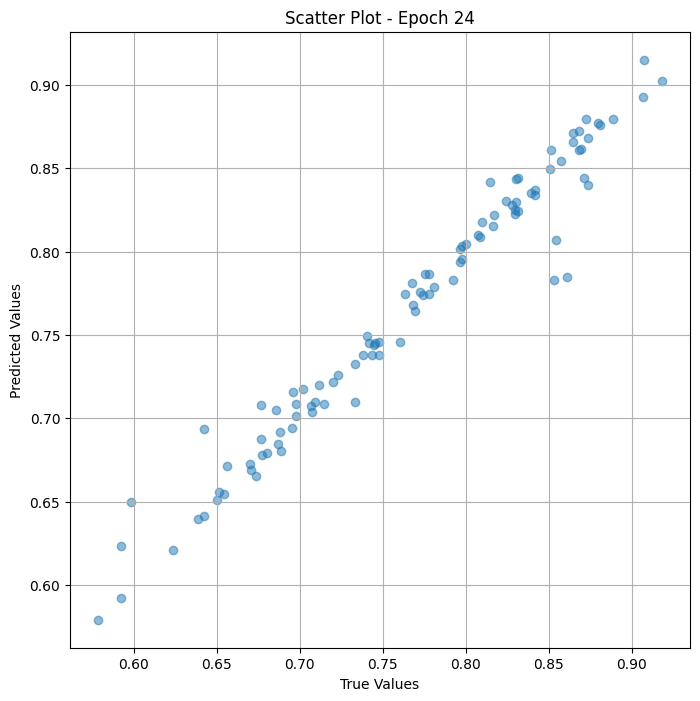

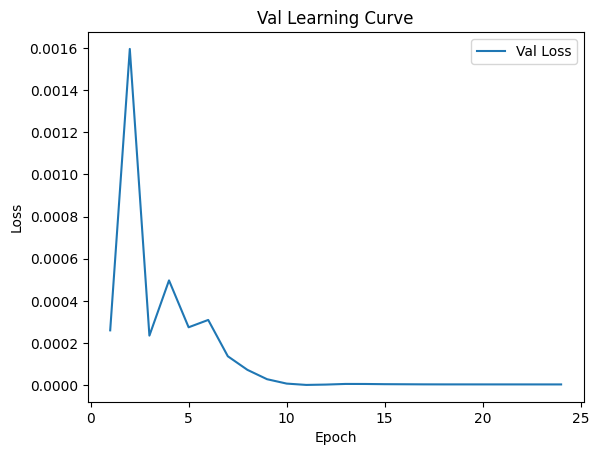


 Epoch: (25/30) Loss = 3.6745564102602657e-06

 Epoch: (25/30) Loss_rmse = 0.0019169131992384791

 Epoch: (25/30) R^2 = 0.9992904663085938

 Epoch: (25/30) MAE = 0.0018248260021209717
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73

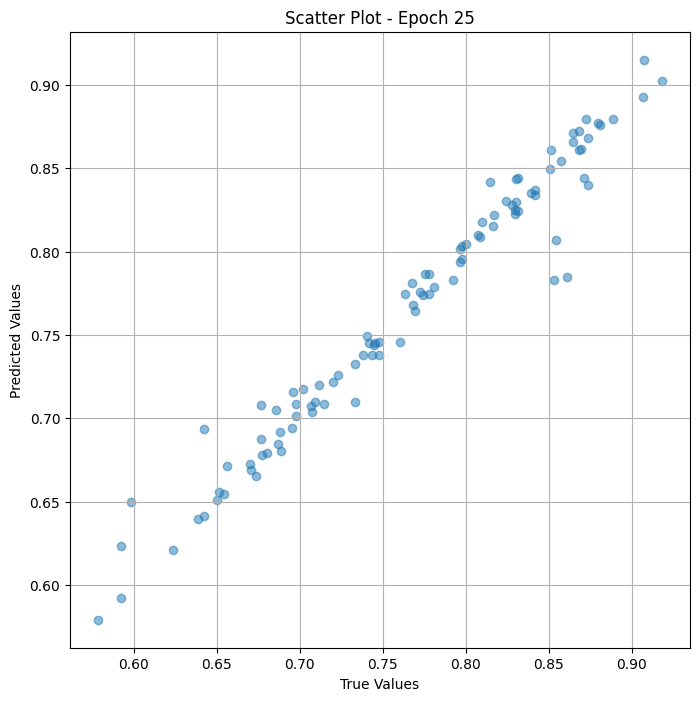

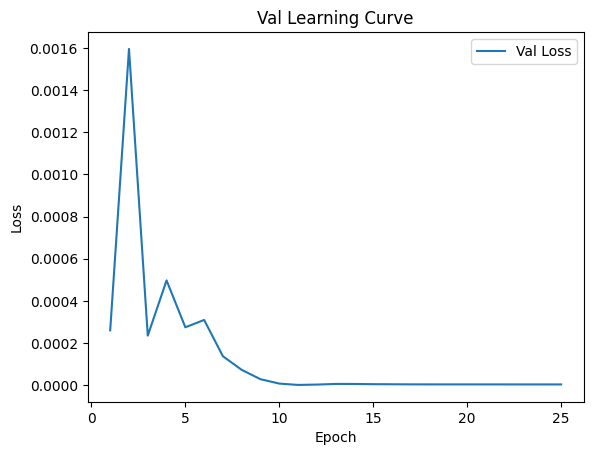


 Epoch: (26/30) Loss = 3.639693659351906e-06

 Epoch: (26/30) Loss_rmse = 0.0019077981123700738

 Epoch: (26/30) R^2 = 0.9992972016334534

 Epoch: (26/30) MAE = 0.0018143802881240845
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.733

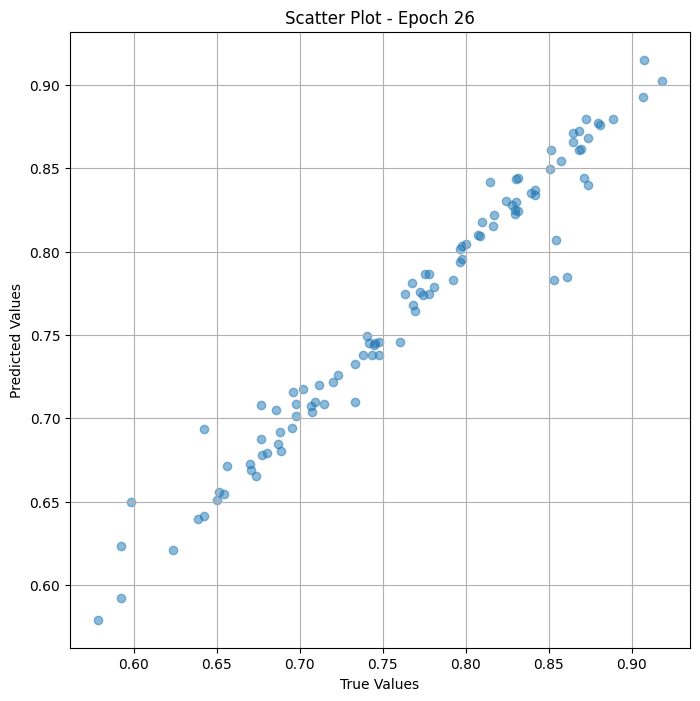

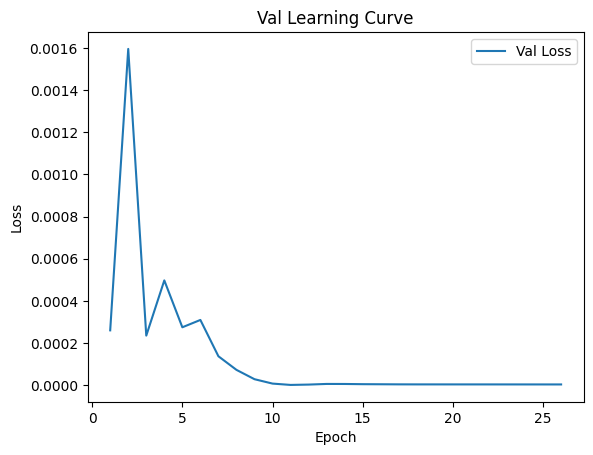


 Epoch: (27/30) Loss = 3.604063522288925e-06

 Epoch: (27/30) Loss_rmse = 0.00189843715634197

 Epoch: (27/30) R^2 = 0.9993040561676025

 Epoch: (27/30) MAE = 0.0018036365509033203
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73333

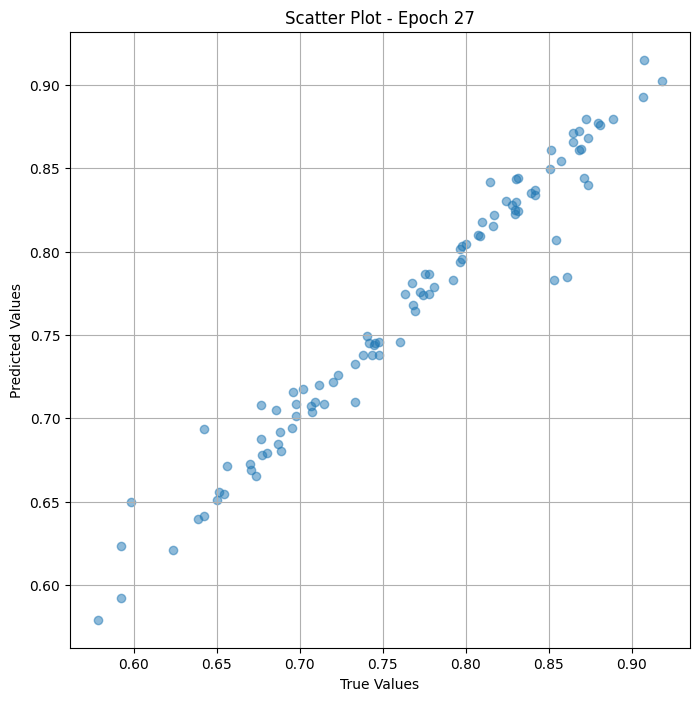

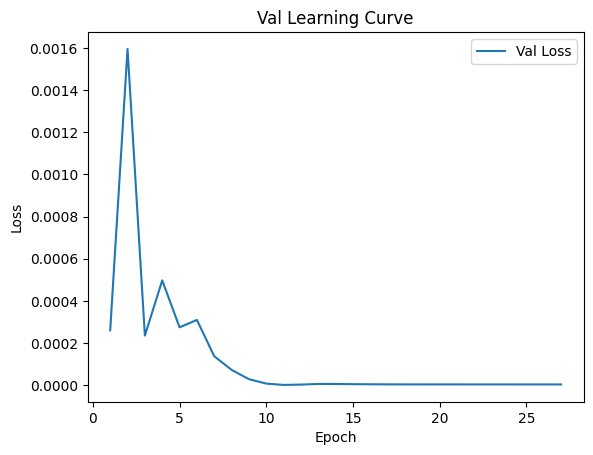


 Epoch: (28/30) Loss = 3.5684206523001194e-06

 Epoch: (28/30) Loss_rmse = 0.0018890263745561242

 Epoch: (28/30) R^2 = 0.9993109703063965

 Epoch: (28/30) MAE = 0.0017928332090377808
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73

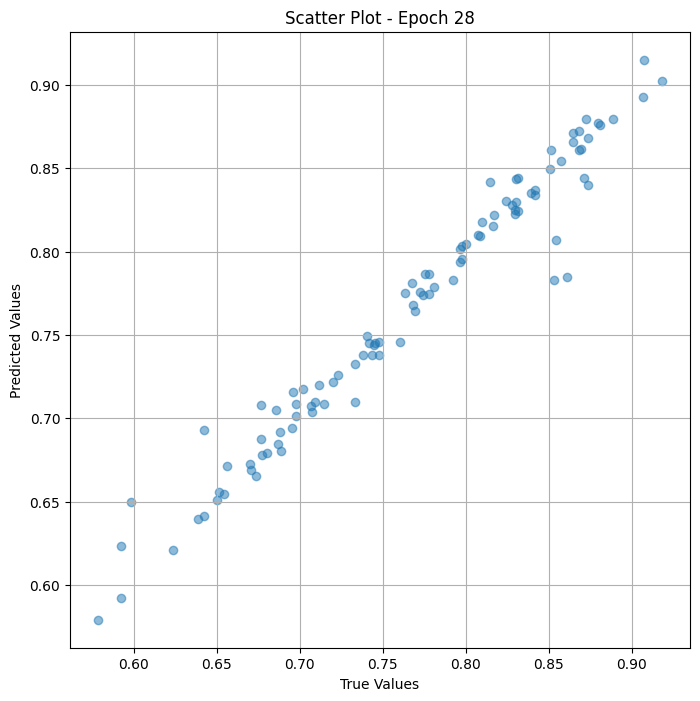

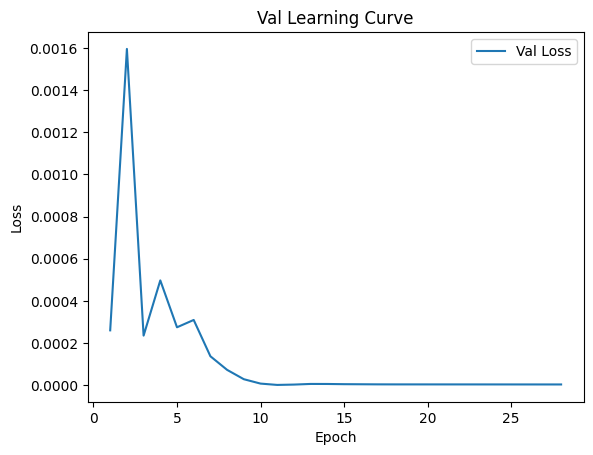


 Epoch: (29/30) Loss = 3.5322568692208733e-06

 Epoch: (29/30) Loss_rmse = 0.0018794299103319645

 Epoch: (29/30) R^2 = 0.9993179440498352

 Epoch: (29/30) MAE = 0.0017817914485931396
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.73

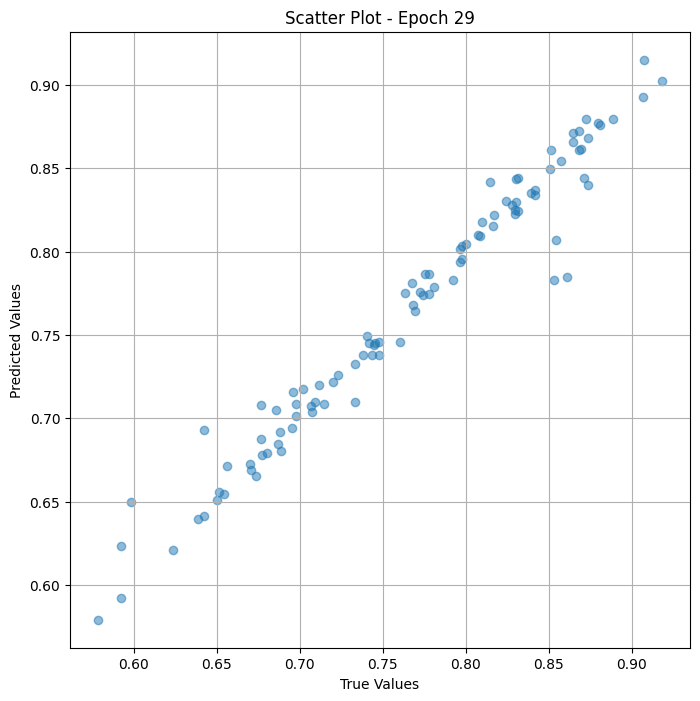

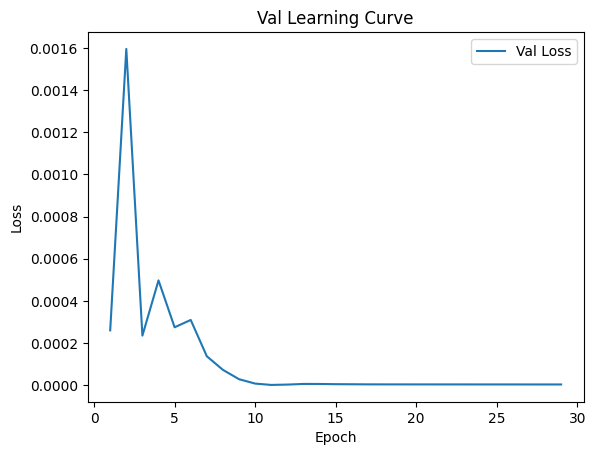


 Epoch: (30/30) Loss = 3.495360488159349e-06

 Epoch: (30/30) Loss_rmse = 0.0018695882754400373

 Epoch: (30/30) R^2 = 0.9993250370025635

 Epoch: (30/30) MAE = 0.0017705410718917847
Spearman correlation coefficient: SignificanceResult(statistic=0.9783532464514146, pvalue=4.104535801372144e-66)

 true_values_list_val : 100

 predicted_values_list_val : 100

 true_values_list_val : [0.7407407, 0.84158415, 0.84158415, 0.70652175, 0.853211, 0.6698113, 0.67676765, 0.7920792, 0.91818184, 0.7755102, 0.76344085, 0.7809524, 0.62376237, 0.6952381, 0.69736844, 0.65, 0.7777778, 0.70212764, 0.68817204, 0.6545454, 0.8608696, 0.9074074, 0.74757284, 0.872549, 0.68041235, 0.8, 0.827957, 0.7478261, 0.64220184, 0.7979798, 0.57843137, 0.6421053, 0.6513761, 0.7692308, 0.8888889, 0.72, 0.63829786, 0.65591395, 0.67676765, 0.82978725, 0.68686867, 0.8172043, 0.76829267, 0.90654206, 0.7604167, 0.8796296, 0.6886792, 0.8681319, 0.59210527, 0.83035713, 0.80733943, 0.745283, 0.7962963, 0.7090909, 0.8695652, 0.733

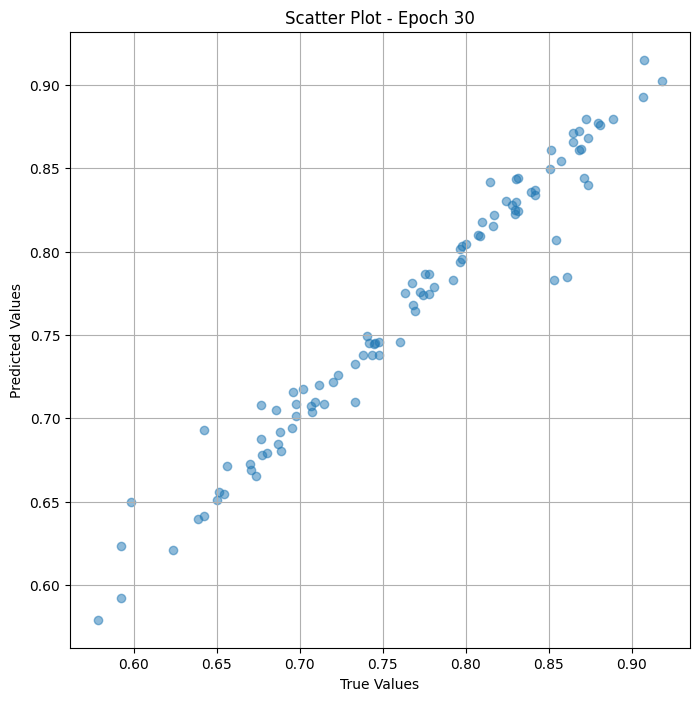

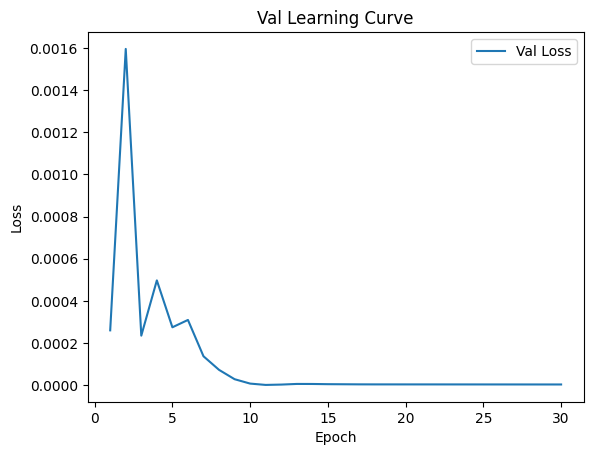

In [ ]:
# val the model and save weights
fit(30, model_vit_sval , val_dl )
torch.save(model_vit_sval.state_dict(), "model_weights_s")

## Test

In [ ]:
params = [param for param in list(model_vit_test.parameters()) if param.requires_grad == True ]
optimizer = torch.optim.Adam(params, lr=1e-4 ,weight_decay=1e-7)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

In [ ]:
# Define the plot_scatter function
def plot_scatter(true_values, predicted_values, epoch):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.title(f'Scatter Plot - Epoch {epoch+1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def plot_learning_curve(loss_list):
    plt.plot(range(1, len(loss_list) + 1), loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Learning Curve')
    plt.legend()
    plt.show()

def fit(epochs,model_vit_test, test_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    mae_func = nn.L1Loss()
    total_loss_list = []


    for epoch in range(epochs):
        model_vit_test.eval()
        batch_num = 32
        true_values_list = []
        predicted_values_list = []

        for x_trans, yb in test_dl:
            total_loss = 0
            total_loss_rmse = 0
            total_r2 = 0
            total_mae = 0
            total_spearman =0
            #total_spearman = 0

            yb = yb.float()

            # Pass the optimizer so that the model will get trained
            preds = model_vit_test(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss_rmse = torch.sqrt(loss)
            mae = mae_func(preds.squeeze(), yb)

            # Calculate R-squared
            mean_y = torch.mean(yb)
            ss_total = torch.sum((yb - mean_y)**2)
            ss_residual = torch.sum((yb - preds.squeeze())**2)
            r2 = 1 - (ss_residual / ss_total)

            #calculate  spearman
            spearman_corr = spearmanr(true_values_list, predicted_values_list)

             # Accumulate true and predicted values for scatter plot
            true_values_list.extend(yb.cpu().detach().numpy())
            predicted_values_list.extend(preds.squeeze().cpu().detach().numpy())



            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Print batch information
            #print('\nBatch:', batch_num)
            #print('True Values:', yb.cpu().detach().numpy())
            #print('Predicted Values:', preds.squeeze().cpu().detach().numpy())

            # Accumulate losses, R-squared, MAE, and Spearman values for the epoch
            total_loss = loss.item()
            total_loss_rmse = loss_rmse.item()
            total_r2 = r2.item()
            total_mae = mae.item()

            # Increment batch number
            batch_num += 10
        # Adjust learning rate scheduler based on total_loss
        sched.step(total_loss, total_loss_rmse)

        # Calculate mean R-squared, MAE, and Spearman for the epoch
        mean_r2 = total_r2 / batch_num
        mean_mae = total_mae / batch_num
        #mean_spearman = total_spearman / len(train_dl)

        # Print epoch information
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss_rmse = {total_loss_rmse}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) R^2 = {total_r2}')
        print('\n', f'Epoch: ({epoch+1}/{epochs}) MAE = {total_mae}')
        print("Spearman correlation coefficient:", spearman_corr)
        print('\n', f"true_values_list_val : { len(true_values_list)}")
        print('\n', f"predicted_values_list_val : {len(predicted_values_list)}")
        print('\n', f"true_values_list_val : { true_values_list}")
        print('\n', f"predicted_values_list_val : {predicted_values_list}")
        total_loss_list.append(total_loss)
        plot_scatter(true_values_list, predicted_values_list, epoch)
        plot_learning_curve(total_loss_list)

In [ ]:
# val the model and save weights
fit(50, model_vit_test , test_dl )
torch.save(model_vit_test.state_dict(), "model_weights_s")

In [ ]:
true_values_list_test = []
predicted_values_list_test = []

for x_trans, yb in test_dl:
    preds = model_vit_test(x_trans)
    true_values_list_test.extend(yb.cpu().detach().numpy())
    predicted_values_list_test.extend(preds.squeeze().cpu().detach().numpy())



# Assuming 'df_test_vehicle' is your original DataFrame and 'true_values' and 'predicted_values' are lists of true and predicted values
df_result_fine = pd.DataFrame({
    'Image Path': df_test_vehicle['preprocessed_image_path'],
    'True Value': true_values_list_test,  # Replace with your actual true values
    'Predicted Value': predicted_values_list_test # Replace with your actual predicted values
})

# Display the resulting DataFrame
print(df_result_fine)

                                           Image Path  True Value  \
0    /content/vehicle/n03791053_5855_preprocessed.jpg    0.817308   
1      /content/vehicle/000000406329_preprocessed.jpg    0.764151   
2   /content/vehicle/n04231693_18551_preprocessed.jpg    0.754717   
3   /content/vehicle/n04231693_19460_preprocessed.jpg    0.700000   
4      /content/vehicle/000000328185_preprocessed.jpg    0.865979   
..                                                ...         ...   
95  /content/vehicle/n03670208_12822_preprocessed.jpg    0.939394   
96   /content/vehicle/n03512147_1375_preprocessed.jpg    0.817204   
97   /content/vehicle/n04166281_4975_preprocessed.jpg    0.875000   
98  /content/vehicle/n03670208_42256_preprocessed.jpg    0.870968   
99   /content/vehicle/n04349306_4552_preprocessed.jpg    0.820755   

    Predicted Value  
0          0.832856  
1          0.768504  
2          0.759976  
3          0.699987  
4          0.841688  
..              ...  
95         0.9162

# ทดสอบกับรูปอื่นๆ

In [ ]:
model = ViTMem_model_test()
image = Image.open("/content/animal/000000002066.jpg")

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size expected by the model
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Normalize the image
])

# Apply preprocessing transforms
input_data = preprocess(image)

# Add batch dimension as the model expects a batch
input_data = input_data.unsqueeze(0)

# Assuming ViTMem_model is a PyTorch model
model = ViTMem_model_test()
memorability = model(input_data)

print(f"Estimated memorability: {memorability}")



Estimated memorability: tensor([[0.4973]], grad_fn=<SigmoidBackward0>)
